In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%%capture
!pip install netcdf4
!pip install ruptures
!pip install geopandas
!pip install rioxarray
!pip install pymannkendall
!pip install xclim
!pip install rasterio
!pip install salem

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import ruptures as rpt
import scipy.stats as stats
import matplotlib.pyplot as plt
import rioxarray
from geopandas import read_file as gpd_read_file
import pymannkendall as mk
import xclim
import pylab as pl
import seaborn as sns
import zipfile
import geopandas as gpd
import salem
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#EXTRAYENDO EL SHP DE LORETO

<Axes: >

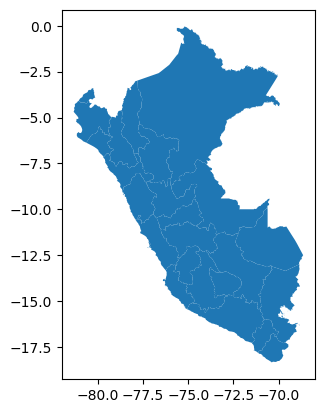

In [ ]:
shp_Peru = gpd_read_file("/content/drive/MyDrive/PROGRAMACIÓN_2/DATA/shapefile/shapefiles_peru/Departamentos.shp")
shp_Peru.plot()

In [ ]:
def xr_crop(shp_i, netcdf_i):

  # get box
  box_i = shp_i.total_bounds

  # crop based on box
  crop_netcdf_i = netcdf_i.where((netcdf_i["longitude"] > box_i[0]) & # min lon
                                 (netcdf_i["longitude"] < box_i[2]) & # max lon
                                 (netcdf_i["latitude"] > box_i[1]) & # min lat
                                 (netcdf_i["latitude"] < box_i[3]), # max lat
                                 drop = True)

  return crop_netcdf_i

def xr_shp_to_grid(shp_i, netcdf_array):

  # get real box
  shp_i_geometry = shp_i.geometry

  # adding crs
  mask = netcdf_array.rio.set_crs(shp_i.crs)

  # "rasterizing"
  mask = mask.rio.clip(shp_i_geometry, drop = False)

  # making "True/False" values
  mask.values[~np.isnan(mask.values)] = 1

  return mask.drop(["time", "spatial_ref"])


def xr_mask(grid_mask, netcdf_i):

  # masking
  mask_netcdf_i = netcdf_i.where(grid_mask == True)

  return mask_netcdf_i

In [ ]:
shp_Peru

DEPCOD         DEPNOM                                           geometry
0      01       AMAZONAS  POLYGON ((-77.71584 -5.10859, -77.71561 -5.108...
1      02         ANCASH  POLYGON ((-77.43826 -8.41625, -77.43879 -8.419...
2      03       APURIMAC  POLYGON ((-73.51174 -13.38481, -73.50822 -13.3...
3      04       AREQUIPA  POLYGON ((-71.89395 -14.78905, -71.89342 -14.7...
4      05       AYACUCHO  POLYGON ((-73.74697 -13.75935, -73.74495 -13.7...
5      06      CAJAMARCA  POLYGON ((-78.68236 -7.39208, -78.68268 -7.392...
6      07         CALLAO  MULTIPOLYGON (((-77.22816 -12.06813, -77.22681...
7      08          CUSCO  POLYGON ((-70.86265 -13.80001, -70.86680 -13.8...
8      09   HUANCAVELICA  POLYGON ((-75.52429 -13.81763, -75.52566 -13.8...
9      10        HUANUCO  POLYGON ((-76.23089 -10.37179, -76.23136 -10.3...
10     11            ICA  POLYGON ((-76.08268 -13.13842, -76.08141 -13.1...
11     12          JUNIN  POLYGON ((-75.62894 -12.14156, -75.62988 -12.1...
12     13    LA LIBERTAD  POLYGON ((-79.45453 -6.94684, -79.45448 -6.946...
13     14     LAMBAYEQUE  POLYGON ((-79.41668 -6.00452, -79.41428 -6.002...
14     15           LIMA  POLYGON ((-77.81668 -10.69383, -77.82049 -10.6...
15     16         LORETO  POLYGON ((-76.02252 -6.09410, -76.02352 -6.094...
16     17  MADRE DE DIOS  POLYGON ((-70.40141 -13.09685, -70.40166 -13.0...
17     18       MOQUEGUA  POLYGON ((-71.39289 -16.98152, -71.39286 -16.9...
18     19          PASCO  POLYGON ((-76.65622 -10.64690, -76.65812 -10.6...
19     20          PIURA  POLYGON ((-80.29120 -4.43342, -80.29123 -4.432...
20     21           PUNO  MULTIPOLYGON (((-69.70369 -15.27509, -69.70277...
21     22     SAN MARTIN  POLYGON ((-76.11132 -7.18208, -76.11288 -7.181...
22     23          TACNA  POLYGON ((-70.45919 -16.92274, -70.45480 -16.9...
23     24         TUMBES  MULTIPOLYGON (((-80.39942 -3.50210, -80.39870 ...
24     25        UCAYALI  POLYGON ((-72.18673 -11.01059, -72.18549 -11.0...

<Axes: >

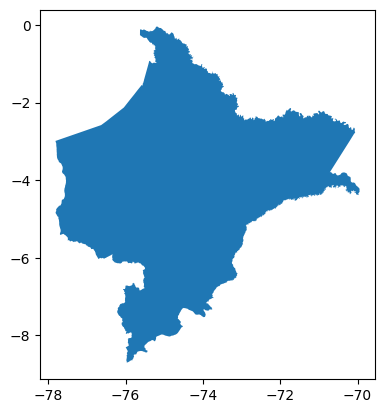

In [ ]:
loreto = shp_Peru.iloc[[15]]
loreto.plot()

#ABRIENDO EL ARCHIVO Y CORTÁNDOLO


In [ ]:
PISCOp = xr.open_dataset("/content/drive/MyDrive/PROGRAMACIÓN_2/DATA/data.nc")
PISCOp = PISCOp.rename({"X":"longitude","Y":"latitude","T":"time"})
PISCOp["time"] = pd.date_range(start="1981-01-01T12:00:00.000000000",freq="24H", periods= 13149)
PISCOp

<xarray.Dataset>
Dimensions:    (time: 13149, latitude: 198, longitude: 133)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01T12:00:00 ... 2016-12-31T12:00:00
  * latitude   (latitude) float32 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
Data variables:
    Prec       (time, latitude, longitude) float32 ...

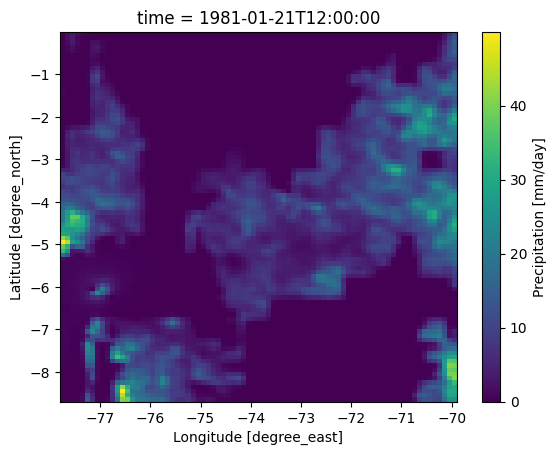

In [ ]:
PISCOpp_crop = xr_crop(shp_i=loreto, netcdf_i=PISCOp)
PISCOpp_crop.Prec.isel(time=20).plot()

In [ ]:
shp_exp_grid = xr_shp_to_grid(shp_i = loreto,
                              netcdf_array = PISCOpp_crop.Prec)


PISCOp_crop_masked = xr_mask(grid_mask = shp_exp_grid,
                             netcdf_i = PISCOpp_crop)

PISCOp_crop_masked

<xarray.Dataset>
Dimensions:    (time: 13149, latitude: 87, longitude: 79)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01T12:00:00 ... 2016-12-31T12:00:00
  * latitude   (latitude) float32 -0.05 -0.15 -0.25 -0.35 ... -8.45 -8.55 -8.65
  * longitude  (longitude) float32 -77.75 -77.65 -77.55 ... -70.15 -70.05 -69.95
Data variables:
    Prec       (time, latitude, longitude) float32 nan nan nan ... nan nan nan

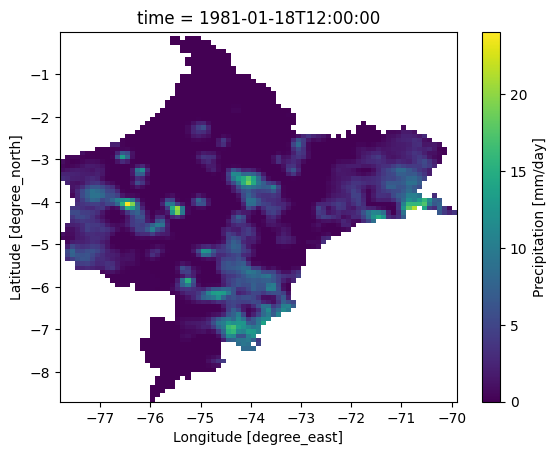

In [ ]:
PISCOp_crop_masked.Prec.isel(time=17).plot()

#ÍNDICES OCÉANO - ATMOSFÉRICOS

##THE PACIFIC DECADAL OSCILLATION INDEX (PDOi)

In [ ]:
PDO = pd.read_csv('https://psl.noaa.gov/data/correlation/pdo.data', sep='\s+', skiprows=1, skipfooter = 14, engine='python', header=None, na_values=-9.90, index_col=0)
PDO_year=PDO.mean(1)
PDO_filtro = PDO_year.loc["1981":"2016"]
PDO_filtro

0
1981    0.918333
1982    0.114167
1983    1.648333
1984    0.837500
1985    0.449167
1986    1.239167
1987    1.820833
1988    0.531667
1989   -0.179167
1990   -0.355833
1991   -0.419167
1992    0.928333
1993    1.416667
1994   -0.151667
1995    0.642500
1996    0.640833
1997    1.460833
1998    0.245833
1999   -1.063333
2000   -0.590000
2001   -0.562500
2002    0.220833
2003    0.969167
2004    0.345000
2005    0.375000
2006    0.190833
2007   -0.195833
2008   -1.292500
2009   -0.612500
2010   -0.312500
2011   -1.230833
2012   -1.100000
2013   -0.517500
2014    1.130833
2015    1.634167
2016    1.542500
dtype: float64

##THE EASTERN INDEX (index E)

In [ ]:
tabla = pd.read_csv("/content/drive/MyDrive/PROGRAMACIÓN_2/DATA/ecindex_ersstv5_CSV.csv")
tabla['month']=tabla['month'].astype(str)
tabla['year']=tabla['year'].astype(str)
tabla["FECHA"]=tabla.year.str.cat(tabla.month,sep="-")
tabla["FECHA"]=pd.to_datetime(tabla["FECHA"])
tabla=tabla.set_index("FECHA")
tabla=tabla.drop(columns=["year","month"],axis=1)

In [ ]:
tabla_E = tabla['E_index'].resample("Y").sum()
tabla_E=tabla_E.loc["1981-12-31":"2016-12-31"]
tabla_E

FECHA
1981-12-31    -5.52801
1982-12-31    11.29164
1983-12-31    27.49673
1984-12-31    -1.83103
1985-12-31    -9.69659
1986-12-31    -2.52522
1987-12-31    13.88367
1988-12-31   -10.33723
1989-12-31    -2.35616
1990-12-31    -5.90980
1991-12-31     0.27125
1992-12-31     4.32776
1993-12-31     5.82076
1994-12-31    -5.06080
1995-12-31    -9.20491
1996-12-31    -9.62179
1997-12-31    24.19572
1998-12-31    22.89806
1999-12-31    -1.28809
2000-12-31    -0.22549
2001-12-31    -4.47818
2002-12-31     0.90465
2003-12-31    -4.36658
2004-12-31    -4.49157
2005-12-31    -7.88823
2006-12-31     2.20899
2007-12-31   -11.14157
2008-12-31     8.14758
2009-12-31     3.18636
2010-12-31    -4.48054
2011-12-31    -0.95147
2012-12-31     4.84952
2013-12-31    -8.80650
2014-12-31     0.79893
2015-12-31    13.31732
2016-12-31     3.56155
Freq: A-DEC, Name: E_index, dtype: float64

##THE CENTRAL INDEX (index C)

In [ ]:
tabla_C = tabla['C_index'].resample("Y").sum()
tabla_C=tabla_C.loc["1981-12-31":"2016-12-31"]
tabla_C

FECHA
1981-12-31    -5.91708
1982-12-31     4.68182
1983-12-31   -11.14535
1984-12-31   -11.79383
1985-12-31    -9.06367
1986-12-31     1.02940
1987-12-31     7.22661
1988-12-31    -9.10022
1989-12-31   -13.79241
1990-12-31     5.84995
1991-12-31    10.01285
1992-12-31     6.36460
1993-12-31     2.35216
1994-12-31     9.09695
1995-12-31     3.05537
1996-12-31    -4.39944
1997-12-31     2.19741
1998-12-31   -15.13197
1999-12-31   -21.92176
2000-12-31   -17.17976
2001-12-31    -3.81540
2002-12-31     8.30668
2003-12-31     7.19082
2004-12-31     9.01808
2005-12-31     5.04171
2006-12-31     0.62358
2007-12-31    -2.69283
2008-12-31   -19.54408
2009-12-31     2.88932
2010-12-31    -6.41499
2011-12-31   -15.95063
2012-12-31    -6.32056
2013-12-31    -0.51171
2014-12-31     4.36319
2015-12-31    16.22703
2016-12-31     5.58685
Freq: A-DEC, Name: C_index, dtype: float64

##THE TROPICAL NORTH ATLANTIC INDEX (TNAi)

In [ ]:
TNA = pd.read_csv('https://psl.noaa.gov/data/correlation/tna.data', sep='\s+', skiprows=1, skipfooter = 6, engine='python', header=None, na_values=-99.99, index_col=0)
TNA_year=TNA.mean(1)
TNA_filtro = TNA_year.loc["1981":"2016"]
TNA_filtro

0
1981    0.227500
1982   -0.203333
1983    0.101667
1984   -0.282500
1985   -0.319167
1986   -0.489167
1987    0.318333
1988    0.092500
1989   -0.190000
1990    0.135000
1991   -0.247500
1992   -0.146667
1993   -0.170833
1994   -0.362500
1995    0.305833
1996    0.225000
1997    0.367500
1998    0.561667
1999    0.095000
2000   -0.048333
2001    0.260833
2002    0.173333
2003    0.330833
2004    0.481667
2005    0.671667
2006    0.470000
2007    0.241667
2008    0.315000
2009    0.146667
2010    1.013333
2011    0.450000
2012    0.310833
2013    0.482500
2014    0.125833
2015    0.257500
2016    0.434167
dtype: float64

##THE TROPICAL SOUTH ATLANTIC INDEX (TSAi)

In [ ]:
TSA = pd.read_csv('https://psl.noaa.gov/data/correlation/tsa.data', sep='\s+', skiprows=1, skipfooter = 4, engine='python', header=None, na_values=-99.99, index_col=0)
TSA_year=TSA.mean(1)
TSA_filtro = TSA_year.loc["1981":"2016"]
TSA_filtro

0
1981   -0.143333
1982   -0.285833
1983   -0.047500
1984    0.554167
1985    0.216667
1986    0.224167
1987    0.307500
1988    0.504167
1989    0.229167
1990    0.055000
1991    0.011667
1992   -0.537500
1993    0.183333
1994    0.036667
1995    0.325000
1996    0.390833
1997   -0.031667
1998    0.531667
1999    0.365000
2000    0.199167
2001    0.216667
2002    0.193333
2003    0.472500
2004    0.133333
2005    0.099167
2006    0.264167
2007    0.208333
2008    0.479167
2009    0.459167
2010    0.588333
2011    0.267500
2012   -0.090833
2013    0.216667
2014    0.176667
2015    0.295833
2016    0.520000
dtype: float64

##TN-TSi

In [ ]:
TNS = TNA_filtro-TSA_filtro
TNS

0
1981    0.370833
1982    0.082500
1983    0.149167
1984   -0.836667
1985   -0.535833
1986   -0.713333
1987    0.010833
1988   -0.411667
1989   -0.419167
1990    0.080000
1991   -0.259167
1992    0.390833
1993   -0.354167
1994   -0.399167
1995   -0.019167
1996   -0.165833
1997    0.399167
1998    0.030000
1999   -0.270000
2000   -0.247500
2001    0.044167
2002   -0.020000
2003   -0.141667
2004    0.348333
2005    0.572500
2006    0.205833
2007    0.033333
2008   -0.164167
2009   -0.312500
2010    0.425000
2011    0.182500
2012    0.401667
2013    0.265833
2014   -0.050833
2015   -0.038333
2016   -0.085833
dtype: float64

#ÍNDICES DE PRECIPITACIÓN EXTREMA
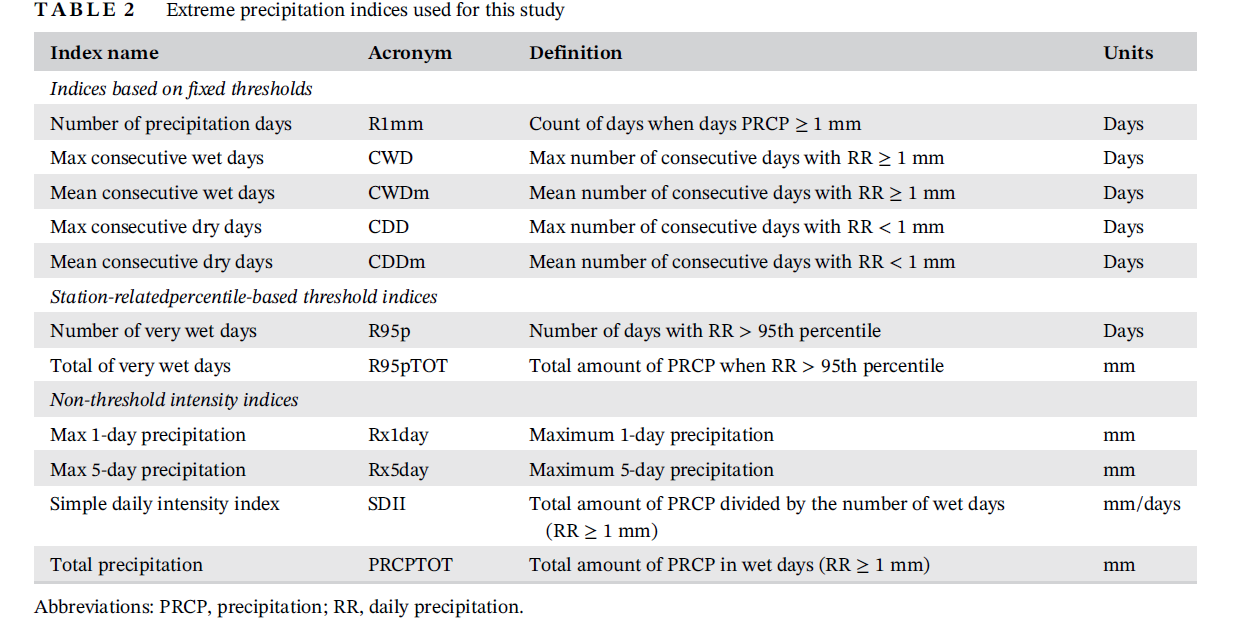

##HALLANDO LOS ÍNDICES

###R1mm (Number of precipitation day)

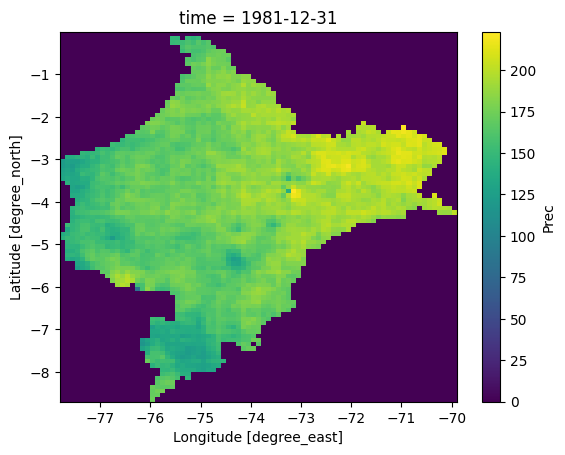

In [ ]:
R1mm = lambda da: (da >= 1).resample(time = 'Y').sum()
R1mm(PISCOp_crop_masked.Prec).isel(time=0).plot()

###CWD (Max consecutive wet days)

/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


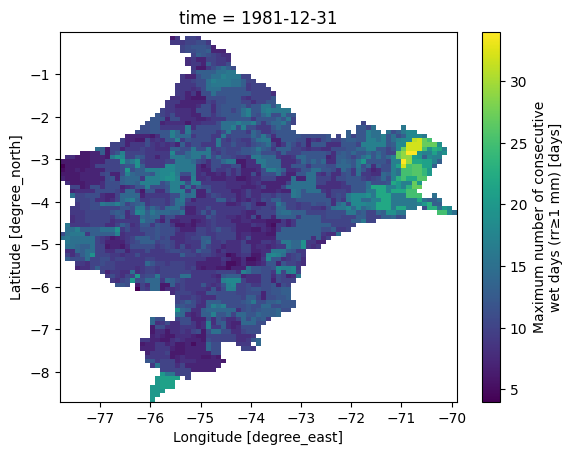

In [ ]:
CWD = xclim.indicators.icclim.CWD(PISCOp_crop_masked.Prec, freq='Y', resample_before_rl=True, ds=None)
CWD.isel(time=0).plot()

###CWDm (Mean consecutive wet days)

In [ ]:
def count_consecutive(da, tresh = 1, acum_type = 'greater than'):
    count = 0; overall_counter = []
    for i, j in enumerate(da):
        if acum_type == 'greater than':             count = count + 1 if da[i] > tresh else 0
        elif acum_type=='greater or equal than':    count = count + 1 if da[i] >= tresh else 0
        elif acum_type=='minor than':               count = count + 1 if da[i] < tresh else 0
        elif acum_type=='minor or equal than':      count = count + 1 if da[i] <= tresh else 0

        overall_counter.append(count)
    return np.nanmean(overall_counter)


In [ ]:
PISCOp_crop_masked.resample(time = 'Y').count().copy()* np.nan

<xarray.Dataset>
Dimensions:    (latitude: 87, longitude: 79, time: 36)
Coordinates:
  * latitude   (latitude) float32 -0.05 -0.15 -0.25 -0.35 ... -8.45 -8.55 -8.65
  * longitude  (longitude) float32 -77.75 -77.65 -77.55 ... -70.15 -70.05 -69.95
  * time       (time) datetime64[ns] 1981-12-31 1982-12-31 ... 2016-12-31
Data variables:
    Prec       (time, latitude, longitude) float64 nan nan nan ... nan nan nan

In [ ]:
def CWD(da):
    DA = da.resample(time = 'Y').count().copy()* np.nan
    for idx, g in da.resample(time = 'Y').groups.items():
        count = 0; overall_counter = []
        da_g = da.isel(time = g)

        DA.loc[idx] = xr.apply_ufunc(count_consecutive,
                                    da_g, 1., 'greater or equal than',
                                    input_core_dims = [['time'],[],[]],
                                    vectorize = True)
    #return DA.mean("time.year").round(0),DA.max()
    return DA

CWDm = CWD(PISCOp_crop_masked.Prec)

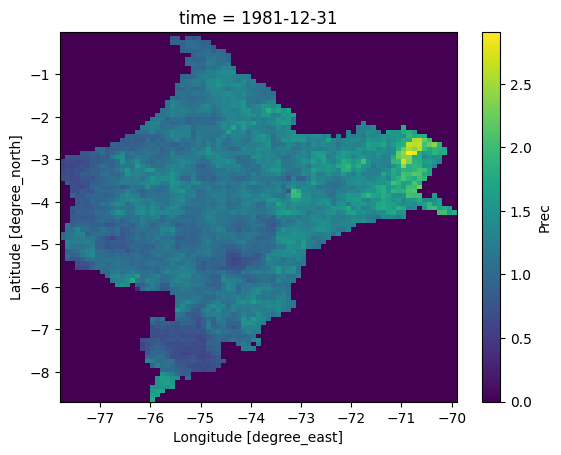

In [ ]:
CWDm.isel(time=0).plot()

###CDD (Max consecutive dry days)

/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


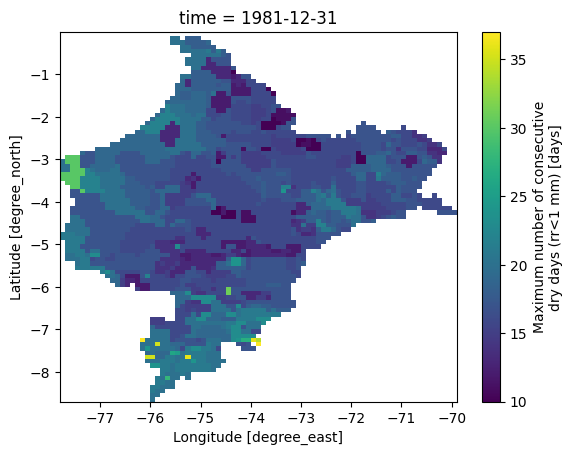

In [ ]:
CDD = xclim.indicators.icclim.CDD(PISCOp_crop_masked.Prec, freq='Y', resample_before_rl=True, ds=None)
CDD.isel(time=0).plot()

###CDDm (Mean consecutive dry days)

In [ ]:
def count_consecutive(da, tresh=1, acum_type='greater than'):
    count = 0
    overall_counter = []
    for i, j in enumerate(da):
        if acum_type == 'greater than':
            count = count + 1 if da[i] > tresh else 0
        elif acum_type == 'greater or equal than':
            count = count + 1 if da[i] >= tresh else 0
        elif acum_type == 'minor than':
            count = count + 1 if da[i] < tresh else 0
        elif acum_type == 'minor or equal than':
            count = count + 1 if da[i] <= tresh else 0

        overall_counter.append(count)
    return np.nanmean(overall_counter)

In [ ]:
PISCOp_crop_masked.resample(time = 'Y').count().copy()* np.nan

<xarray.Dataset>
Dimensions:    (latitude: 87, longitude: 79, time: 36)
Coordinates:
  * latitude   (latitude) float32 -0.05 -0.15 -0.25 -0.35 ... -8.45 -8.55 -8.65
  * longitude  (longitude) float32 -77.75 -77.65 -77.55 ... -70.15 -70.05 -69.95
  * time       (time) datetime64[ns] 1981-12-31 1982-12-31 ... 2016-12-31
Data variables:
    Prec       (time, latitude, longitude) float64 nan nan nan ... nan nan nan

In [ ]:
def CDD(da):
    DA = da.resample(time = 'Y').count().copy() * np.nan
    for idx, g in da.resample(time = 'Y').groups.items():
        count = 0; overall_counter = []
        da_g = da.isel(time = g)

        DA.loc[idx] = xr.apply_ufunc(count_consecutive,
                                    da_g, 1., 'minor than',
                                    input_core_dims = [['time'],[],[]],
                                    vectorize = True)


    #return DA_season.mean().round(0), DA_season.max()
    return DA
CDDm = CDD(PISCOp_crop_masked.Prec)

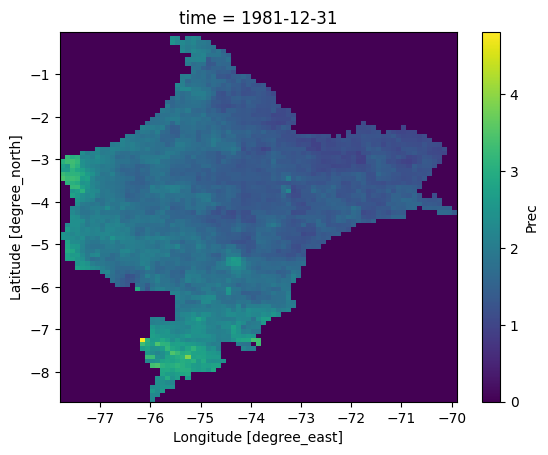

In [ ]:
CDDm.isel(time=0).plot()

###R95p (Number of very wet days)

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


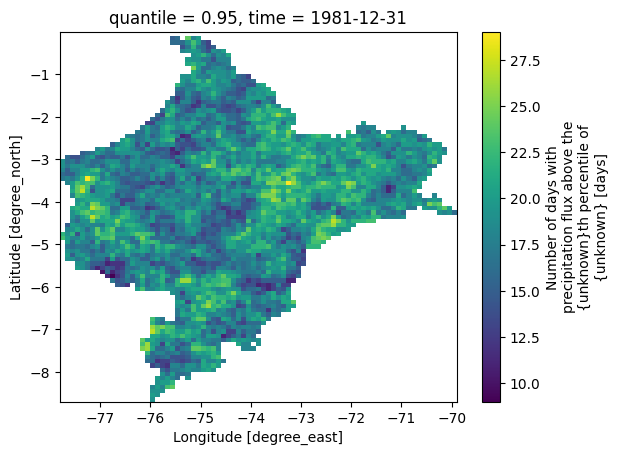

In [ ]:
PISCOp_crop_masked.attrs['units'] = "mm/day"
Pisco_95 = PISCOp_crop_masked.Prec.quantile(0.95,dim="time")
Pisco_95.attrs["units"]="mm/day"

R95p = xclim.indicators.icclim.R95p(PISCOp_crop_masked.Prec,Pisco_95, freq='Y', bootstrap=False, op='>', ds=None)
R95p.isel(time=0).plot()

###R95pTOT (Total of very wet days)

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


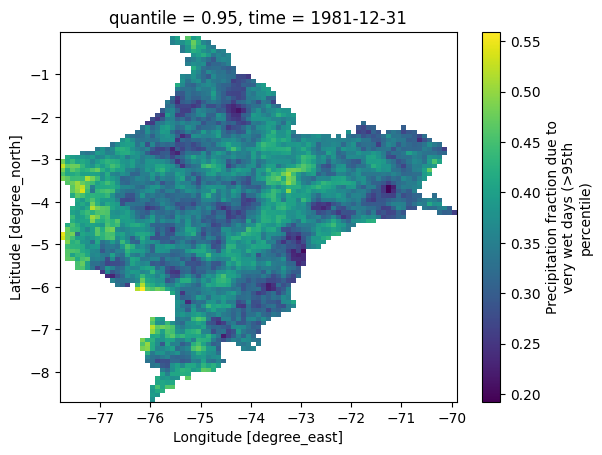

In [ ]:
PISCOp_crop_masked.attrs['units'] = "mm/day"
Pisco_95 = PISCOp_crop_masked.Prec.quantile(0.95,dim="time")
Pisco_95.attrs["units"]="mm/day"

R95pTOT=xclim.indicators.icclim.R95pTOT(PISCOp_crop_masked.Prec, Pisco_95, freq='Y', bootstrap=False, op='>', ds=None)
R95pTOT.isel(time=0).plot()

###Rx1day (Max 1-day precipitation)

/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


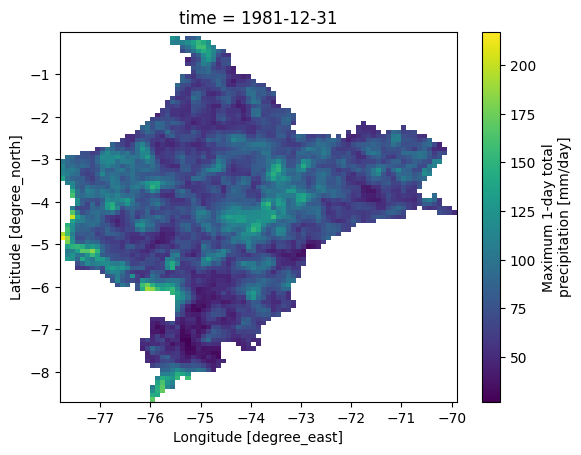

In [ ]:
RX1day = xclim.indicators.atmos.max_1day_precipitation_amount(PISCOp_crop_masked.Prec,freq='Y',ds=None)
RX1day.isel(time=0).plot()

###Rx5day (Max 5-day precipitation)

/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


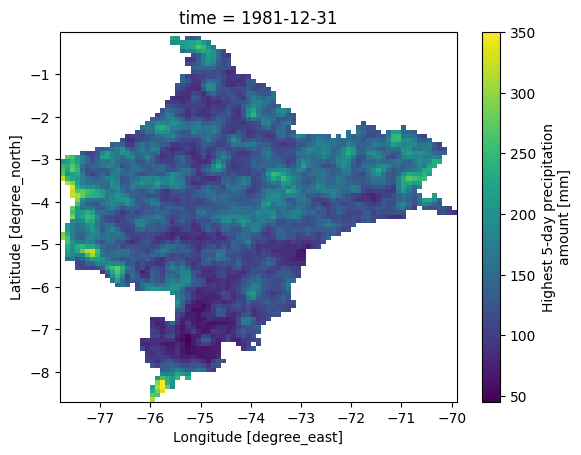

In [ ]:
RX5day = xclim.indicators.icclim.RX5day(PISCOp_crop_masked.Prec,freq='Y',ds=None)
RX5day.isel(time=0).plot()

###SDII (Simple daily intensity index)

/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


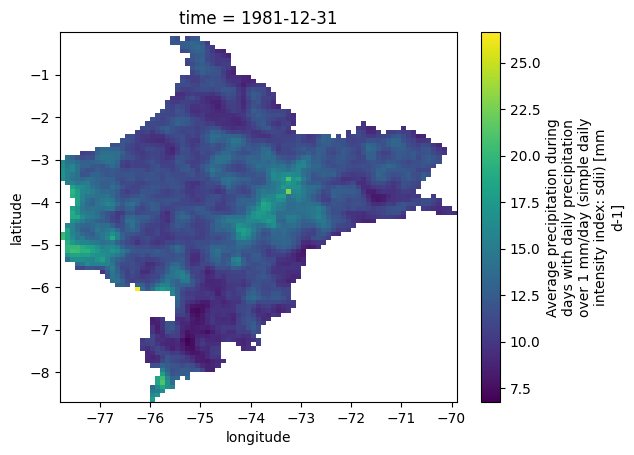

In [ ]:
SDII = xclim.indicators.icclim.SDII(PISCOp_crop_masked.Prec, freq='Y', op='>=', ds=None)
SDII.isel(time=0).plot()

###PRCPTOT (Total precipitation)

/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


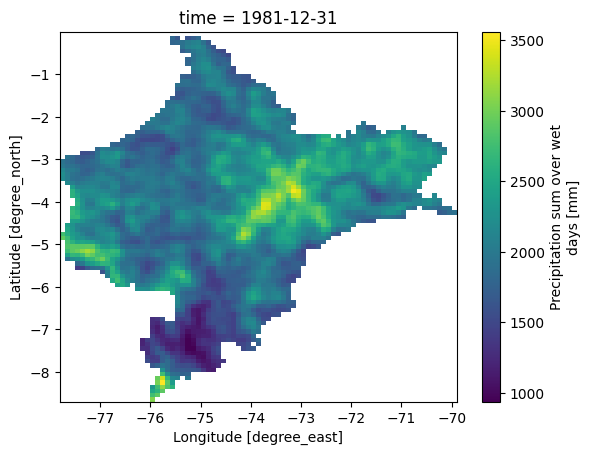

In [ ]:
PRCPTOT = xclim.indicators.icclim.PRCPTOT(PISCOp_crop_masked.Prec, freq='Y', ds=None)
PRCPTOT.isel(time=0).plot()

In [ ]:
def mk_slope(y):
  if np.all(np.isnan(y)) == True:
    res = np.nan
  else:
    res = mk.original_test(y)[7]
  return res

def mk_pvalue(y):
  if np.all(np.isnan(y)) == True:
    res = np.nan
  else:
    res = mk.original_test(y)[2]
  return res

###R1mm

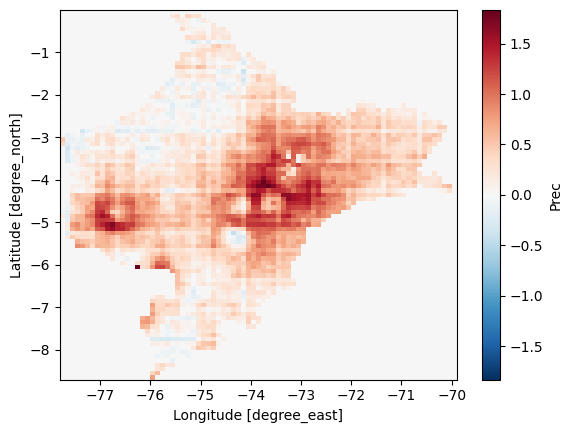

In [ ]:
sen_slope_R1mm = xr.apply_ufunc(mk_slope,
                                   R1mm(PISCOp_crop_masked.Prec),
                                   input_core_dims=[["time"]],
                                   vectorize=True)
sen_slope_R1mm.plot()

###CWD

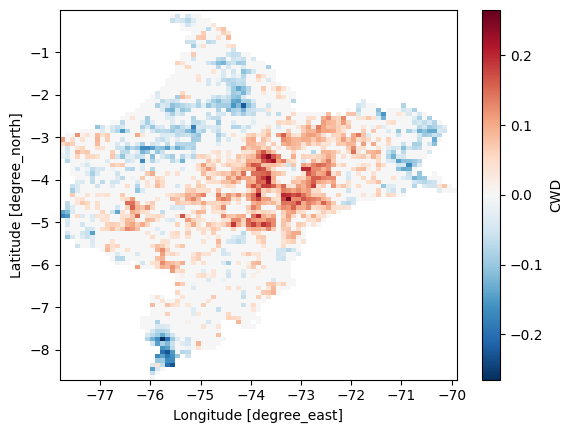

In [ ]:
sen_slope_CWD = xr.apply_ufunc(mk_slope, CWD,
                                   input_core_dims=[["time"]],
                                   vectorize=True)
sen_slope_CWD.plot()

###CWDm

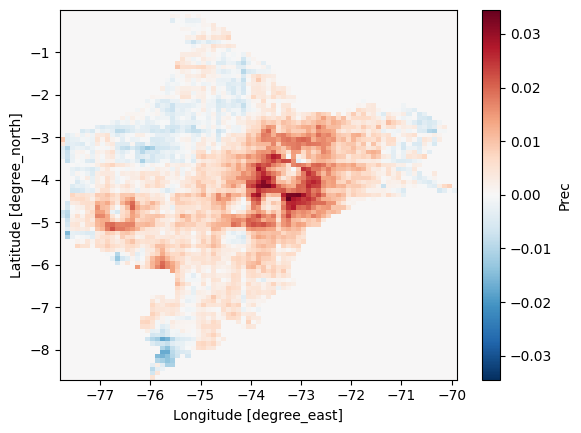

In [ ]:
sen_slope_CWDm = xr.apply_ufunc(mk_slope,
                                   CWDm,
                                   input_core_dims=[["time"]],
                                   vectorize=True)
sen_slope_CWDm.plot()

###CDD

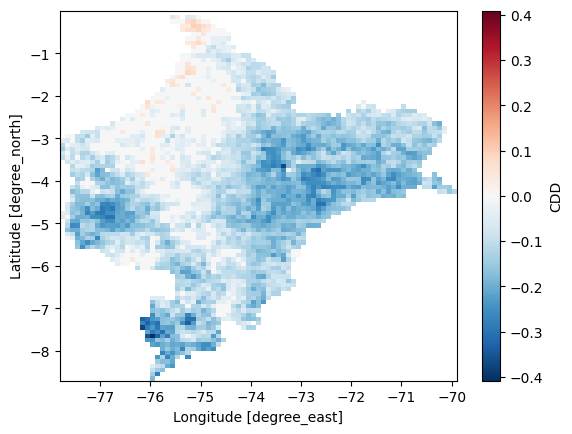

In [ ]:
sen_slope_CDD = xr.apply_ufunc(mk_slope,
                                   CDD,
                                   input_core_dims=[["time"]],
                                   vectorize=True)
sen_slope_CDD.plot()

###CDDm

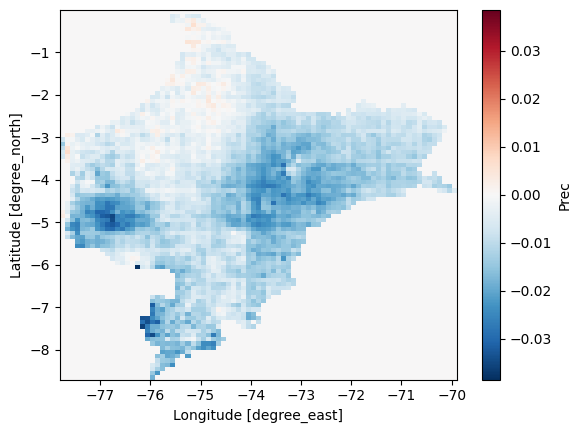

In [ ]:
sen_slope_CDDm = xr.apply_ufunc(mk_slope,
                                   CDDm,
                                   input_core_dims=[["time"]],
                                   vectorize=True)
sen_slope_CDDm.plot()

###R95p

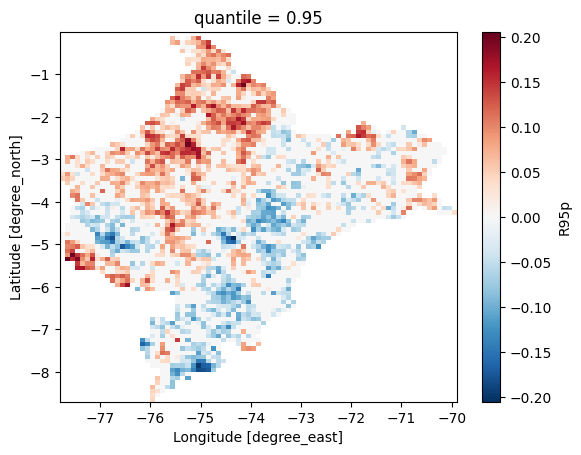

In [ ]:
sen_slope_R95p = xr.apply_ufunc(mk_slope,
                                   R95p,
                                   input_core_dims=[["time"]],
                                   vectorize=True)
sen_slope_R95p.plot()

###R95pTOT

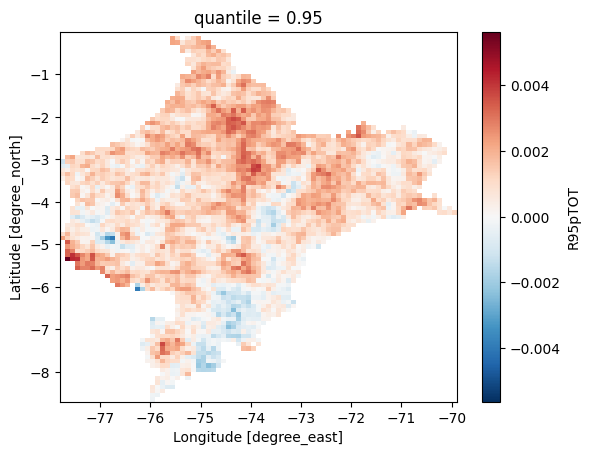

In [ ]:
sen_slope_R95pTOT = xr.apply_ufunc(mk_slope,
                                   R95pTOT,
                                   input_core_dims=[["time"]],
                                   vectorize=True)
sen_slope_R95pTOT.plot()

###Rx1day

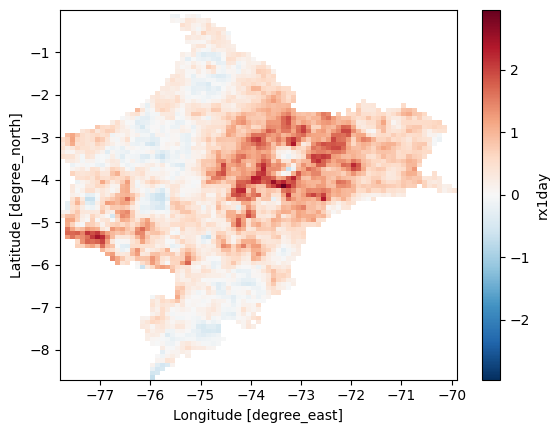

In [ ]:
sen_slope_RX1day = xr.apply_ufunc(mk_slope,
                                   RX1day,
                                   input_core_dims=[["time"]],
                                   vectorize=True)
sen_slope_RX1day.plot()

###Rx5day

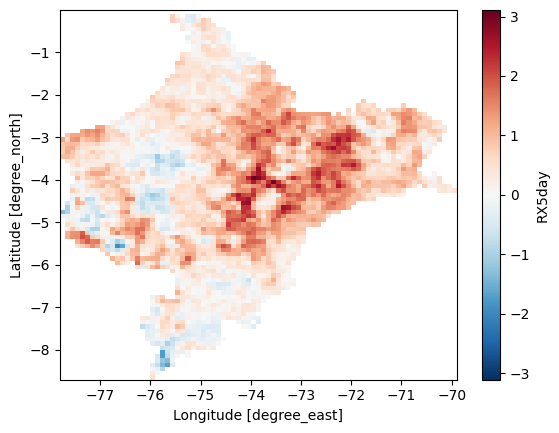

In [ ]:
sen_slope_RX5day = xr.apply_ufunc(mk_slope,
                                   RX5day,
                                   input_core_dims=[["time"]],
                                   vectorize=True)
sen_slope_RX5day.plot()

###SDII

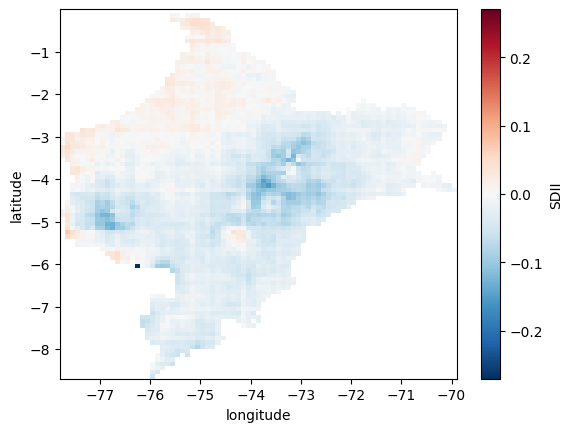

In [ ]:
sen_slope_SDII = xr.apply_ufunc(mk_slope,
                                   SDII,
                                   input_core_dims=[["time"]],
                                   vectorize=True)
sen_slope_SDII.plot()

###PRCPTOT

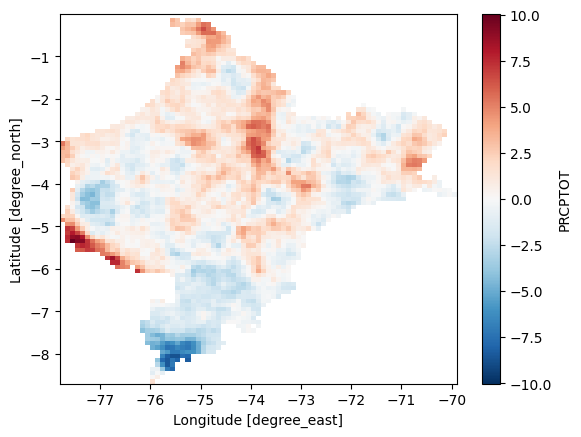

In [ ]:
sen_slope_PRCPTOT = xr.apply_ufunc(mk_slope,
                                   PRCPTOT,
                                   input_core_dims=[["time"]],
                                   vectorize=True)
sen_slope_PRCPTOT.plot()

##GRÁFICA FINAL

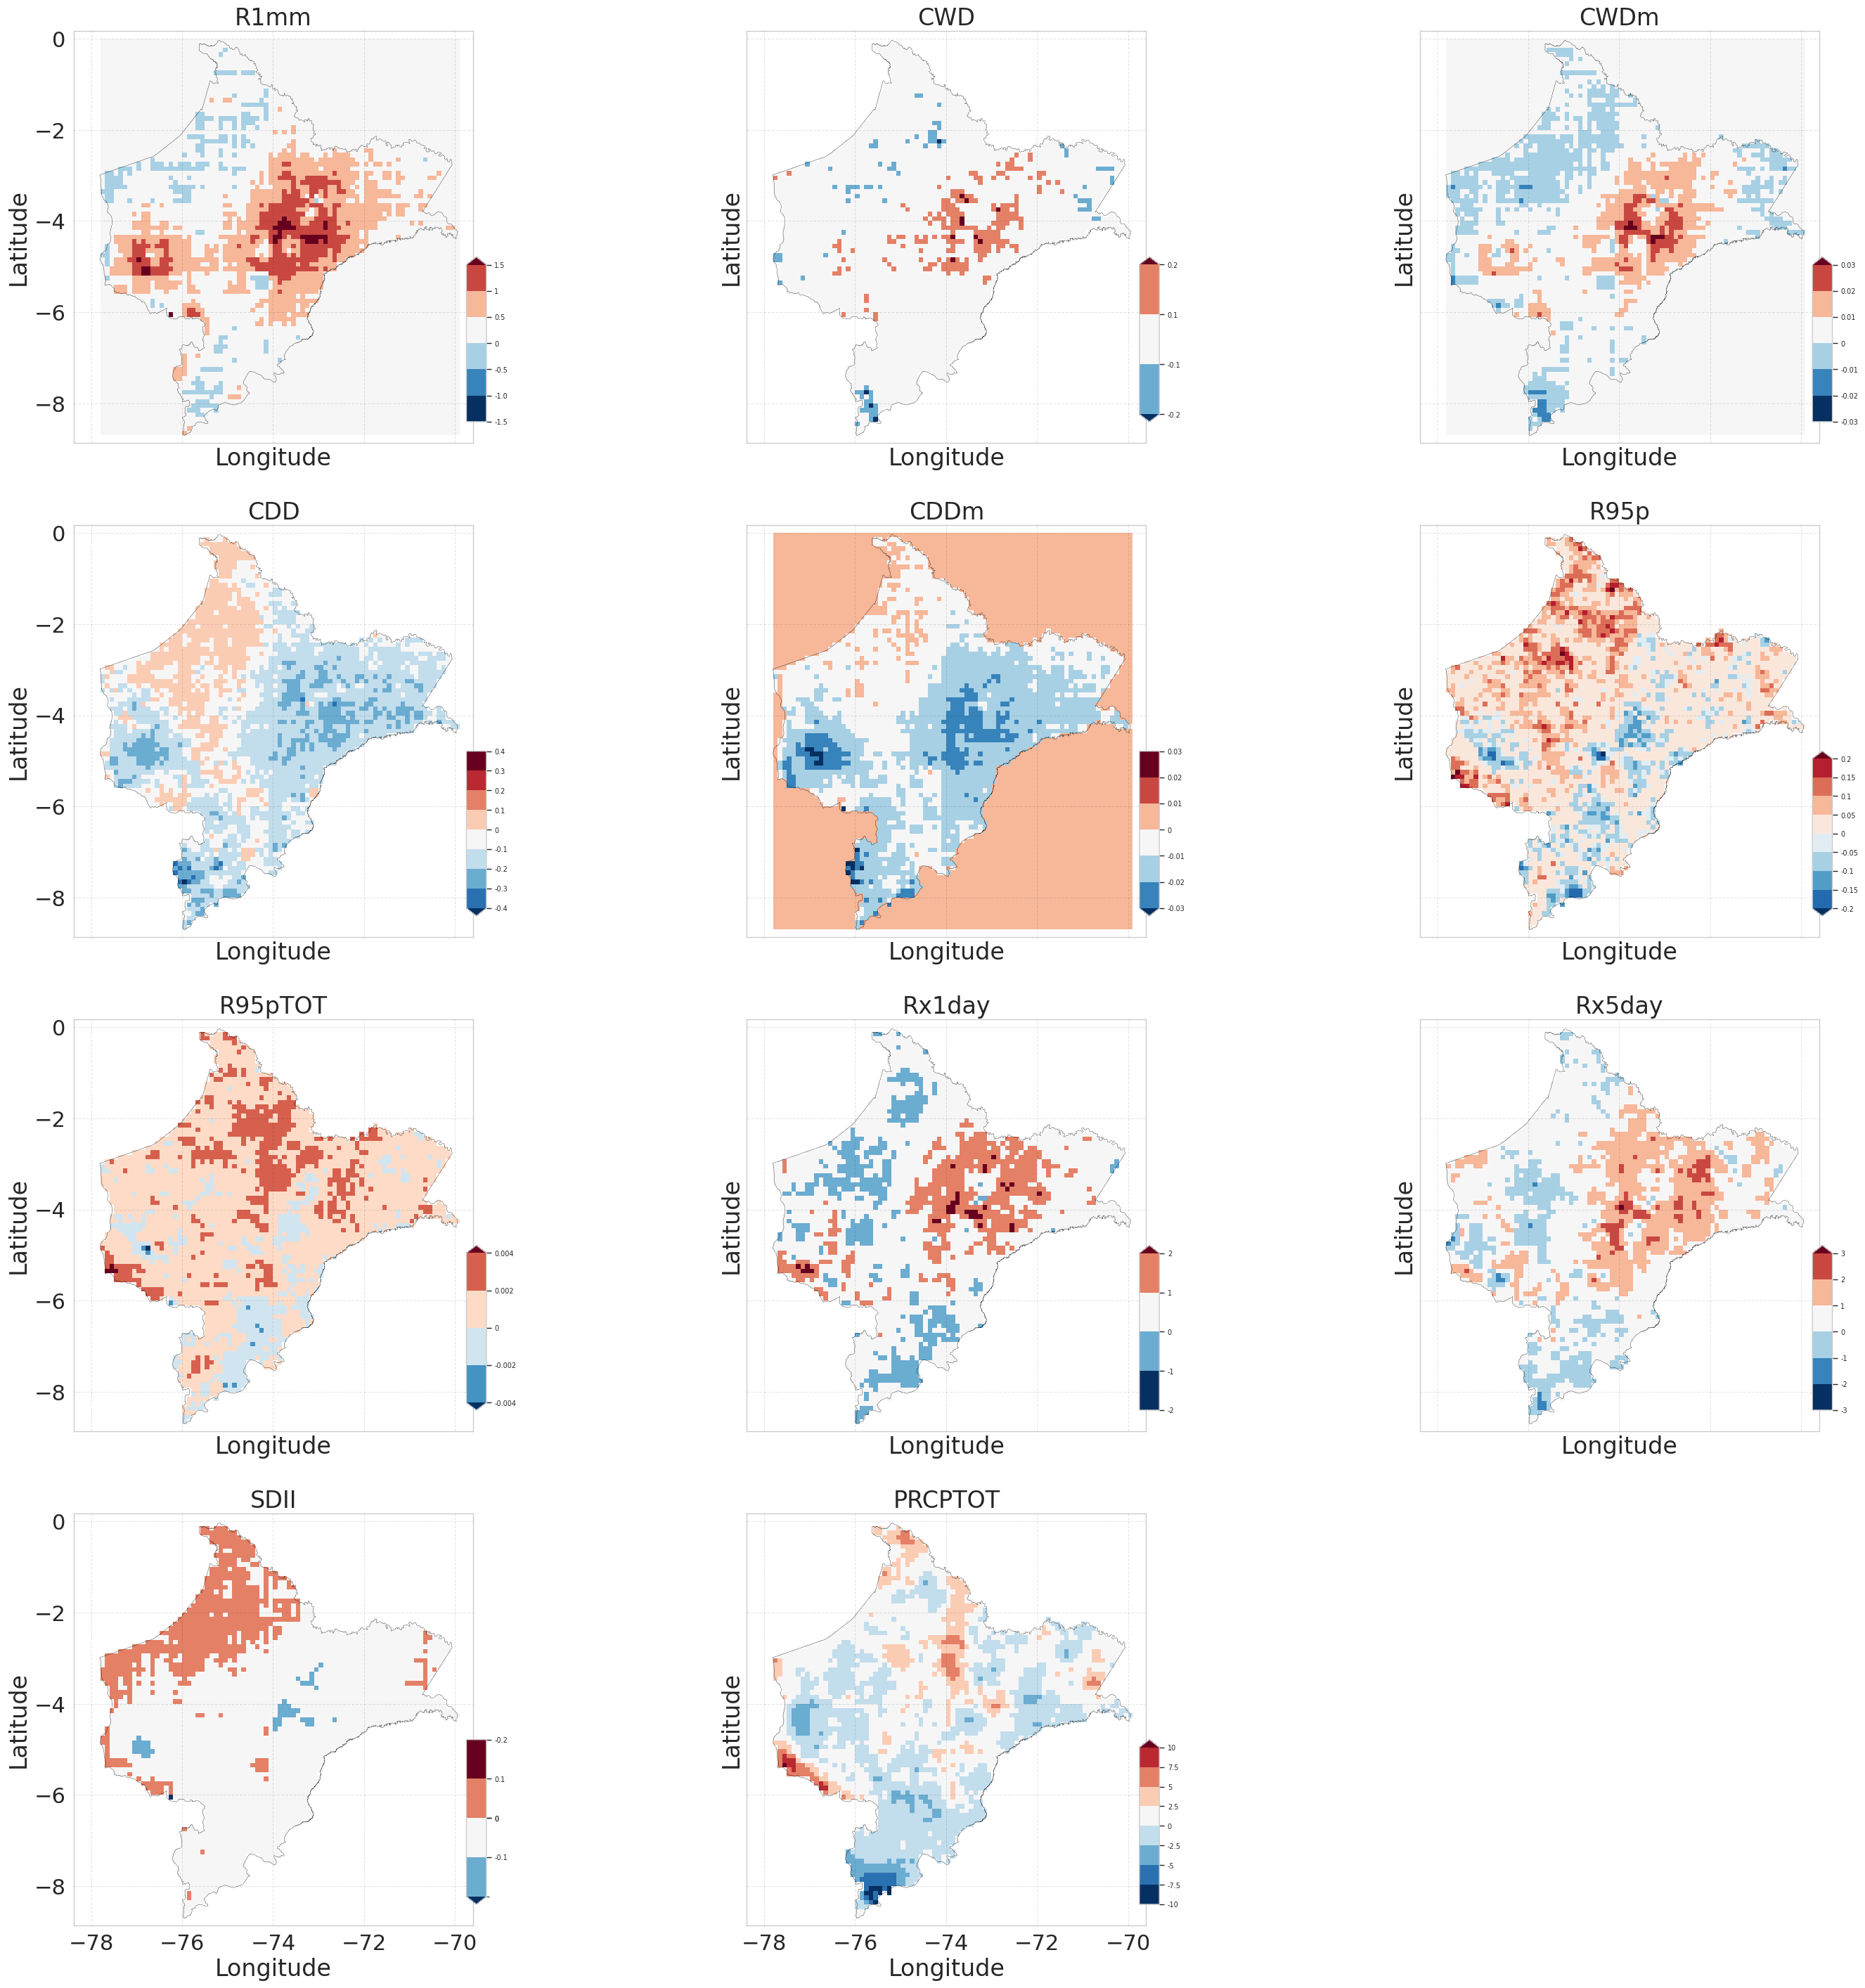

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 2})
fig, ((ax, ax2, ax3), (ax4, ax5, ax6),(ax7,ax8,ax9),(ax10,ax11,ax12)) = plt.subplots(4, 3, figsize=(35,35), dpi = 100, sharex=True, sharey=True)


#plot figure 1
ax.set_axisbelow(False)
im = sen_slope_R1mm.plot(ax = ax, levels = [-1.5,-1.,-0.5,0,0.5,1,1.5], add_colorbar=False)
axin = inset_axes(ax, width='5%',
                  height='40%', loc = 'lower right',
                  bbox_to_anchor = (0.06, 0.025, 1 ,1), bbox_transform = ax.transAxes)
#localizando colorbar
cb = plt.colorbar(im, cax=axin,
                  orientation = "vertical",
                  aspect = 4, ticks = [-1.5,-1.,-0.5,0,0.5,1,1.5])
cb.ax.set_yticklabels([-1.5,-1.,-0.5,0,0.5,1,1.5], fontdict={"fontsize":7})


#shapes
loreto.geometry.boundary.plot(ax = ax, edgecolor = "black", linewidth = .25)

#plot features
ax.set_ylim(-8.86, 0.17)
ax.set_xlim(-78.38, -69.6)
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
ax.set_title('R1mm')
ax.grid(True, linestyle='--', color = "black", alpha = 0.1)


#plot figure 2
ax2.set_axisbelow(False)
im = sen_slope_CWD.plot(ax = ax2, levels = [-0.2,-0.1-0,0.1,0.2], add_colorbar=False)
axin = inset_axes(ax, width='5%',
                  height='40%', loc = 'lower right',
                  bbox_to_anchor = (0.06, 0.025, 1 ,1), bbox_transform = ax2.transAxes)
#colorbar
cb = plt.colorbar(im, cax=axin,
                  orientation = "vertical",
                  aspect = 4, ticks = [-0.2,-0.1-0,0.1,0.2])
cb.ax.set_yticklabels([-0.2,-0.1-0,0.1,0.2], fontdict={"fontsize":7})

#shapes
loreto.geometry.boundary.plot(ax = ax2, edgecolor = "black", linewidth = .25)

#plot features
ax2.set_ylim(-8.86, 0.17)
ax2.set_xlim(-78.38, -69.6)
ax2.set_ylabel("Latitude")
ax2.set_xlabel("Longitude")
ax2.set_title('CWD')
ax2.grid(True, linestyle='--', color = "black", alpha = 0.1)


#plot figure 3
ax3.set_axisbelow(False)
im = sen_slope_CWDm.plot(ax = ax3, levels = [-0.03,-0.02,-0.01,0,0.01,0.02,0.03], add_colorbar=False)
axin = inset_axes(ax, width='5%',
                  height='40%', loc = 'lower right',
                  bbox_to_anchor = (0.06, 0.025, 1 ,1), bbox_transform = ax3.transAxes)
#colorbar
cb = plt.colorbar(im, cax=axin,
                  orientation = "vertical",
                  aspect = 4, ticks = [-0.03,-0.02,-0.01,0,0.01,0.02,0.03])
cb.ax.set_yticklabels([-0.03,-0.02,-0.01,0,0.01,0.02,0.03], fontdict={"fontsize":7})

#shapefiles
loreto.geometry.boundary.plot(ax = ax3, edgecolor = "black", linewidth = .25)

#plot features
ax3.set_ylim(-8.86, 0.17)
ax3.set_xlim(-78.38, -69.6)
ax3.set_ylabel("Latitude")
ax3.set_xlabel("Longitude")
ax3.set_title("CWDm")
ax3.grid(True, linestyle='--', color = "black", alpha = 0.1)


#Figure 4
ax4.set_axisbelow(False)
im = sen_slope_CDD.plot(ax = ax4, levels = [-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4], add_colorbar=False)
axin = inset_axes(ax4, width='5%',
                  height='40%', loc = 'lower right',
                  bbox_to_anchor = (0.06, 0.025, 1 ,1), bbox_transform = ax4.transAxes)
#colorbar
cb = plt.colorbar(im, cax=axin,
                  orientation = "vertical", aspect = 4,
                  ticks = [-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
cb.ax.set_yticklabels([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4], fontdict={"fontsize":7})

#shapefiles
loreto.geometry.boundary.plot(ax = ax4, edgecolor = "black", linewidth = .25)

#plot features
ax4.set_ylim(-8.86, 0.17)
ax4.set_xlim(-78.38, -69.6)
ax4.set_ylabel("Latitude")
ax4.set_xlabel("Longitude")
ax4.set_title("CDD")
ax4.grid(True, linestyle='--', color = "black", alpha = 0.1)

#plot figure 5
ax5.set_axisbelow(False)
im = sen_slope_CDDm.plot(ax = ax5, levels = [-0.03,-0.02,-0.01,0,0.01,0.02,0.03], add_colorbar=False)
axin = inset_axes(ax5, width='5%', height='40%', loc = 'lower right', bbox_to_anchor = (0.06, 0.025, 1 ,1), bbox_transform = ax5.transAxes)
#colorbar
cb = plt.colorbar(im, cax=axin, orientation = "vertical", aspect = 4, ticks = [-0.03,-0.02,-0.01,0,0.01,0.02,0.03])
cb.ax.set_yticklabels([-0.03,-0.02,-0.01,0,0.01,0.02,0.03], fontdict={"fontsize":7})

#shapes
loreto.geometry.boundary.plot(ax = ax5, edgecolor = "black", linewidth = .25)

#plot features
ax5.set_ylim(-8.86, 0.17)
ax5.set_xlim(-78.38, -69.6)
ax5.set_ylabel("Latitude")
ax5.set_xlabel("Longitude")
ax5.set_title("CDDm")
ax5.grid(True, linestyle='--', color = "black", alpha = 0.1)


#plot figure 6
ax6.set_axisbelow(False)
im = sen_slope_R95p.plot(ax = ax6, levels = [-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2], add_colorbar=False)
#localizando colorbar
axin = inset_axes(ax6, width='5%', height='40%', loc = 'lower right', bbox_to_anchor = (0.06, 0.025, 1 ,1), bbox_transform = ax6.transAxes)
#colorbar
cb = plt.colorbar(im, cax=axin, orientation = "vertical", aspect = 4, ticks = [-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2])
cb.ax.set_yticklabels([-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2], fontdict={"fontsize":7})

#shapes
loreto.geometry.boundary.plot(ax = ax6, edgecolor = "black", linewidth = .25)

#plot features
ax6.set_ylim(-8.86, 0.17)
ax6.set_xlim(-78.38, -69.6)
ax6.set_ylabel("Latitude")
ax6.set_xlabel("Longitude")
ax6.set_title("R95p")
ax6.grid(True, linestyle='--', color = "black", alpha = 0.1)

#plot figure 7
ax7.set_axisbelow(False)
im = sen_slope_R95pTOT.plot(ax = ax7, levels = [-0.004,-0.002,0,0.002,0.004], add_colorbar=False)
axin = inset_axes(ax7, width='5%', height='40%', loc = 'lower right', bbox_to_anchor = (0.06, 0.025, 1 ,1), bbox_transform = ax7.transAxes)
#colorbar
cb = plt.colorbar(im, cax=axin, orientation = "vertical", aspect = 4, ticks = [-0.004,-0.002,0,0.002,0.004])
cb.ax.set_yticklabels([-0.004,-0.002,0,0.002,0.004], fontdict={"fontsize":7})

#shapes
loreto.geometry.boundary.plot(ax = ax7, edgecolor = "black", linewidth = .25)

#plot features
ax7.set_ylim(-8.86, 0.17)
ax7.set_xlim(-78.38, -69.6)
ax7.set_ylabel("Latitude")
ax7.set_xlabel("Longitude")
ax7.set_title("R95pTOT")
ax7.grid(True, linestyle='--', color = "black", alpha = 0.1)


#plot figure 8
ax8.set_axisbelow(False)
im = sen_slope_RX1day.plot(ax = ax8, levels = [-2,-1,0,1,2], add_colorbar=False)
axin = inset_axes(ax8, width='5%', height='40%', loc = 'lower right', bbox_to_anchor = (0.06, 0.025, 1 ,1), bbox_transform = ax8.transAxes)
#colorbar
cb = plt.colorbar(im, cax=axin, orientation = "vertical", aspect = 4, ticks = [-2,-1,0,1,2])
cb.ax.set_yticklabels([-2,-1,0,1,2], fontdict={"fontsize":7})

#shapes
loreto.geometry.boundary.plot(ax = ax8, edgecolor = "black", linewidth = .25)

#plot features
ax8.set_ylim(-8.86, 0.17)
ax8.set_xlim(-78.38, -69.6)
ax8.set_ylabel("Latitude")
ax8.set_xlabel("Longitude")
ax8.set_title("Rx1day")
ax8.grid(True, linestyle='--', color = "black", alpha = 0.1)

#plot figure 9
ax9.set_axisbelow(False)
im = sen_slope_RX5day.plot(ax = ax9, levels = [-3,-2,-1,0,1,2,3], add_colorbar=False)
axin = inset_axes(ax9, width='5%', height='40%', loc = 'lower right', bbox_to_anchor = (0.06, 0.025, 1 ,1), bbox_transform = ax9.transAxes)
#colorbar
cb = plt.colorbar(im, cax=axin, orientation = "vertical", aspect = 4, ticks = [-3,-2,-1,0,1,2,3])
cb.ax.set_yticklabels([-3,-2,-1,0,1,2,3], fontdict={"fontsize":7})

#shapes
loreto.geometry.boundary.plot(ax = ax9, edgecolor = "black", linewidth = .25)

#plot features
ax9.set_ylim(-8.86, 0.17)
ax9.set_xlim(-78.38, -69.6)
ax9.set_ylabel("Latitude")
ax9.set_xlabel("Longitude")
ax9.set_title("Rx5day")
ax9.grid(True, linestyle='--', color = "black", alpha = 0.1)

#plot figure 10
ax10.set_axisbelow(False)
im = sen_slope_SDII.plot(ax = ax10, levels = [-0.2,-0.1,0,0.1,0.2], add_colorbar=False)
axin = inset_axes(ax10, width='5%', height='40%', loc = 'lower right', bbox_to_anchor = (0.06, 0.025, 1 ,1), bbox_transform = ax10.transAxes)
#colorbar
cb = plt.colorbar(im, cax=axin, orientation = "vertical", aspect = 4, ticks = [--0.2,-0.1,0,0.1,0,2])
cb.ax.set_yticklabels([-0.2,-0.1,0,0.1,0,2], fontdict={"fontsize":7})

#shapes
loreto.geometry.boundary.plot(ax = ax10, edgecolor = "black", linewidth = .25)

#plot features
ax10.set_ylim(-8.86, 0.17)
ax10.set_xlim(-78.38, -69.6)
ax10.set_ylabel("Latitude")
ax10.set_xlabel("Longitude")
ax10.set_title("SDII")
ax10.grid(True, linestyle='--', color = "black", alpha = 0.1)

#plot figure 11
ax11.set_axisbelow(False)
im = sen_slope_PRCPTOT.plot(ax = ax11, levels = [-10,-7.5,-5,-2.5,0,2.5,5,7.5,10], add_colorbar=False)
axin = inset_axes(ax11, width='5%', height='40%', loc = 'lower right', bbox_to_anchor = (0.06, 0.025, 1 ,1), bbox_transform = ax11.transAxes)
#colorbar
cb = plt.colorbar(im, cax=axin, orientation = "vertical", aspect = 4, ticks = [-10,-7.5,-5,-2.5,0,2.5,5,7.5,10])
cb.ax.set_yticklabels([-10,-7.5,-5,-2.5,0,2.5,5,7.5,10], fontdict={"fontsize":7})

#shapes
loreto.geometry.boundary.plot(ax = ax11, edgecolor = "black", linewidth = .25)

#plot features
ax11.set_ylim(-8.86, 0.17)
ax11.set_xlim(-78.38, -69.6)
ax11.set_ylabel("Latitude")
ax11.set_xlabel("Longitude")
ax11.set_title("PRCPTOT")
ax11.grid(True, linestyle='--', color = "black", alpha = 0.1)

fig.delaxes(ax12)

#save plot
#plt.savefig("wglc_cc_pp_M_1_6.png")
plt.show()

#CORRELACIÓN DE SPEARMAN ENTRE LOS ÍNDICES OCÉANO ATMOSFÉRICOS Y PRECIPITACIÓN EXTREMA

In [ ]:
def Spearman_sig(x, y, alpha = 0.05):
    from scipy.stats import spearmanr
    r,p = spearmanr(x,y)
    if p <= alpha:  sig = 1
    elif p > alpha: sig = 0
    else:           sig = np.nan
    return sig

##PDO

###PDO - R1mm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


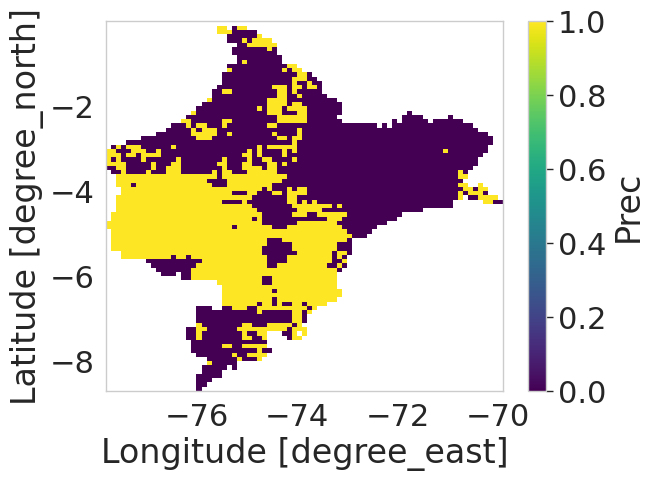

In [ ]:
Spearman_indicePDO_R1mm = xr.apply_ufunc(Spearman_sig,
                                        R1mm(PISCOp_crop_masked.Prec),
                                        np.array(PDO_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indicePDO_R1mm.plot()

In [ ]:
PDO_R1mm = Spearman_indicePDO_R1mm.sum()/Spearman_indicePDO_R1mm.count()*100
PDO_R1mm

<xarray.DataArray 'Prec' ()>
array(42.01377501)

###PDO - CWD

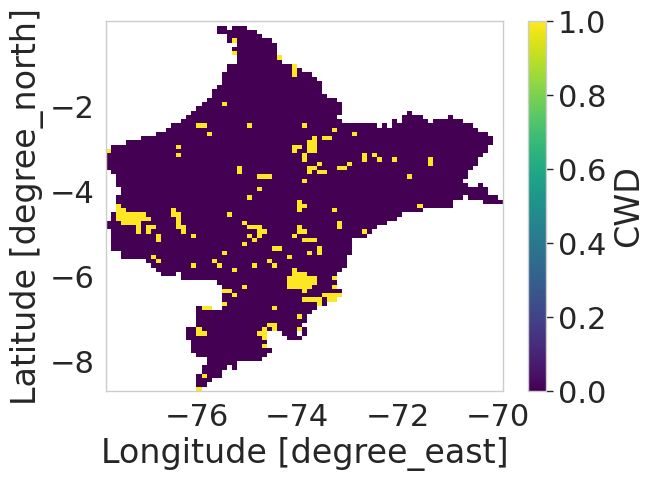

In [ ]:
Spearman_indicePDO_CWD = xr.apply_ufunc(Spearman_sig,
                                        CWD,
                                        np.array(PDO_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indicePDO_CWD.plot()

In [ ]:
PDO_CWD = Spearman_indicePDO_CWD.sum()/Spearman_indicePDO_CWD.count()*100
PDO_CWD

<xarray.DataArray 'CWD' ()>
array(6.32994424)

###PDO - CWDm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


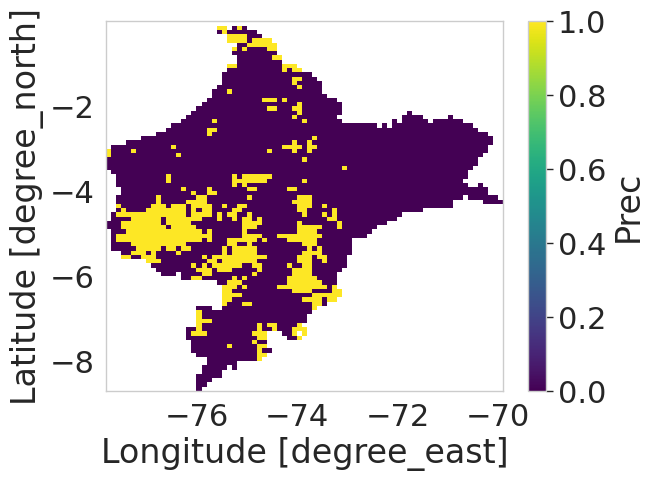

In [ ]:
Spearman_indicePDO_CWDm = xr.apply_ufunc(Spearman_sig,
                                        CWDm,
                                        np.array(PDO_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indicePDO_CWDm.plot()

In [ ]:
PDO_CWDm = Spearman_indicePDO_CWDm.sum()/Spearman_indicePDO_CWDm.count()*100
PDO_CWDm

<xarray.DataArray 'Prec' ()>
array(17.90751066)

###PDO - CDD

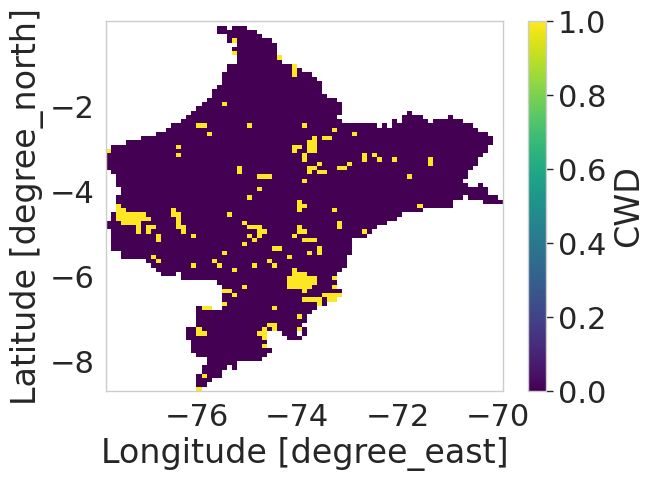

In [ ]:
Spearman_indicePDO_CDD = xr.apply_ufunc(Spearman_sig,
                                        CWD,
                                        np.array(PDO_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indicePDO_CDD.plot()

In [ ]:
PDO_CDD = Spearman_indicePDO_CDD.sum()/Spearman_indicePDO_CDD.count()*100
PDO_CDD

<xarray.DataArray 'CWD' ()>
array(6.32994424)

###PDO - CDDm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


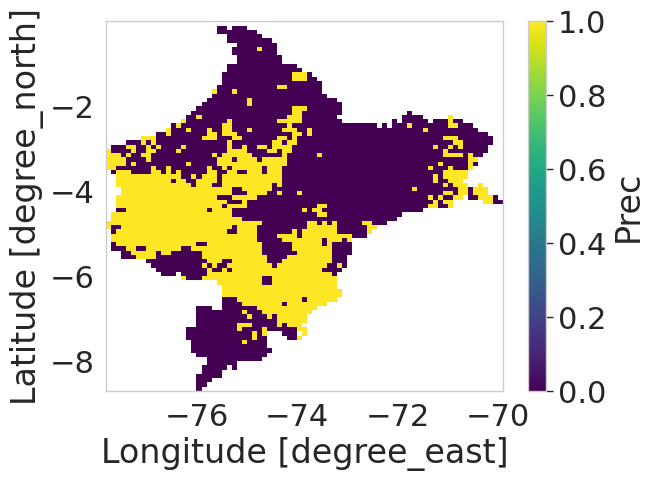

In [ ]:
Spearman_indicePDO_CDDm = xr.apply_ufunc(Spearman_sig,
                                        CDDm,
                                        np.array(PDO_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indicePDO_CDDm.plot()

In [ ]:
PDO_CDDm = Spearman_indicePDO_CDDm.sum()/Spearman_indicePDO_CDDm.count()*100
PDO_CDDm

<xarray.DataArray 'Prec' ()>
array(37.75008199)

###PDO - R95p

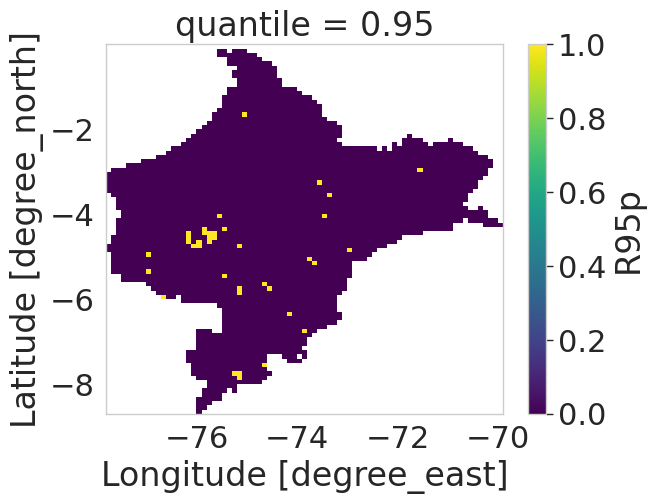

In [ ]:
Spearman_indicePDO_R95p = xr.apply_ufunc(Spearman_sig,
                                        R95p,
                                        np.array(PDO_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indicePDO_R95p.plot()

In [ ]:
PDO_R95p = Spearman_indicePDO_R95p.sum()/Spearman_indicePDO_R95p.count()*100
PDO_R95p

<xarray.DataArray 'R95p' ()>
array(1.24631027)
Coordinates:
    quantile  float64 0.95

###PDO - R95pTOT

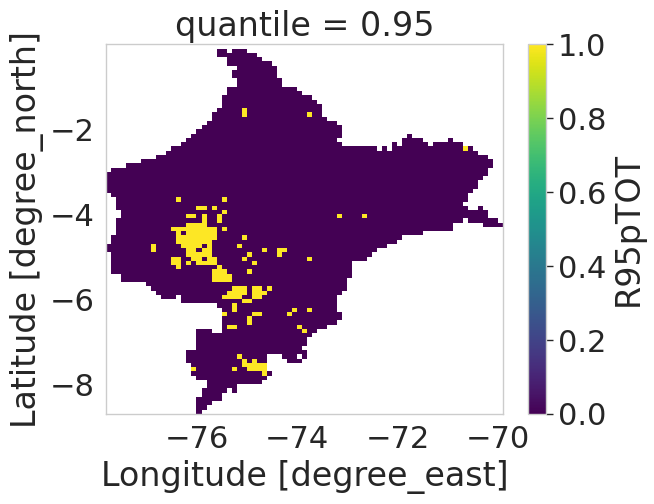

In [ ]:
Spearman_indicePDO_R95pTOT = xr.apply_ufunc(Spearman_sig,
                                        R95pTOT,
                                        np.array(PDO_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indicePDO_R95pTOT.plot()

In [ ]:
PDO_R95pTOT = Spearman_indicePDO_R95pTOT.sum()/Spearman_indicePDO_R95pTOT.count()*100
PDO_R95pTOT

<xarray.DataArray 'R95pTOT' ()>
array(5.14922926)
Coordinates:
    quantile  float64 0.95

###PDO - Rx1day

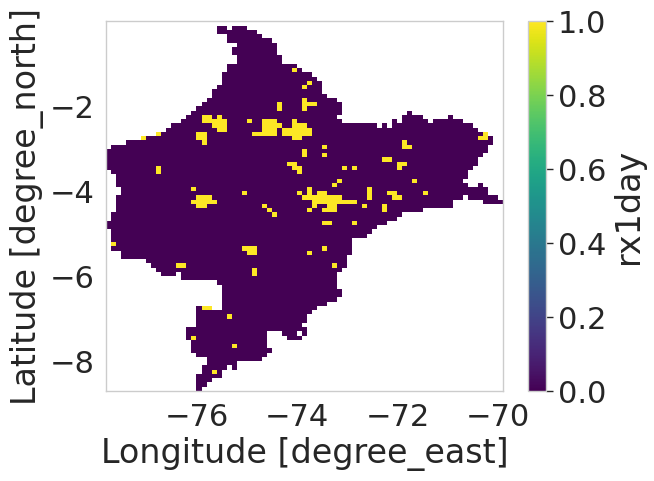

In [ ]:
Spearman_indicePDO_RX1day = xr.apply_ufunc(Spearman_sig,
                                        RX1day,
                                        np.array(PDO_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indicePDO_RX1day.plot()

In [ ]:
PDO_RX1day = Spearman_indicePDO_RX1day.sum()/Spearman_indicePDO_RX1day.count()*100
PDO_RX1day

<xarray.DataArray 'rx1day' ()>
array(5.51000328)

###PDO - Rx5day

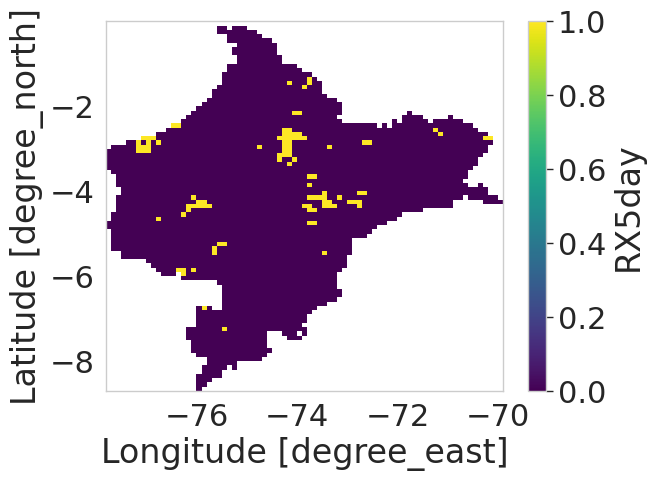

In [ ]:
Spearman_indicePDO_RX5day = xr.apply_ufunc(Spearman_sig,
                                        RX5day,
                                        np.array(PDO_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indicePDO_RX5day.plot()

In [ ]:
PDO_RX5day = Spearman_indicePDO_RX5day.sum()/Spearman_indicePDO_RX5day.count()*100
PDO_RX5day

<xarray.DataArray 'RX5day' ()>
array(3.27976386)

###PDO - SDII

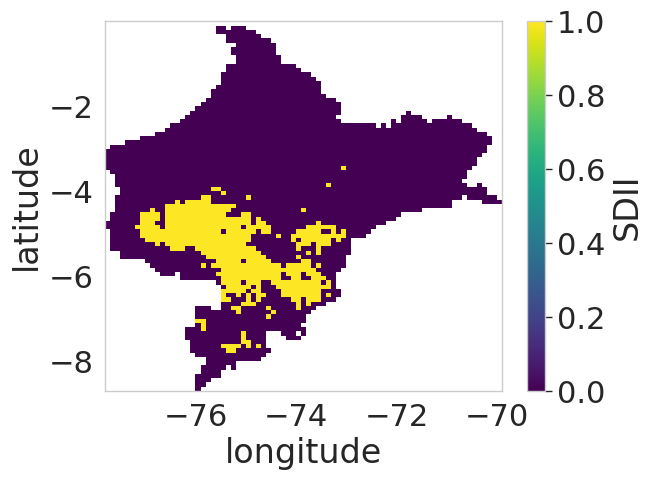

In [ ]:
Spearman_indicePDO_SDII = xr.apply_ufunc(Spearman_sig,
                                        SDII,
                                        np.array(PDO_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indicePDO_SDII.plot()

In [ ]:
PDO_SDII = Spearman_indicePDO_SDII.sum()/Spearman_indicePDO_SDII.count()*100
PDO_SDII

<xarray.DataArray 'SDII' ()>
array(15.97244998)

###PDO - PRCPTOT

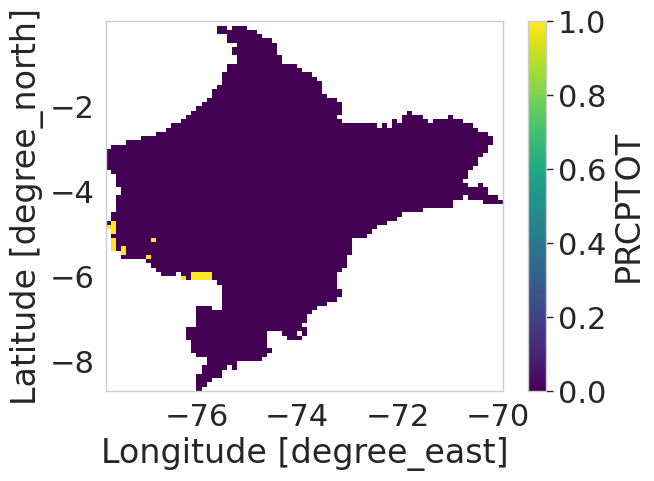

In [ ]:
Spearman_indicePDO_PRCPTOT = xr.apply_ufunc(Spearman_sig,
                                        PRCPTOT,
                                        np.array(PDO_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indicePDO_PRCPTOT.plot()

In [ ]:
PDO_PRCPTOT = Spearman_indicePDO_PRCPTOT.sum()/Spearman_indicePDO_PRCPTOT.count()*100
PDO_PRCPTOT

<xarray.DataArray 'PRCPTOT' ()>
array(0.65595277)

##INDEX E

###Index E - R1mm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


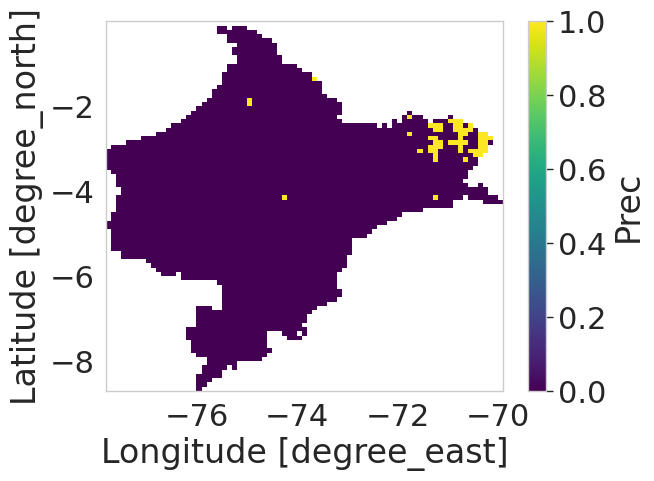

In [ ]:
Spearman_indiceE_R1mm = xr.apply_ufunc(Spearman_sig,
                                        R1mm(PISCOp_crop_masked.Prec),
                                        np.array(tabla_E).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceE_R1mm.plot()

In [ ]:
E_R1mm = Spearman_indiceE_R1mm.sum()/Spearman_indiceE_R1mm.count()*100
E_R1mm

<xarray.DataArray 'Prec' ()>
array(1.93506068)

###Index E - CWD

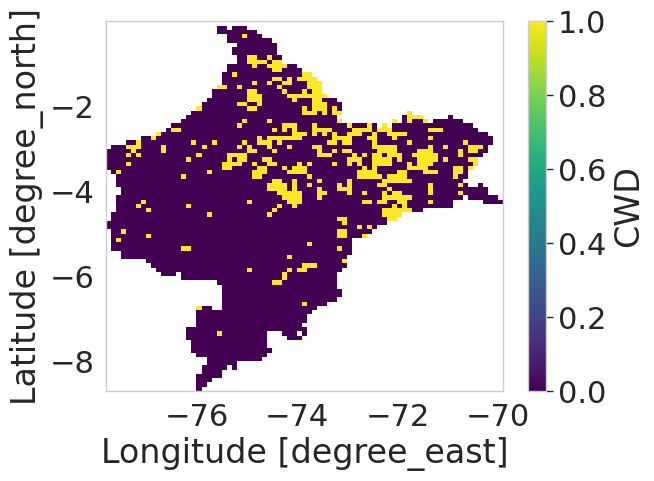

In [ ]:
Spearman_indiceE_CWD = xr.apply_ufunc(Spearman_sig,
                                        CWD,
                                        np.array(tabla_E).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceE_CWD.plot()

In [ ]:
E_CWD = Spearman_indiceE_CWD.sum()/Spearman_indiceE_CWD.count()*100
E_CWD

<xarray.DataArray 'CWD' ()>
array(14.791735)

###Index E - CWDm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


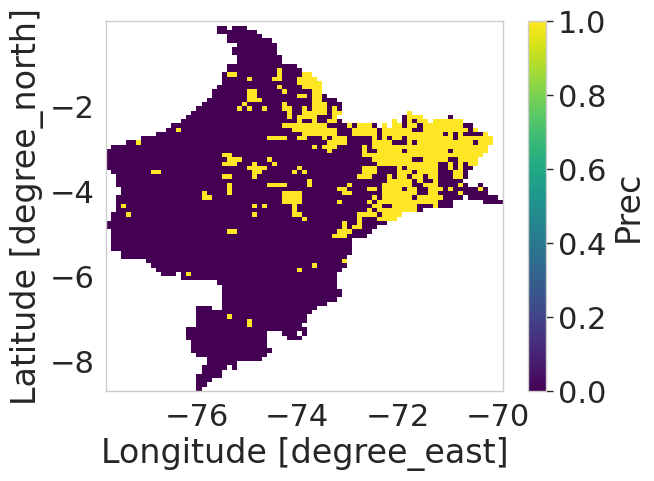

In [ ]:
Spearman_indiceE_CWDm = xr.apply_ufunc(Spearman_sig,
                                        CWDm,
                                        np.array(tabla_E).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceE_CWDm.plot()

In [ ]:
E_CWDm = Spearman_indiceE_CWDm.sum()/Spearman_indiceE_CWDm.count()*100
E_CWDm

<xarray.DataArray 'Prec' ()>
array(17.9403083)

###Index E - CDD

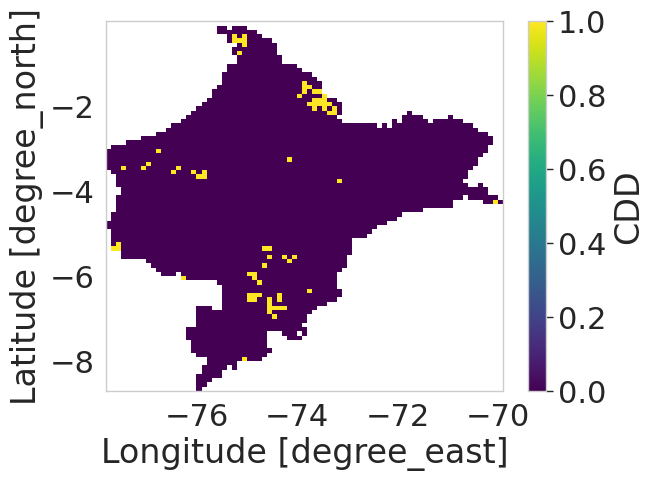

In [ ]:
Spearman_indiceE_CDD = xr.apply_ufunc(Spearman_sig,
                                        CDD,
                                        np.array(tabla_E).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceE_CDD.plot()

In [ ]:
E_CDD = Spearman_indiceE_CDD.sum()/Spearman_indiceE_CDD.count()*100
E_CDD

<xarray.DataArray 'CDD' ()>
array(2.39422762)

###Index E - CDDm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


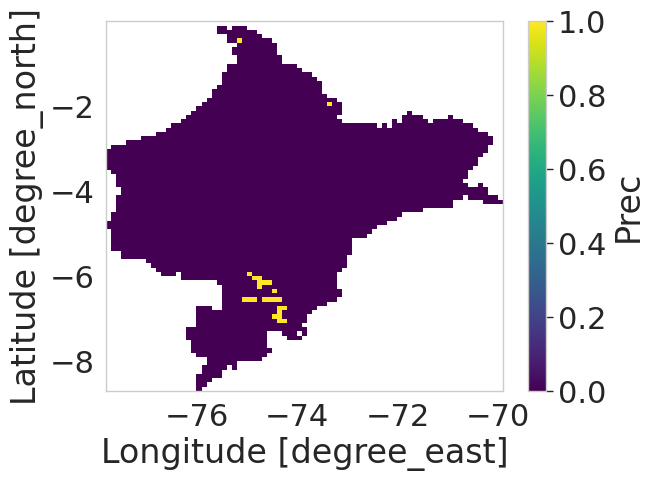

In [ ]:
Spearman_indiceE_CDDm = xr.apply_ufunc(Spearman_sig,
                                        CDDm,
                                        np.array(tabla_E).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceE_CDDm.plot()

In [ ]:
E_CDDm = Spearman_indiceE_CDDm.sum()/Spearman_indiceE_CDDm.count()*100
E_CDDm

<xarray.DataArray 'Prec' ()>
array(0.78714333)

###Index E - R95p

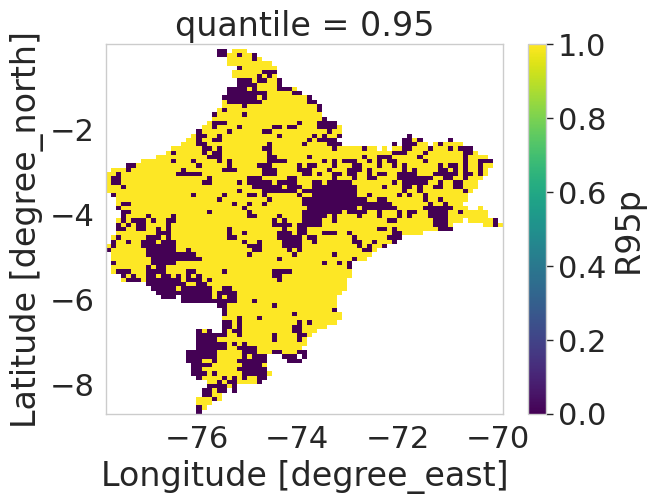

In [ ]:
Spearman_indiceE_R95p = xr.apply_ufunc(Spearman_sig,
                                        R95p,
                                        np.array(tabla_E).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceE_R95p.plot()

In [ ]:
E_R95p = Spearman_indiceE_R95p.sum()/Spearman_indiceE_R95p.count()*100
E_R95p

<xarray.DataArray 'R95p' ()>
array(69.82617252)
Coordinates:
    quantile  float64 0.95

###Index E - R95pTOT

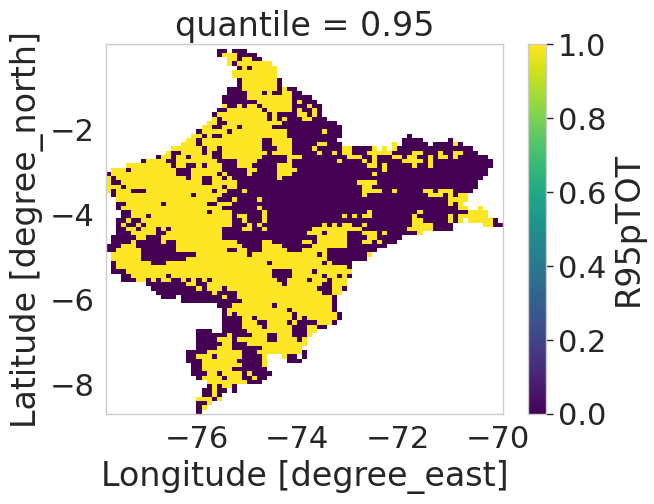

In [ ]:
Spearman_indiceE_R95pTOT = xr.apply_ufunc(Spearman_sig,
                                        R95pTOT,
                                        np.array(tabla_E).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceE_R95pTOT.plot()

In [ ]:
E_R95pTOT = Spearman_indiceE_R95pTOT.sum()/Spearman_indiceE_R95pTOT.count()*100
E_R95pTOT

<xarray.DataArray 'R95pTOT' ()>
array(49.6556248)
Coordinates:
    quantile  float64 0.95

###Index E - Rx1day

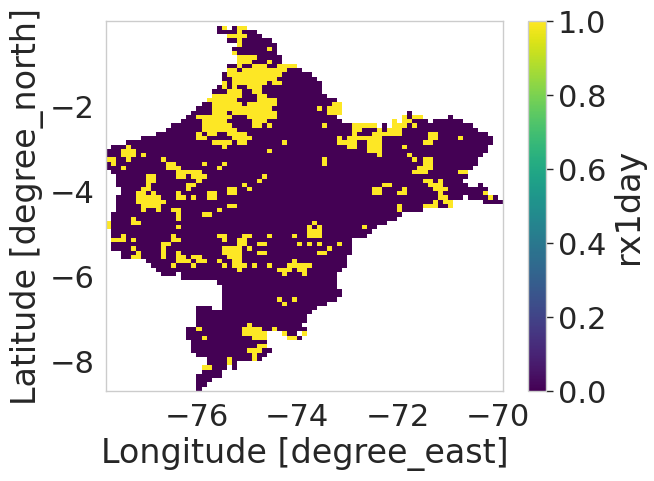

In [ ]:
Spearman_indiceE_RX1day = xr.apply_ufunc(Spearman_sig,
                                        RX1day,
                                        np.array(tabla_E).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceE_RX1day.plot()

In [ ]:
E_RX1day = Spearman_indiceE_RX1day.sum()/Spearman_indiceE_RX1day.count()*100
E_RX1day

<xarray.DataArray 'rx1day' ()>
array(17.513939)

###Index E - Rx5day

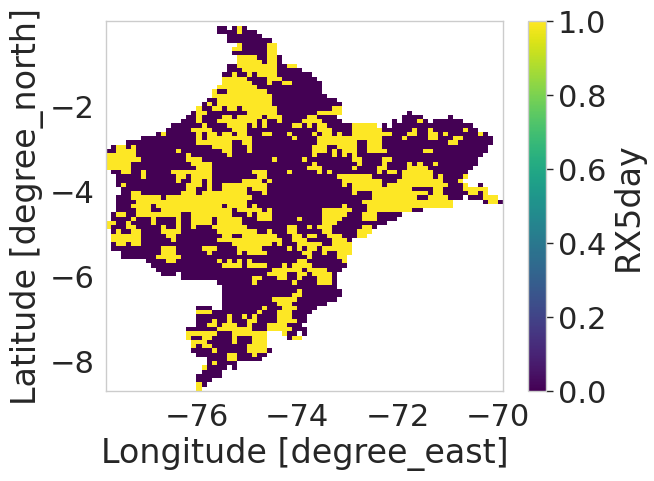

In [ ]:
Spearman_indiceE_RX5day = xr.apply_ufunc(Spearman_sig,
                                        RX5day,
                                        np.array(tabla_E).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceE_RX5day.plot()

In [ ]:
E_RX5day = Spearman_indiceE_RX5day.sum()/Spearman_indiceE_RX5day.count()*100
E_RX5day

<xarray.DataArray 'RX5day' ()>
array(36.63496228)

###Index E - SDII

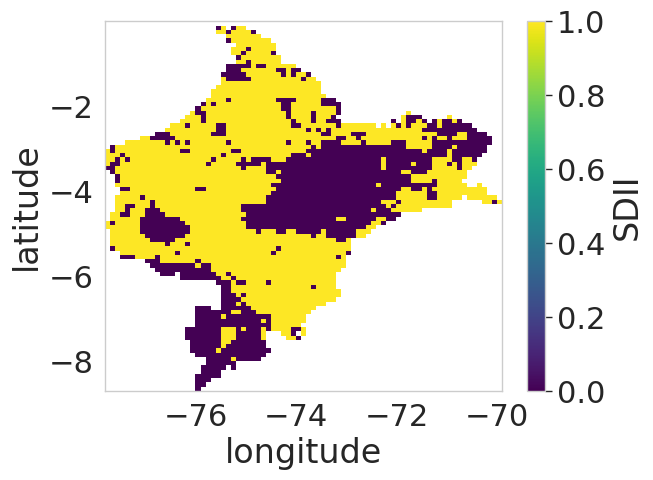

In [ ]:
Spearman_indiceE_SDII = xr.apply_ufunc(Spearman_sig,
                                        SDII,
                                        np.array(tabla_E).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceE_SDII.plot()

In [ ]:
E_SDII = Spearman_indiceE_SDII.sum()/Spearman_indiceE_SDII.count()*100
E_SDII

<xarray.DataArray 'SDII' ()>
array(61.92194162)

###Indsex E - PRCPTOT

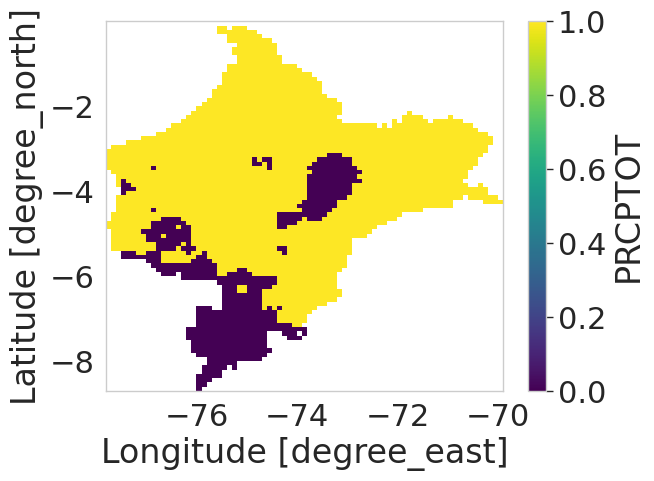

In [ ]:
Spearman_indiceE_PRCPTOT = xr.apply_ufunc(Spearman_sig,
                                        PRCPTOT,
                                        np.array(tabla_E).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceE_PRCPTOT.plot()

In [ ]:
E_PRCPTOT = Spearman_indiceE_PRCPTOT.sum()/Spearman_indiceE_PRCPTOT.count()*100
E_PRCPTOT

<xarray.DataArray 'PRCPTOT' ()>
array(80.55100033)

##INDEX C

###Index C - R1mm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


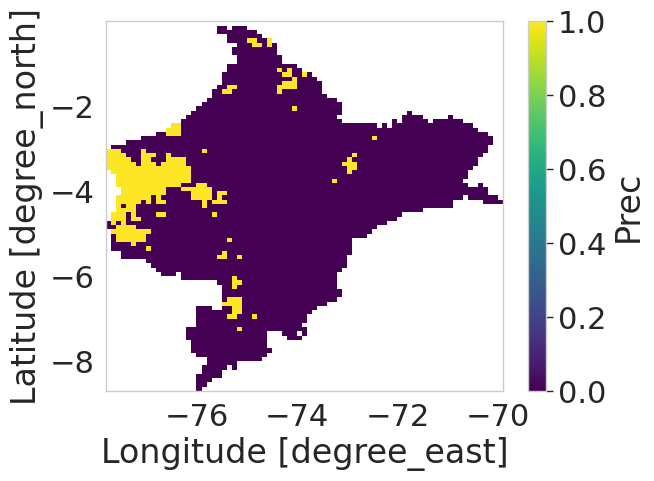

In [ ]:
Spearman_indiceC_R1mm = xr.apply_ufunc(Spearman_sig,
                                        R1mm(PISCOp_crop_masked.Prec),
                                        np.array(tabla_C).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceC_R1mm.plot()

In [ ]:
C_R1mm = Spearman_indiceC_R1mm.sum()/Spearman_indiceC_R1mm.count()*100
C_R1mm

<xarray.DataArray 'Prec' ()>
array(9.38012463)

###Index C - CWD

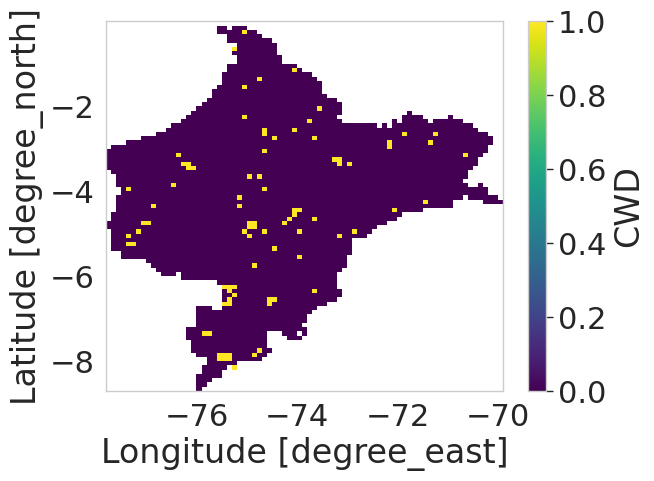

In [ ]:
Spearman_indiceC_CWD = xr.apply_ufunc(Spearman_sig,
                                        CWD,
                                        np.array(tabla_C).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceC_CWD.plot()

In [ ]:
C_CWD = Spearman_indiceC_CWD.sum()/Spearman_indiceC_CWD.count()*100
C_CWD

<xarray.DataArray 'CWD' ()>
array(2.85339456)

###Index C - CWDm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


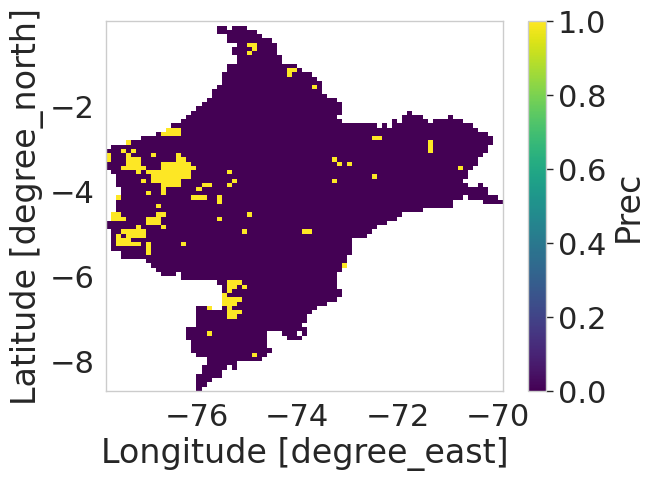

In [ ]:
Spearman_indiceC_CWDm = xr.apply_ufunc(Spearman_sig,
                                        CWDm,
                                        np.array(tabla_C).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceC_CWDm.plot()

In [ ]:
C_CWDm = Spearman_indiceC_CWDm.sum()/Spearman_indiceC_CWDm.count()*100
C_CWDm

<xarray.DataArray 'Prec' ()>
array(5.64119383)

###Index C - CDD

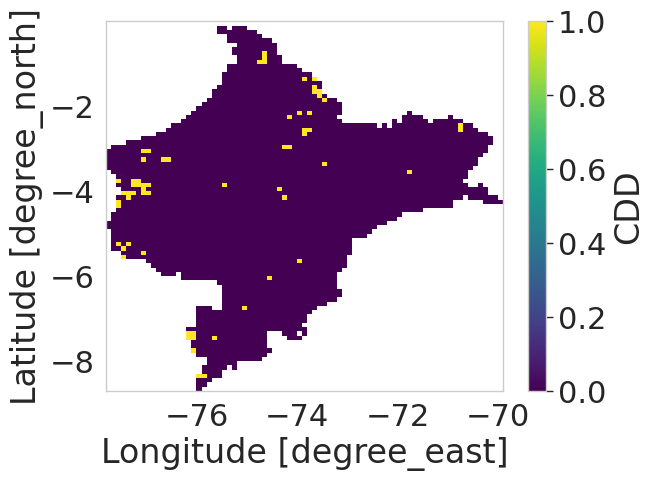

In [ ]:
Spearman_indiceC_CDD = xr.apply_ufunc(Spearman_sig,
                                        CDD,
                                        np.array(tabla_C).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceC_CDD.plot()

In [ ]:
C_CDD = Spearman_indiceC_CDD.sum()/Spearman_indiceC_CDD.count()*100
C_CDD

<xarray.DataArray 'CDD' ()>
array(2.06625123)

###Index C - CDDm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


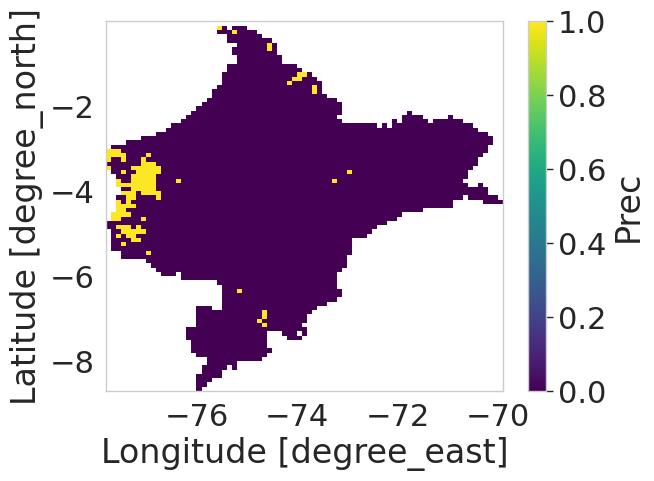

In [ ]:
Spearman_indiceC_CDDm = xr.apply_ufunc(Spearman_sig,
                                        CDDm,
                                        np.array(tabla_C).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceC_CDDm.plot()

In [ ]:
C_CDDm = Spearman_indiceC_CDDm.sum()/Spearman_indiceC_CDDm.count()*100
C_CDDm

<xarray.DataArray 'Prec' ()>
array(3.64053788)

###Index C - R95p

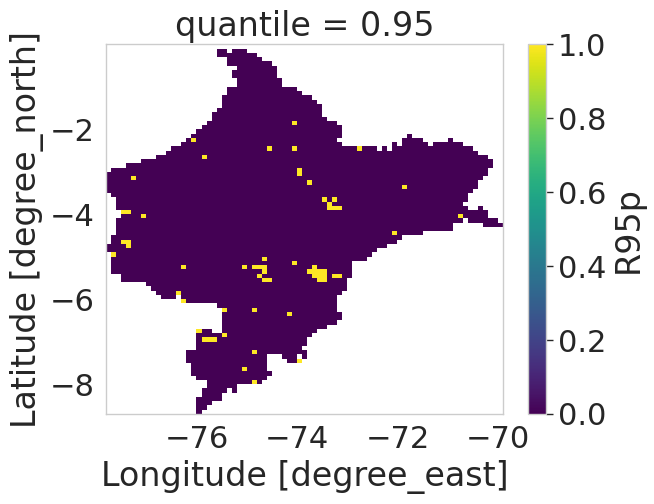

In [ ]:
Spearman_indiceC_R95p = xr.apply_ufunc(Spearman_sig,
                                        R95p,
                                        np.array(tabla_C).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceC_R95p.plot()

In [ ]:
C_R95p = Spearman_indiceC_R95p.sum()/Spearman_indiceC_R95p.count()*100
C_R95p

<xarray.DataArray 'R95p' ()>
array(2.06625123)
Coordinates:
    quantile  float64 0.95

###Index C - R95pTOT

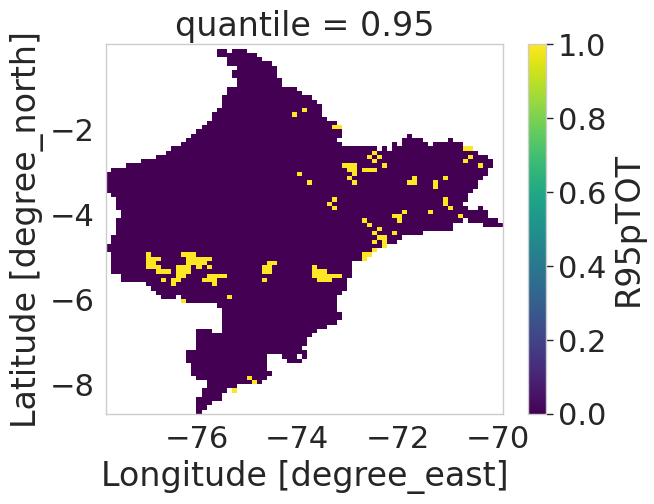

In [ ]:
Spearman_indiceC_R95pTOT = xr.apply_ufunc(Spearman_sig,
                                        R95pTOT,
                                        np.array(tabla_C).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceC_R95pTOT.plot()

In [ ]:
C_R95pTOT = Spearman_indiceC_R95pTOT.sum()/Spearman_indiceC_R95pTOT.count()*100
C_R95pTOT

<xarray.DataArray 'R95pTOT' ()>
array(4.26369301)
Coordinates:
    quantile  float64 0.95

###Index C - Rx1day

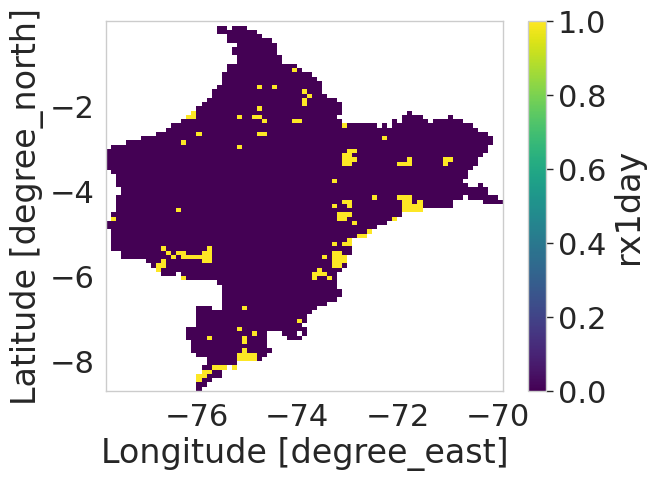

In [ ]:
Spearman_indiceC_RX1day = xr.apply_ufunc(Spearman_sig,
                                        RX1day,
                                        np.array(tabla_C).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceC_RX1day.plot()

In [ ]:
C_RX1day = Spearman_indiceC_RX1day.sum()/Spearman_indiceC_RX1day.count()*100
C_RX1day

<xarray.DataArray 'rx1day' ()>
array(4.55887176)

###Index C - Rx5day

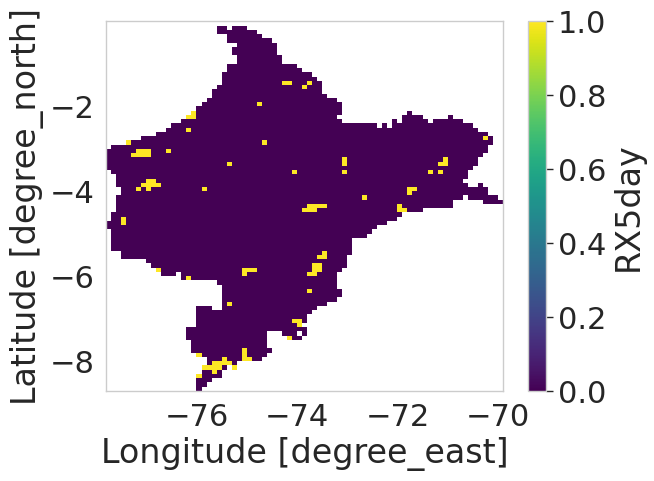

In [ ]:
Spearman_indiceC_RX5day = xr.apply_ufunc(Spearman_sig,
                                        RX5day,
                                        np.array(tabla_C).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceC_RX5day.plot()

In [ ]:
C_RX5day = Spearman_indiceC_RX5day.sum()/Spearman_indiceC_RX5day.count()*100
C_RX5day

<xarray.DataArray 'RX5day' ()>
array(3.05018039)

###Index C - SDII

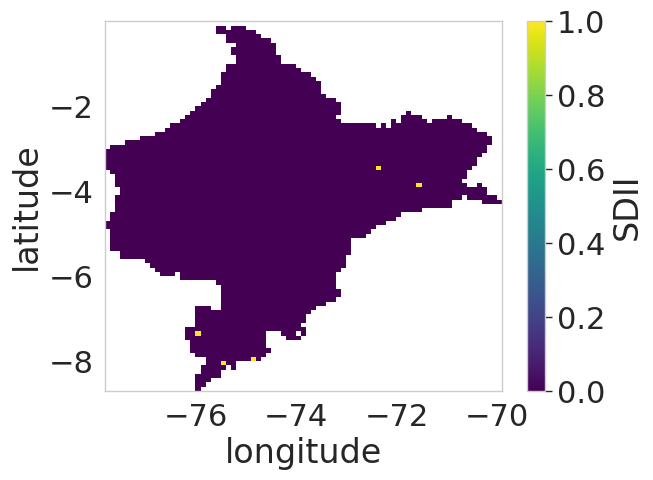

In [ ]:
Spearman_indiceC_SDII = xr.apply_ufunc(Spearman_sig,
                                        SDII,
                                        np.array(tabla_C).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceC_SDII.plot()

In [ ]:
C_SDII = Spearman_indiceC_SDII.sum()/Spearman_indiceC_SDII.count()*100
C_SDII

<xarray.DataArray 'SDII' ()>
array(0.16398819)

###Index C - PRCPTOT

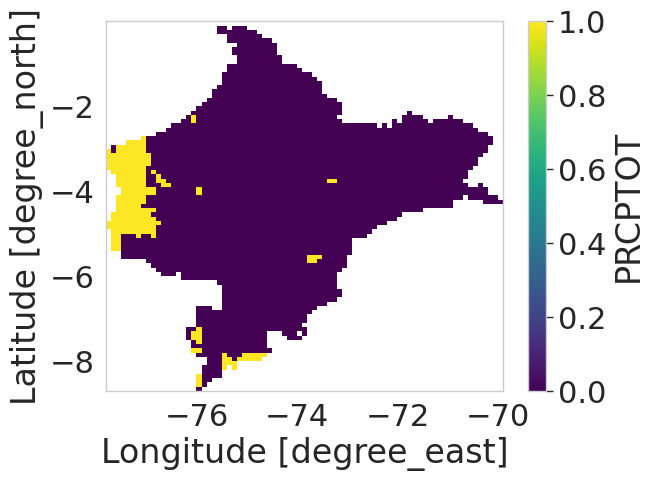

In [ ]:
Spearman_indiceC_PRCPTOT = xr.apply_ufunc(Spearman_sig,
                                        PRCPTOT,
                                        np.array(tabla_C).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceC_PRCPTOT.plot()

In [ ]:
C_PRCPTOT = Spearman_indiceC_PRCPTOT.sum()/Spearman_indiceC_PRCPTOT.count()*100
C_PRCPTOT

<xarray.DataArray 'PRCPTOT' ()>
array(7.21548049)

##TNAi

###TNAi - R1mm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


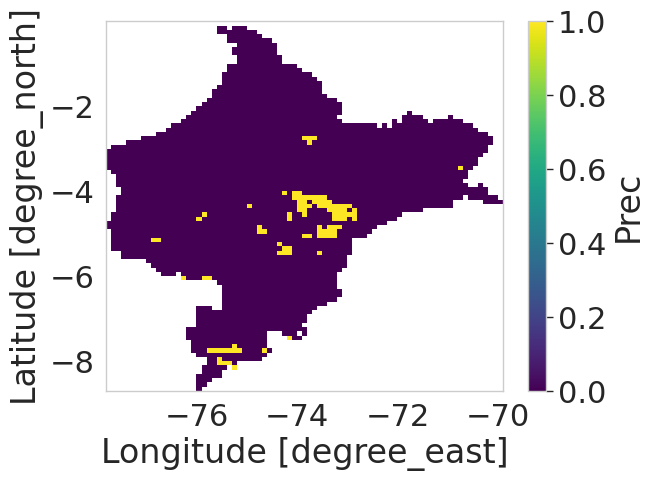

In [ ]:
Spearman_indiceTNA_R1mm = xr.apply_ufunc(Spearman_sig,
                                        R1mm(PISCOp_crop_masked.Prec),
                                        np.array(TNA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNA_R1mm.plot()

In [ ]:
TNA_R1mm = Spearman_indiceTNA_R1mm.sum()/Spearman_indiceTNA_R1mm.count()*100
TNA_R1mm

<xarray.DataArray 'Prec' ()>
array(3.18137094)

###TNAi - CWD

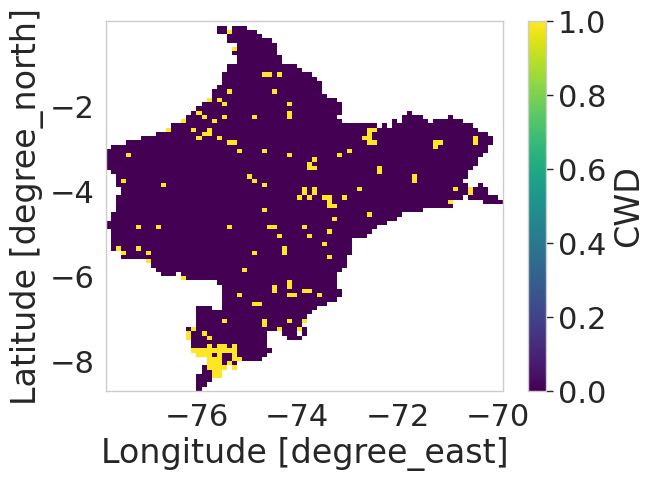

In [ ]:
Spearman_indiceTNA_CWD = xr.apply_ufunc(Spearman_sig,
                                        CWD,
                                        np.array(TNA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNA_CWD.plot()

In [ ]:
TNA_CWD = Spearman_indiceTNA_CWD.sum()/Spearman_indiceTNA_CWD.count()*100
TNA_CWD

<xarray.DataArray 'CWD' ()>
array(5.24762217)

###TNAi - CWDm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


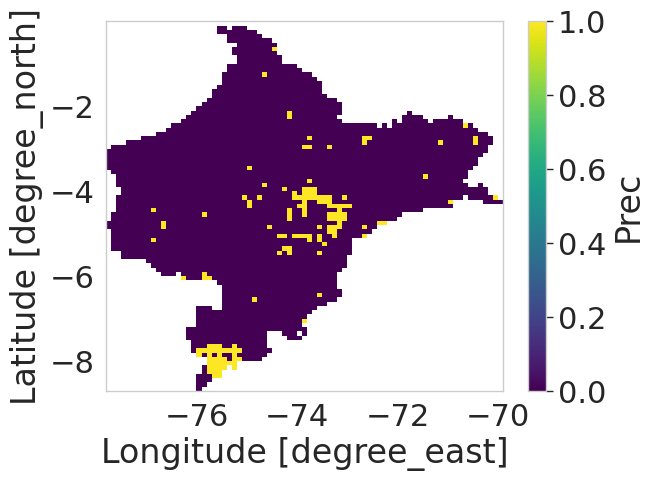

In [ ]:
Spearman_indiceTNA_CWDm = xr.apply_ufunc(Spearman_sig,
                                        CWDm,
                                        np.array(TNA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNA_CWDm.plot()

In [ ]:
TNA_CWDm = Spearman_indiceTNA_CWDm.sum()/Spearman_indiceTNA_CWDm.count()*100
TNA_CWDm

<xarray.DataArray 'Prec' ()>
array(4.78845523)

###TNAi - CDD

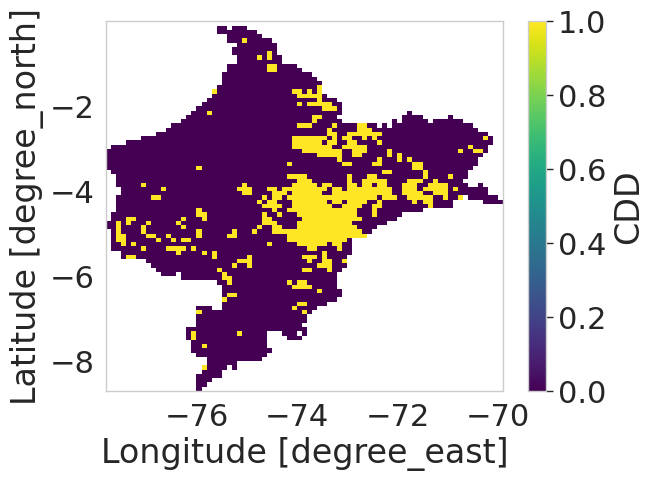

In [ ]:
Spearman_indiceTNA_CDD = xr.apply_ufunc(Spearman_sig,
                                        CDD,
                                        np.array(TNA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNA_CDD.plot()

In [ ]:
TNA_CDD = Spearman_indiceTNA_CWD.sum()/Spearman_indiceTNA_CWD.count()*100
TNA_CDD

<xarray.DataArray 'CWD' ()>
array(5.24762217)

###TNAi - CDDm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


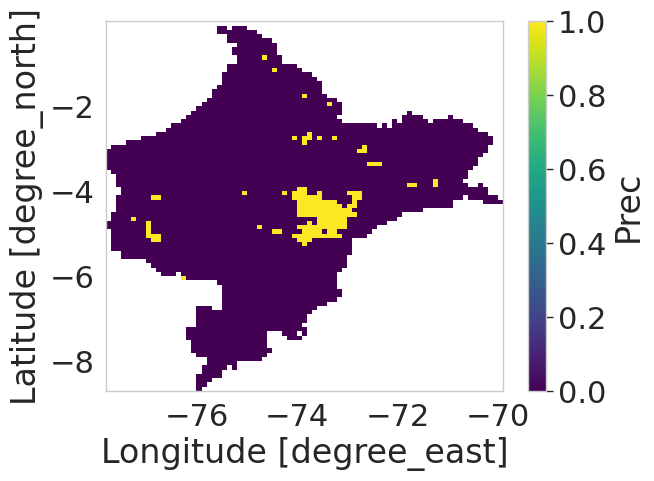

In [ ]:
Spearman_indiceTNA_CDDm = xr.apply_ufunc(Spearman_sig,
                                        CDDm,
                                        np.array(TNA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNA_CDDm.plot()

In [ ]:
TNA_CDDm = Spearman_indiceTNA_CDDm.sum()/Spearman_indiceTNA_CDDm.count()*100
TNA_CDDm

<xarray.DataArray 'Prec' ()>
array(4.62446704)

###TNAi - R95p

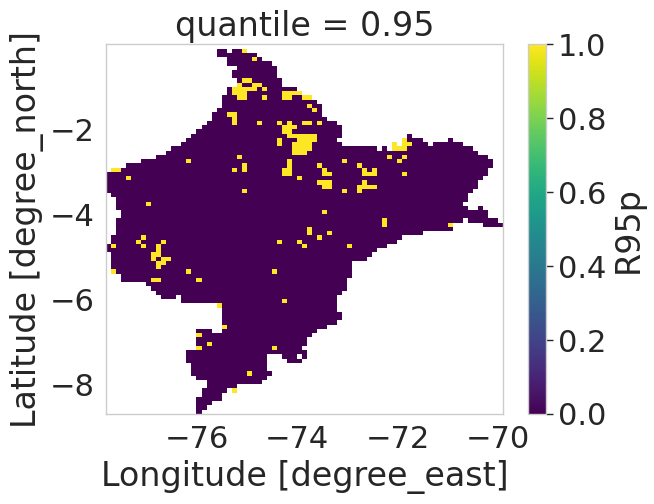

In [ ]:
Spearman_indiceTNA_R95p = xr.apply_ufunc(Spearman_sig,
                                        R95p,
                                        np.array(TNA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNA_R95p.plot()

In [ ]:
TNA_R95p = Spearman_indiceTNA_R95p.sum()/Spearman_indiceTNA_R95p.count()*100
TNA_R95p

<xarray.DataArray 'R95p' ()>
array(5.24762217)
Coordinates:
    quantile  float64 0.95

###TNAi - R95pTOT

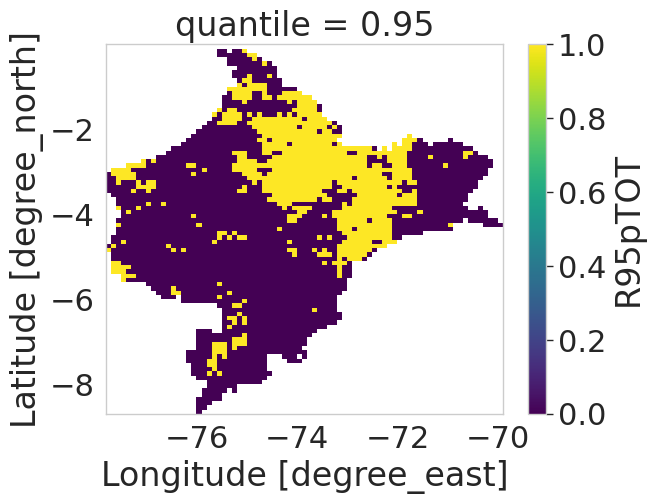

In [ ]:
Spearman_indiceTNA_R95pTOT = xr.apply_ufunc(Spearman_sig,
                                        R95pTOT,
                                        np.array(TNA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNA_R95pTOT.plot()

In [ ]:
TNA_R95pTOT = Spearman_indiceTNA_R95pTOT.sum()/Spearman_indiceTNA_R95pTOT.count()*100
TNA_R95pTOT

<xarray.DataArray 'R95pTOT' ()>
array(27.87799278)
Coordinates:
    quantile  float64 0.95

###TNAi - Rx1day

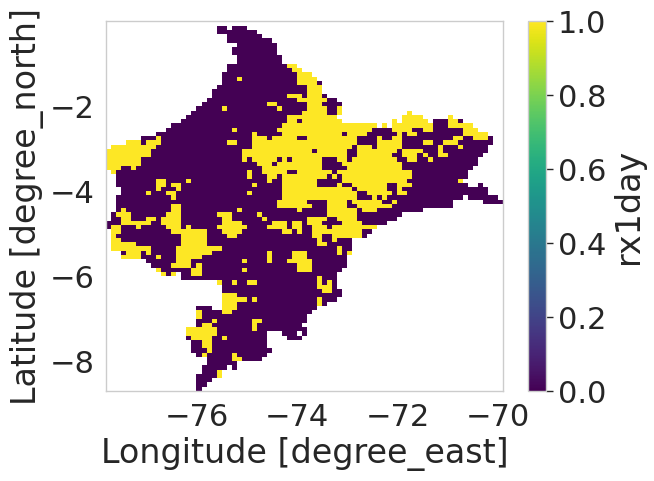

In [ ]:
Spearman_indiceTNA_RX1day = xr.apply_ufunc(Spearman_sig,
                                        RX1day,
                                        np.array(TNA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNA_RX1day.plot()

In [ ]:
TNA_RX1day = Spearman_indiceTNA_RX1day.sum()/Spearman_indiceTNA_RX1day.count()*100
TNA_RX1day

<xarray.DataArray 'rx1day' ()>
array(32.07609052)

###TNAi - Rx5day

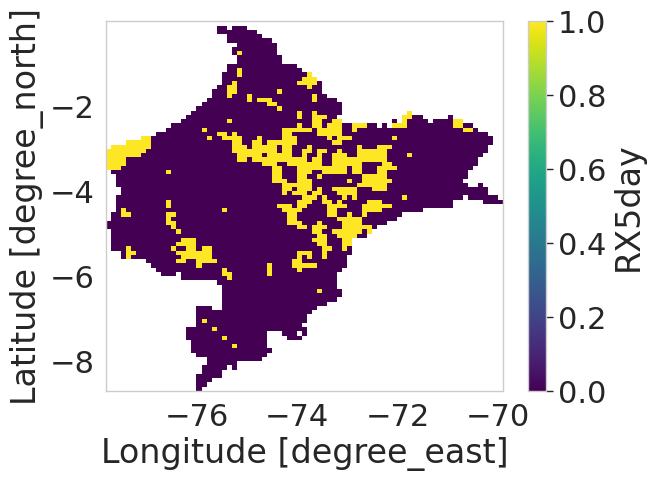

In [ ]:
Spearman_indiceTNA_RX5day = xr.apply_ufunc(Spearman_sig,
                                        RX5day,
                                        np.array(TNA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNA_RX5day.plot()

In [ ]:
TNA_RX5day = Spearman_indiceTNA_RX5day.sum()/Spearman_indiceTNA_RX5day.count()*100
TNA_RX5day

<xarray.DataArray 'RX5day' ()>
array(17.15316497)

###TNAi - SDII

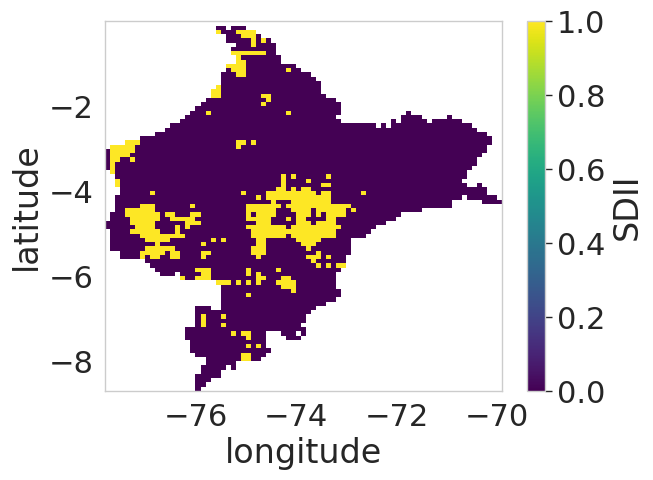

In [ ]:
Spearman_indiceTNA_SDII = xr.apply_ufunc(Spearman_sig,
                                        SDII,
                                        np.array(TNA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNA_SDII.plot()

In [ ]:
TNA_SDII = Spearman_indiceTNA_SDII.sum()/Spearman_indiceTNA_SDII.count()*100
TNA_SDII

<xarray.DataArray 'SDII' ()>
array(13.51262709)

###TNAi - PRCPTOT

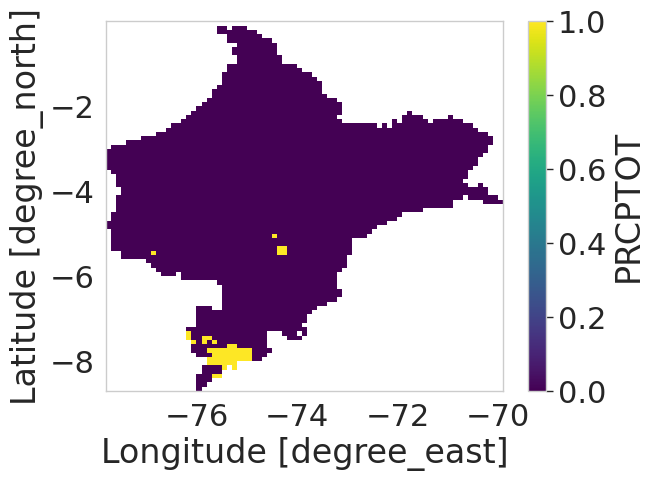

In [ ]:
Spearman_indiceTNA_PRCPTOT = xr.apply_ufunc(Spearman_sig,
                                        PRCPTOT,
                                        np.array(TNA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNA_PRCPTOT.plot()

In [ ]:
TNA_PRCPTOT = Spearman_indiceTNA_PRCPTOT.sum()/Spearman_indiceTNA_PRCPTOT.count()*100
TNA_PRCPTOT

<xarray.DataArray 'PRCPTOT' ()>
array(1.67267957)

##TSAi

###TSAi - R1mm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


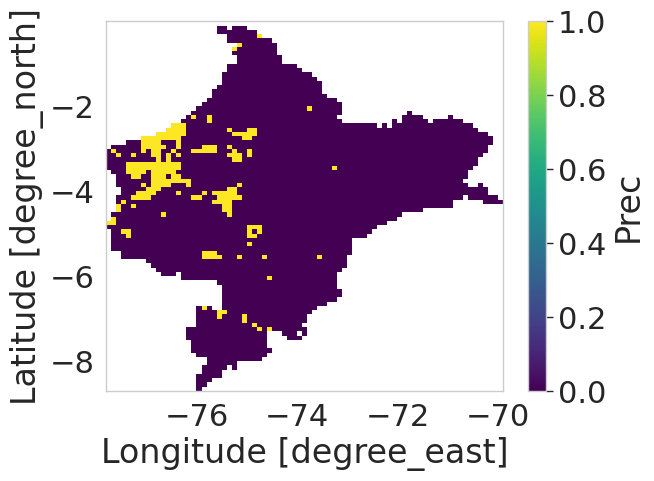

In [ ]:
Spearman_indiceTSA_R1mm = xr.apply_ufunc(Spearman_sig,
                                        R1mm(PISCOp_crop_masked.Prec),
                                        np.array(TSA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTSA_R1mm.plot()

In [ ]:
TSA_R1mm = Spearman_indiceTSA_R1mm.sum()/Spearman_indiceTSA_R1mm.count()*100
TSA_R1mm

<xarray.DataArray 'Prec' ()>
array(6.82190882)

###TSAi - CWD

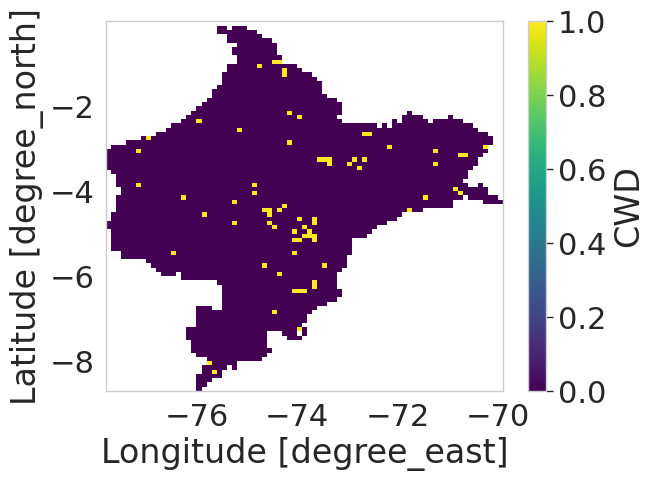

In [ ]:
Spearman_indiceTSA_CWD = xr.apply_ufunc(Spearman_sig,
                                        CWD,
                                        np.array(TSA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTSA_CWD.plot()

In [ ]:
TSA_CWD = Spearman_indiceTSA_CWD.sum()/Spearman_indiceTSA_CWD.count()*100
TSA_CWD

<xarray.DataArray 'CWD' ()>
array(2.36142998)

###TSAi - CWDm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


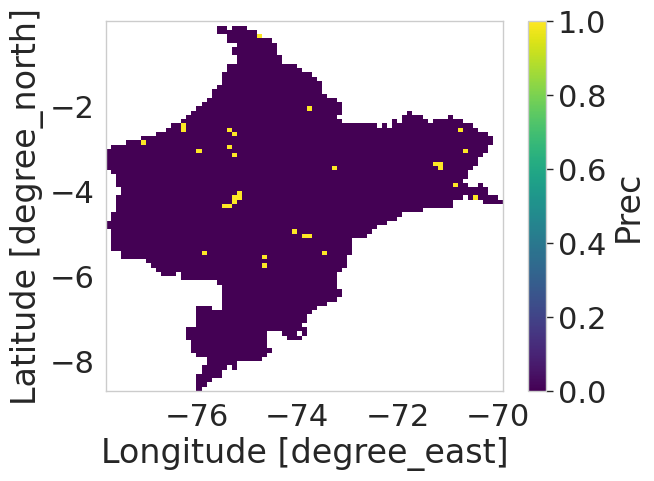

In [ ]:
Spearman_indiceTSA_CWDm = xr.apply_ufunc(Spearman_sig,
                                        CWDm,
                                        np.array(TSA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTSA_CWDm.plot()

In [ ]:
TSA_CWDm = Spearman_indiceTSA_CWDm.sum()/Spearman_indiceTSA_CWDm.count()*100
TSA_CWDm

<xarray.DataArray 'Prec' ()>
array(1.0167268)

###TSAi - CDD

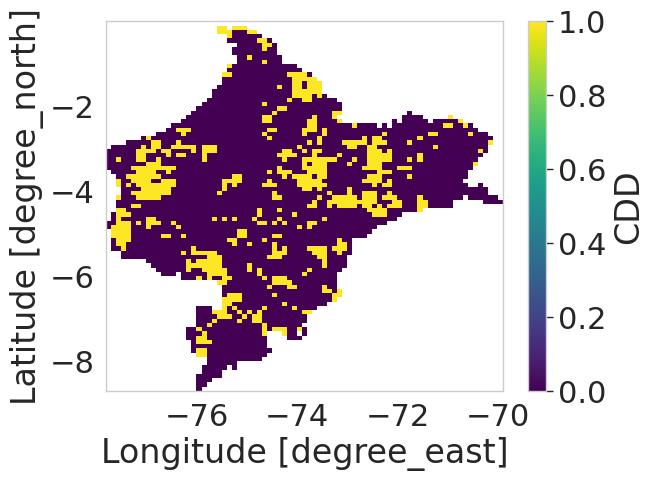

In [ ]:
Spearman_indiceTSA_CDD = xr.apply_ufunc(Spearman_sig,
                                        CDD,
                                        np.array(TSA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTSA_CDD.plot()

In [ ]:
TSA_CDD = Spearman_indiceTSA_CDD.sum()/Spearman_indiceTSA_CDD.count()*100
TSA_CDD

<xarray.DataArray 'CDD' ()>
array(19.97376189)

###TSAi - CDDm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


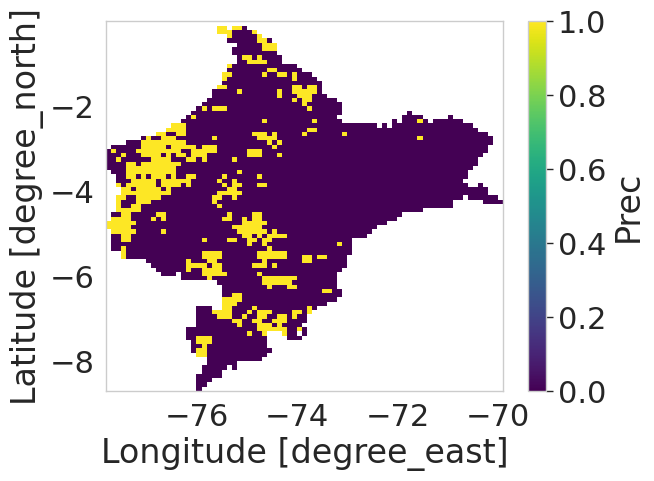

In [ ]:
Spearman_indiceTSA_CDDm = xr.apply_ufunc(Spearman_sig,
                                        CDDm,
                                        np.array(TSA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTSA_CDDm.plot()

In [ ]:
TSA_CDDm = Spearman_indiceTSA_CDDm.sum()/Spearman_indiceTSA_CDDm.count()*100
TSA_CDDm

<xarray.DataArray 'Prec' ()>
array(16.30042637)

###TSAi - R95p

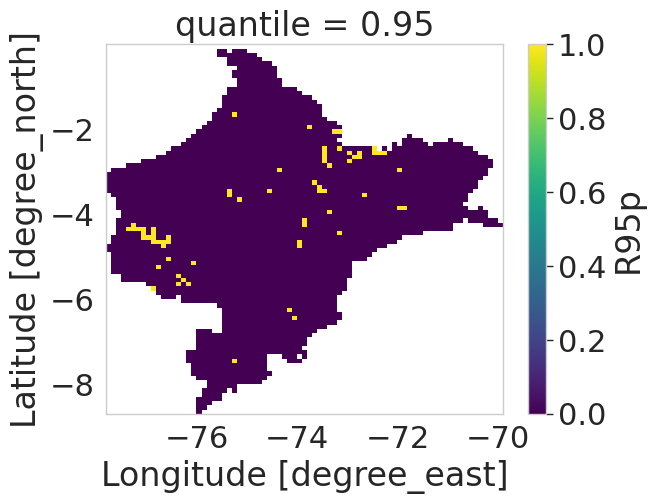

In [ ]:
Spearman_indiceTSA_R95p = xr.apply_ufunc(Spearman_sig,
                                        R95p,
                                        np.array(TSA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTSA_R95p.plot()

In [ ]:
TSA_R95p = Spearman_indiceTSA_R95p.sum()/Spearman_indiceTSA_R95p.count()*100
TSA_R95p

<xarray.DataArray 'R95p' ()>
array(2.16464415)
Coordinates:
    quantile  float64 0.95

###TSAi - R95pTOT

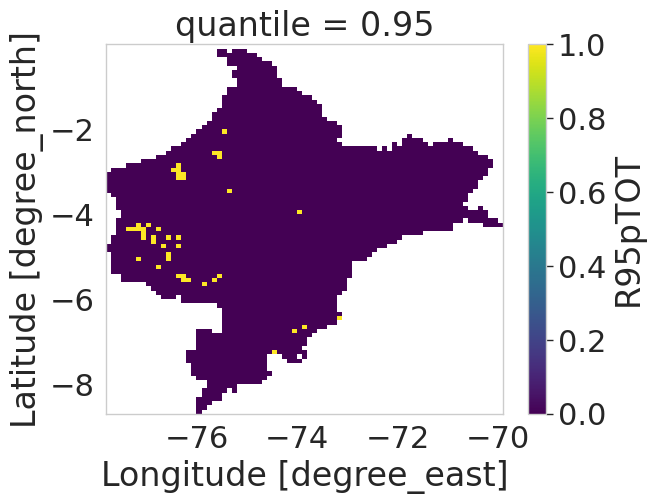

In [ ]:
Spearman_indiceTSA_R95pTOT = xr.apply_ufunc(Spearman_sig,
                                        R95pTOT,
                                        np.array(TSA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTSA_R95pTOT.plot()

In [ ]:
TSA_R95pTOT = Spearman_indiceTSA_R95pTOT.sum()/Spearman_indiceTSA_R95pTOT.count()*100
TSA_R95pTOT

<xarray.DataArray 'R95pTOT' ()>
array(1.41029846)
Coordinates:
    quantile  float64 0.95

###TSAi - Rx1day

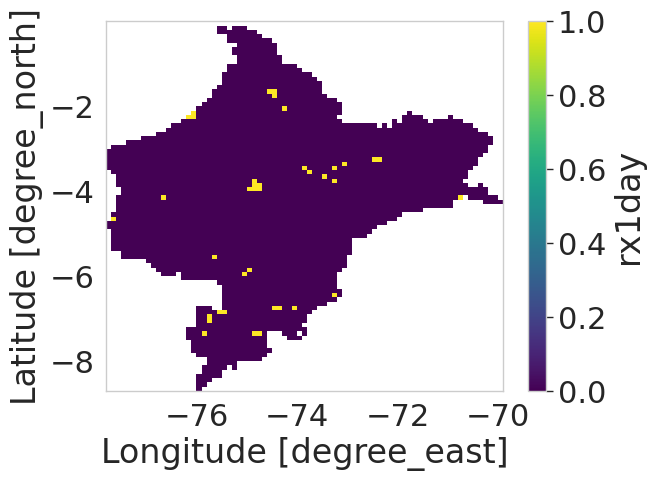

In [ ]:
Spearman_indiceTSA_RX1day = xr.apply_ufunc(Spearman_sig,
                                        RX1day,
                                        np.array(TSA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTSA_RX1day.plot()

In [ ]:
TSA_RX1day = Spearman_indiceTSA_RX1day.sum()/Spearman_indiceTSA_RX1day.count()*100
TSA_RX1day

<xarray.DataArray 'rx1day' ()>
array(1.24631027)

###TSAi - Rx5day

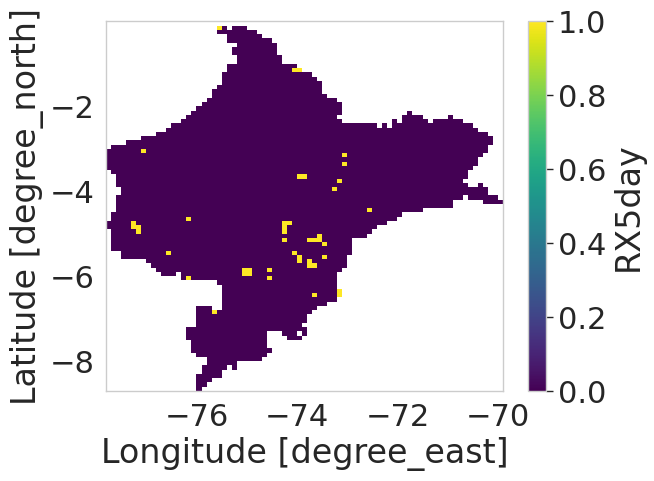

In [ ]:
Spearman_indiceTSA_RX5day = xr.apply_ufunc(Spearman_sig,
                                        RX5day,
                                        np.array(TSA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTSA_RX5day.plot()

In [ ]:
TSA_RX5day = Spearman_indiceTSA_RX5day.sum()/Spearman_indiceTSA_RX5day.count()*100
TSA_RX5day

<xarray.DataArray 'RX5day' ()>
array(1.47589374)

###TSAi - SDII

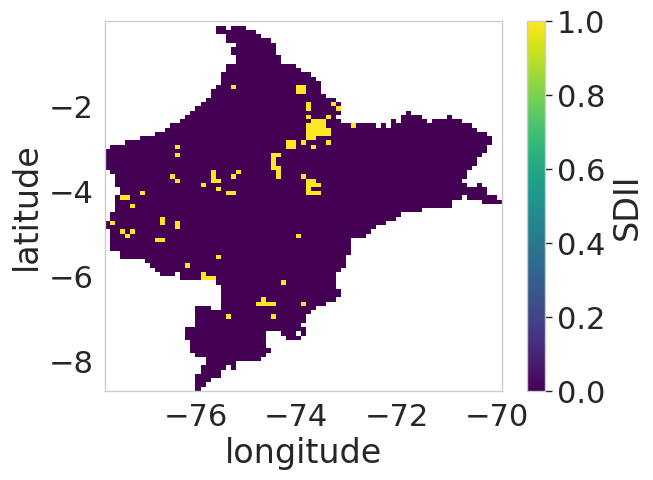

In [ ]:
Spearman_indiceTSA_SDII = xr.apply_ufunc(Spearman_sig,
                                        SDII,
                                        np.array(TSA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTSA_SDII.plot()

In [ ]:
TSA_SDII = Spearman_indiceTSA_SDII.sum()/Spearman_indiceTSA_SDII.count()*100
TSA_SDII

<xarray.DataArray 'SDII' ()>
array(3.27976386)

###TSAi - PRCPTOT

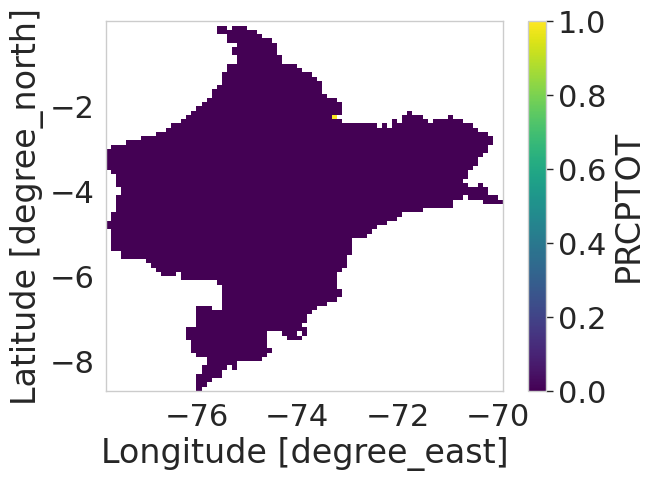

In [ ]:
Spearman_indiceTSA_PRCPTOT = xr.apply_ufunc(Spearman_sig,
                                        PRCPTOT,
                                        np.array(TSA_filtro).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTSA_PRCPTOT.plot()

In [ ]:
TSA_PRCPTOT = Spearman_indiceTSA_PRCPTOT.sum()/Spearman_indiceTSA_PRCPTOT.count()*100
TSA_PRCPTOT

<xarray.DataArray 'PRCPTOT' ()>
array(0.03279764)

##TN - TSi

###TN - TSi - R1mm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


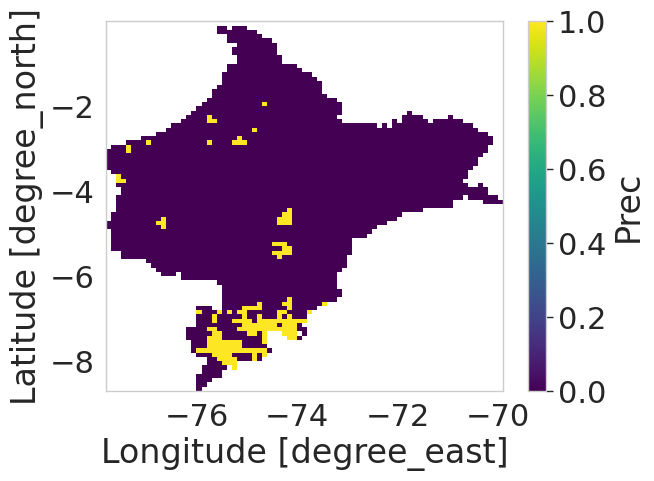

In [ ]:
Spearman_indiceTNS_R1mm = xr.apply_ufunc(Spearman_sig,
                                        R1mm(PISCOp_crop_masked.Prec),
                                        np.array(TNS).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNS_R1mm.plot()

In [ ]:
TNS_R1mm = Spearman_indiceTNS_R1mm.sum()/Spearman_indiceTNS_R1mm.count()*100
TNS_R1mm

<xarray.DataArray 'Prec' ()>
array(5.21482453)

###TN - TSi - CWD

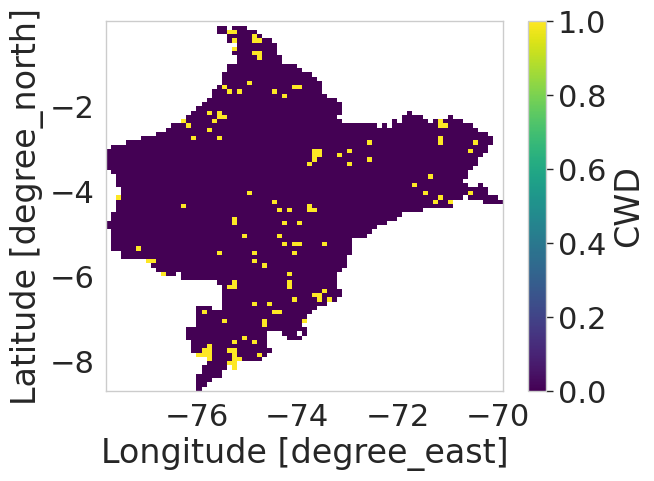

In [ ]:
Spearman_indiceTNS_CWD = xr.apply_ufunc(Spearman_sig,
                                        CWD,
                                        np.array(TNS).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNS_CWD.plot()

In [ ]:
TNS_CWD = Spearman_indiceTNS_CWD.sum()/Spearman_indiceTNS_CWD.count()*100
TNS_CWD

<xarray.DataArray 'CWD' ()>
array(3.96851427)

###TN - TSi - CWDm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


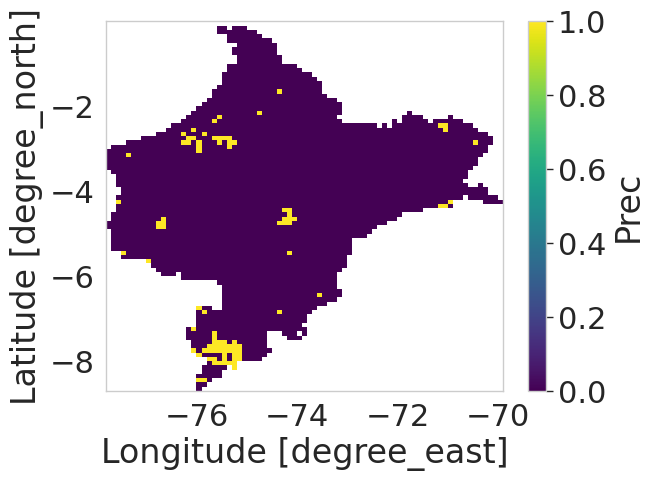

In [ ]:
Spearman_indiceTNS_CWDm = xr.apply_ufunc(Spearman_sig,
                                        CWDm,
                                        np.array(TNS).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNS_CWDm.plot()

In [ ]:
TNS_CWDm = Spearman_indiceTNS_CWDm.sum()/Spearman_indiceTNS_CWDm.count()*100
TNS_CWDm

<xarray.DataArray 'Prec' ()>
array(3.01738275)

###TN - TSi - CDD

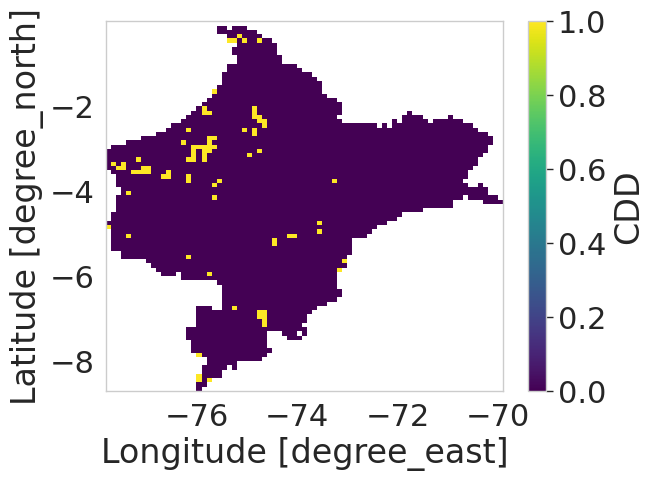

In [ ]:
Spearman_indiceTNS_CDD = xr.apply_ufunc(Spearman_sig,
                                        CDD,
                                        np.array(TNS).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNS_CDD.plot()

In [ ]:
TNS_CDD = Spearman_indiceTNS_CDD.sum()/Spearman_indiceTNS_CDD.count()*100
TNS_CDD

<xarray.DataArray 'CDD' ()>
array(2.722204)

###TN - TSi - CDDm

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


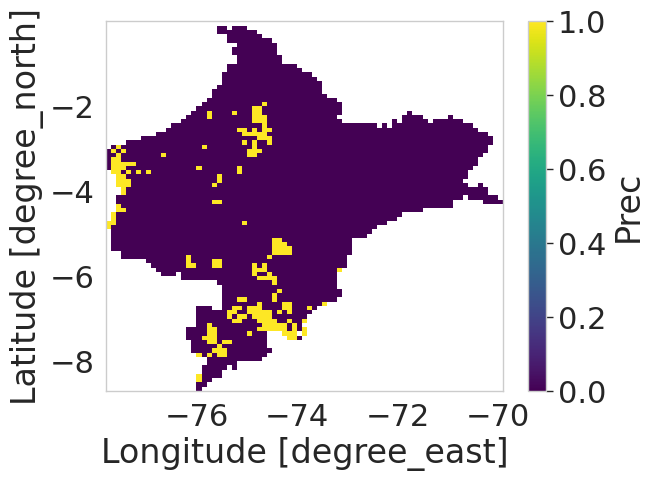

In [ ]:
Spearman_indiceTNS_CDDm = xr.apply_ufunc(Spearman_sig,
                                        CDDm,
                                        np.array(TNS).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNS_CDDm.plot()

In [ ]:
TNS_CDDm = Spearman_indiceTNS_CDDm.sum()/Spearman_indiceTNS_CDDm.count()*100
TNS_CDDm

<xarray.DataArray 'Prec' ()>
array(6.69071827)

###TN - TSi - R95p

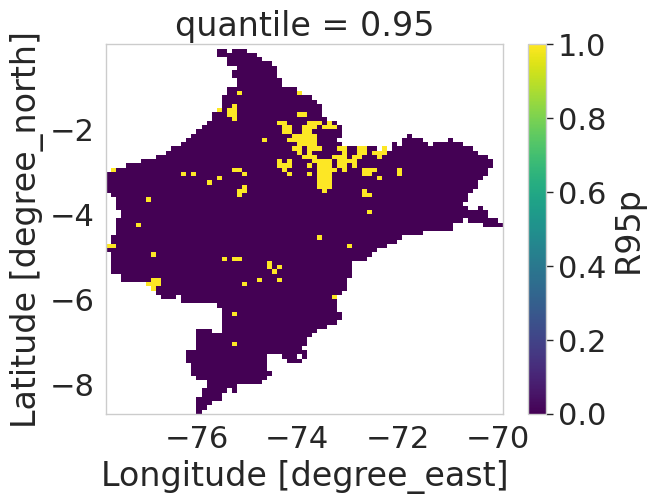

In [ ]:
Spearman_indiceTNS_R95p = xr.apply_ufunc(Spearman_sig,
                                        R95p,
                                        np.array(TNS).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNS_R95p.plot()

In [ ]:
TNS_R95p = Spearman_indiceTNS_R95p.sum()/Spearman_indiceTNS_R95p.count()*100
TNS_R95p

<xarray.DataArray 'R95p' ()>
array(5.34601509)
Coordinates:
    quantile  float64 0.95

###TN - TSi - R95pTOT

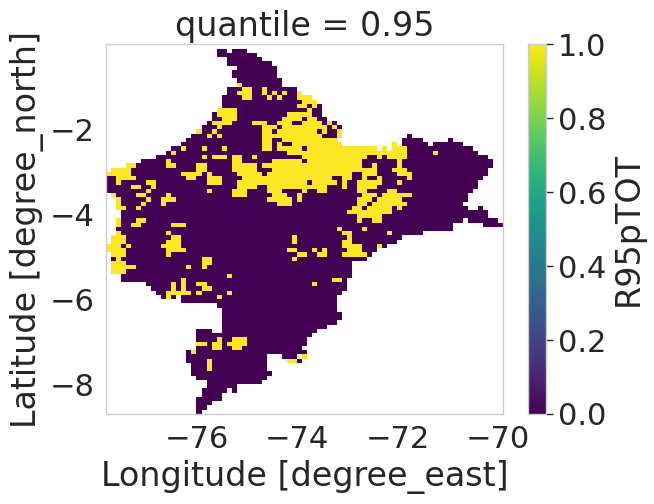

In [ ]:
Spearman_indiceTNS_R95pTOT = xr.apply_ufunc(Spearman_sig,
                                        R95pTOT,
                                        np.array(TNS).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNS_R95pTOT.plot()

In [ ]:
TNS_R95pTOT = Spearman_indiceTNS_R95pTOT.sum()/Spearman_indiceTNS_R95pTOT.count()*100
TNS_R95pTOT

<xarray.DataArray 'R95pTOT' ()>
array(21.64644146)
Coordinates:
    quantile  float64 0.95

###TN - TSi - Rx1day

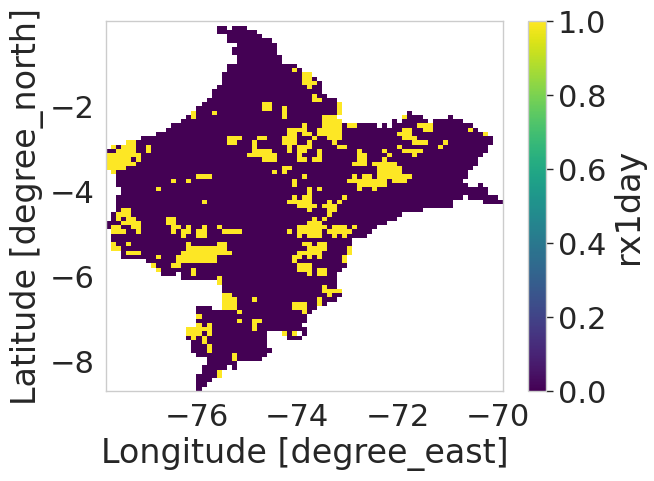

In [ ]:
Spearman_indiceTNS_RX1day = xr.apply_ufunc(Spearman_sig,
                                        RX1day,
                                        np.array(TNS).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNS_RX1day.plot()

In [ ]:
TNS_RX1day = Spearman_indiceTNS_RX1day.sum()/Spearman_indiceTNS_RX1day.count()*100
TNS_RX1day

<xarray.DataArray 'rx1day' ()>
array(15.71006888)

###TN - TSi - Rx5day

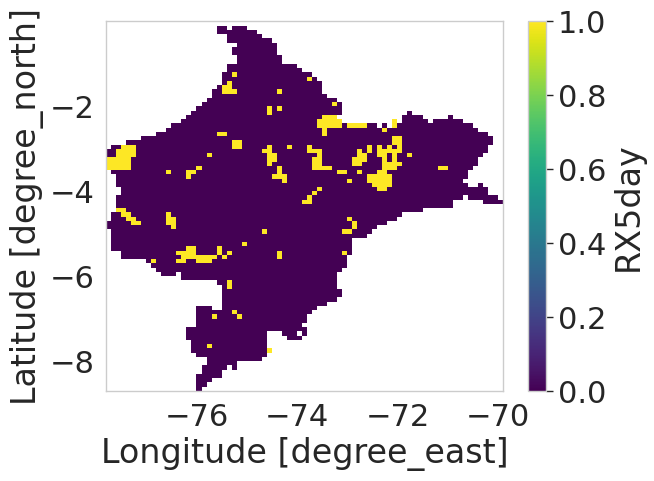

In [ ]:
Spearman_indiceTNS_RX5day = xr.apply_ufunc(Spearman_sig,
                                        RX5day,
                                        np.array(TNS).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNS_RX5day.plot()

In [ ]:
TNS_RX5day= Spearman_indiceTNS_RX5day.sum()/Spearman_indiceTNS_RX5day.count()*100
TNS_RX5day

<xarray.DataArray 'RX5day' ()>
array(7.18268285)

###TN - TSi - SDII

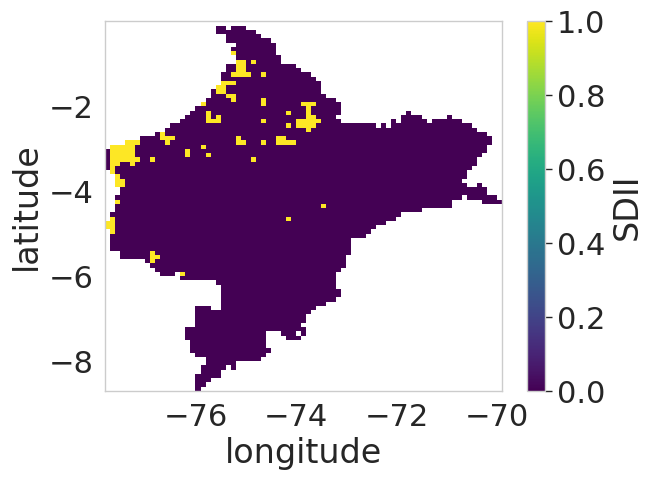

In [ ]:
Spearman_indiceTNS_SDII = xr.apply_ufunc(Spearman_sig,
                                        SDII,
                                        np.array(TNS).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNS_SDII.plot()

In [ ]:
TNS_SDII = Spearman_indiceTNS_SDII.sum()/Spearman_indiceTNS_SDII.count()*100
TNS_SDII

<xarray.DataArray 'SDII' ()>
array(3.96851427)

###TN - TSi - PRCPTOT

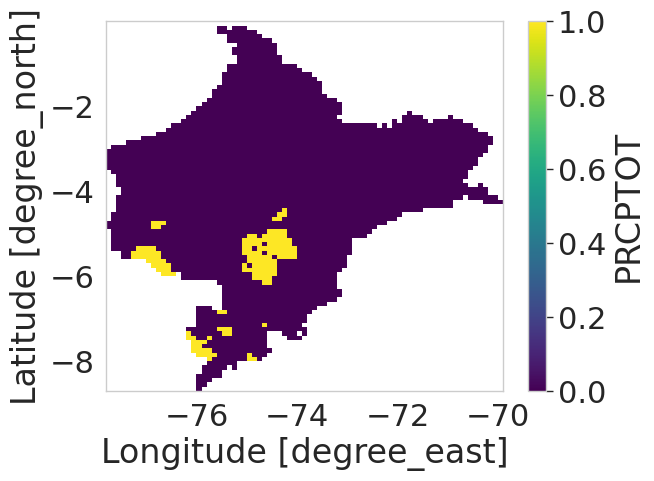

In [ ]:
Spearman_indiceTNS_PRCPTOT = xr.apply_ufunc(Spearman_sig,
                                         PRCPTOT,
                                        np.array(TNS).ravel(),
                                        input_core_dims=[["time"], ["time"]],
                                        vectorize=True)

Spearman_indiceTNS_PRCPTOT.plot()

In [ ]:
TNS_PRCPTOT = Spearman_indiceTNS_PRCPTOT.sum()/Spearman_indiceTNS_PRCPTOT.count()*100
TNS_PRCPTOT

<xarray.DataArray 'PRCPTOT' ()>
array(5.18202689)

##GRAFICA DE INDICES

###INDICE PDO

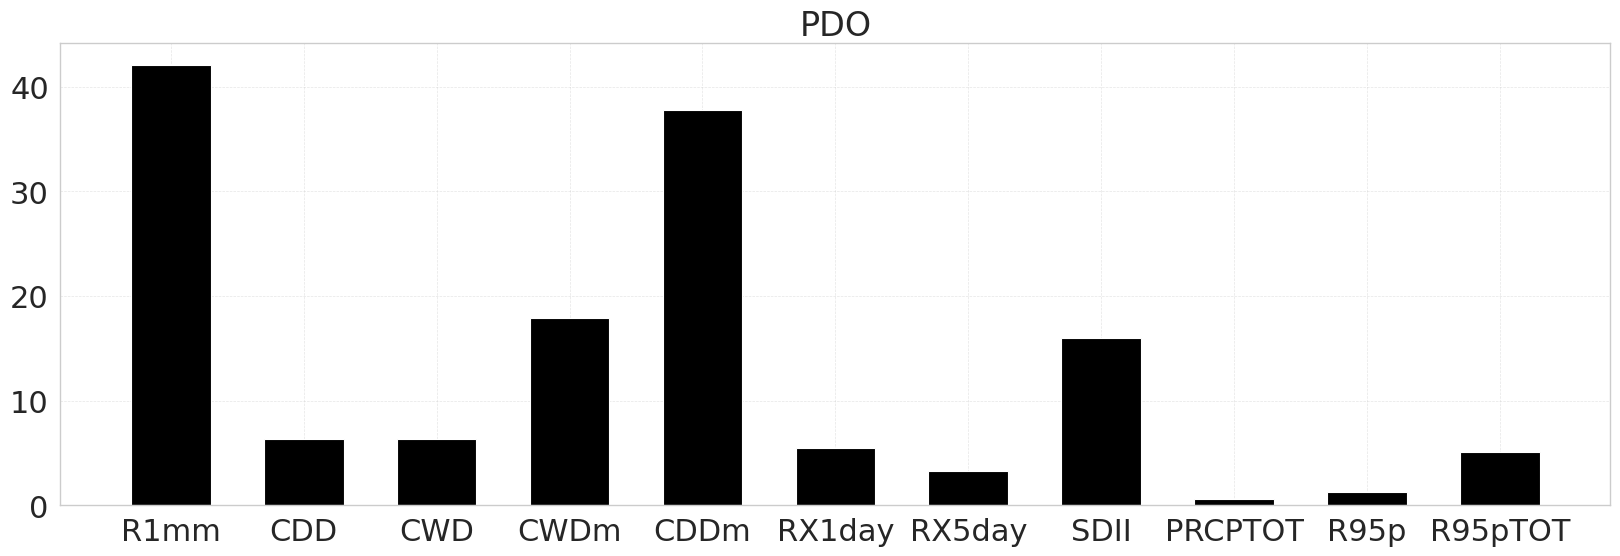

In [ ]:
array_PDO = [PDO_R1mm, PDO_CDD, PDO_CWD, PDO_CWDm, PDO_CDDm, PDO_RX1day, PDO_RX5day, PDO_SDII, PDO_PRCPTOT, PDO_R95p, PDO_R95pTOT]
porcentaje_PDO = [array_PDO[0], array_PDO[1], array_PDO[2], array_PDO[3], array_PDO[4], array_PDO[5], array_PDO[6], array_PDO[7], array_PDO[8], array_PDO[9], array_PDO[10]]
etiquetas = ["R1mm", "CDD", "CWD", "CWDm", "CDDm", "RX1day", "RX5day", "SDII", "PRCPTOT", "R95p", "R95pTOT"]
colores = ["k"]
grosor = [0.6]

fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
ax.bar(x=etiquetas, height=porcentaje_PDO, width=grosor, color=colores)

ax.set_title('PDO')

ax.set_axisbelow(True)  # Colocamos el grillado detrás del gráfico
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Modificar el estilo del grillado

plt.show()

### INDICE E

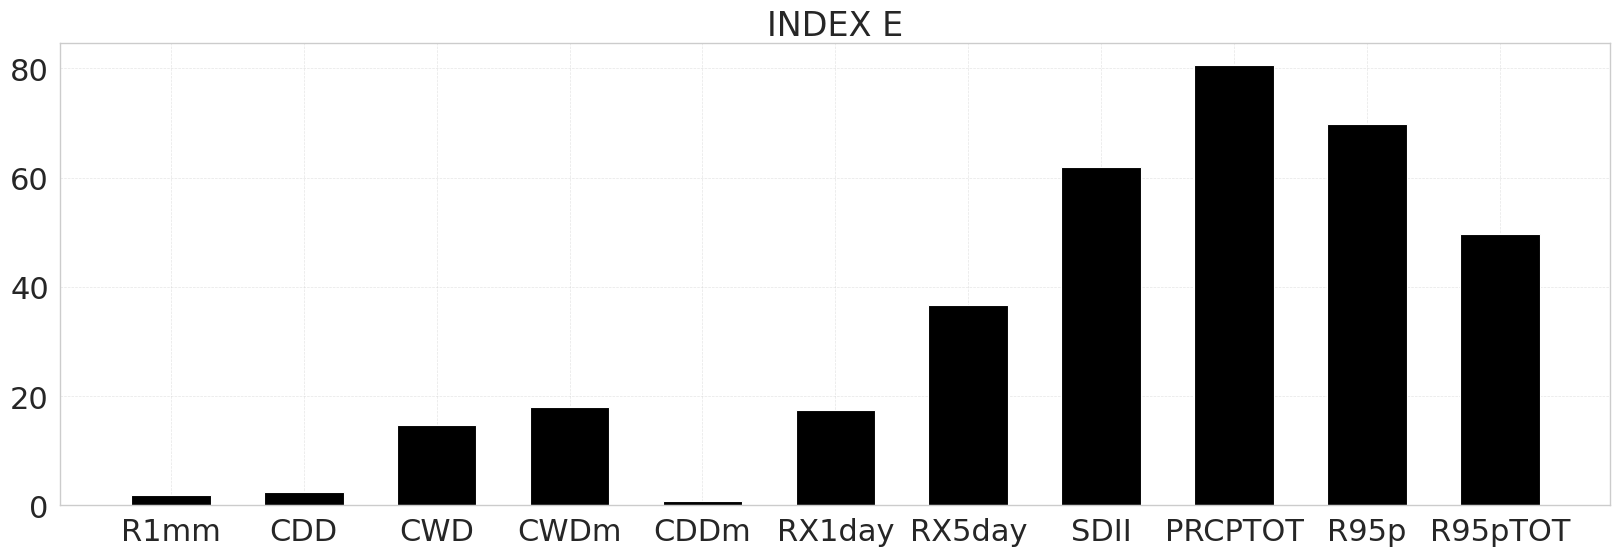

In [ ]:
array_E = [E_R1mm, E_CDD, E_CWD, E_CWDm, E_CDDm, E_RX1day, E_RX5day, E_SDII, E_PRCPTOT, E_R95p, E_R95pTOT]
porcentaje_E = [array_E[0], array_E[1], array_E[2], array_E[3], array_E[4], array_E[5], array_E[6], array_E[7], array_E[8], array_E[9], array_E[10]]
etiquetas = ["R1mm", "CDD", "CWD", "CWDm", "CDDm", "RX1day", "RX5day", "SDII", "PRCPTOT", "R95p", "R95pTOT"]
colores = ["k"]
grosor = [0.6]

fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
ax.bar(x=etiquetas, height=porcentaje_E, width=grosor, color=colores)

ax.set_title('INDEX E')

ax.set_axisbelow(True)  # Colocamos el grillado detrás del gráfico
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Modificar el estilo del grillado

plt.show()

### INDICE C




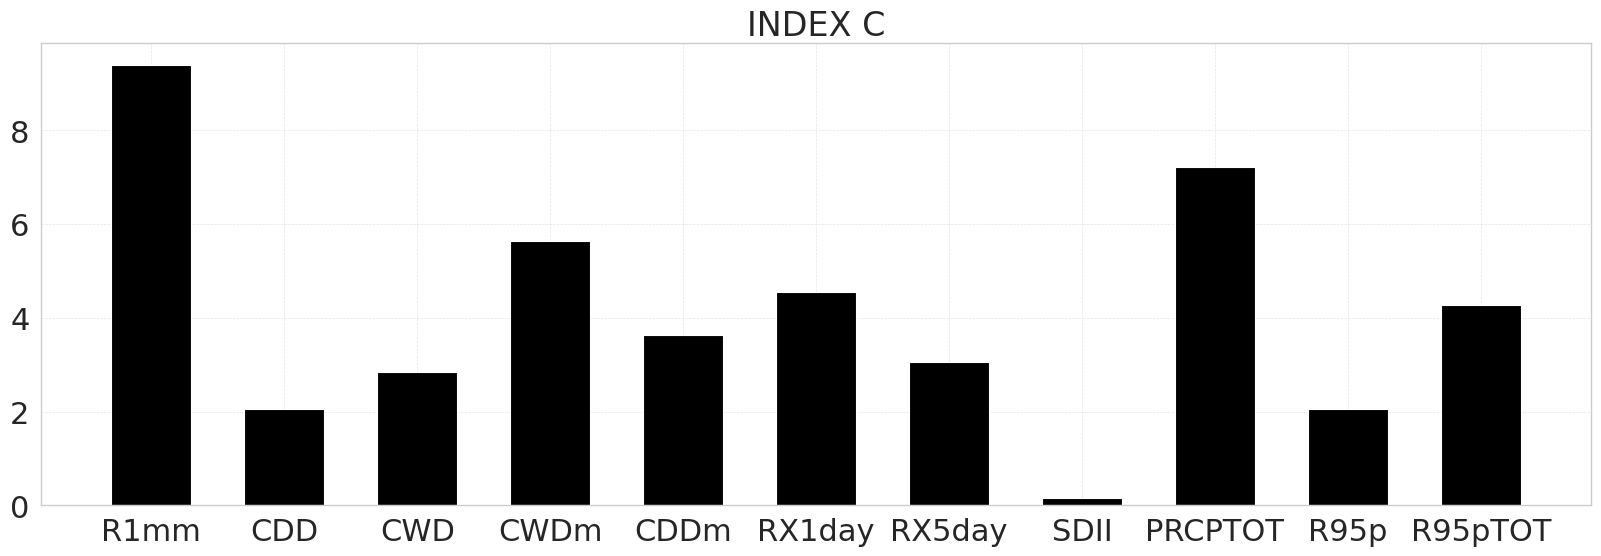

In [ ]:
array_C = [C_R1mm, C_CDD, C_CWD, C_CWDm, C_CDDm, C_RX1day, C_RX5day, C_SDII, C_PRCPTOT, C_R95p, C_R95pTOT]
porcentaje_C = [array_C[0], array_C[1], array_C[2], array_C[3], array_C[4], array_C[5], array_C[6], array_C[7], array_C[8], array_C[9], array_C[10]]
etiquetas = ["R1mm", "CDD", "CWD", "CWDm", "CDDm", "RX1day", "RX5day", "SDII", "PRCPTOT", "R95p", "R95pTOT"]
colores = ["k"]
grosor = [0.6]

fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
ax.bar(x=etiquetas, height=porcentaje_C, width=grosor, color=colores)

ax.set_title('INDEX C')

ax.set_axisbelow(True)  # Colocamos el grillado detrás del gráfico
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Modificar el estilo del grillado

plt.show()

### INDICE TNAi

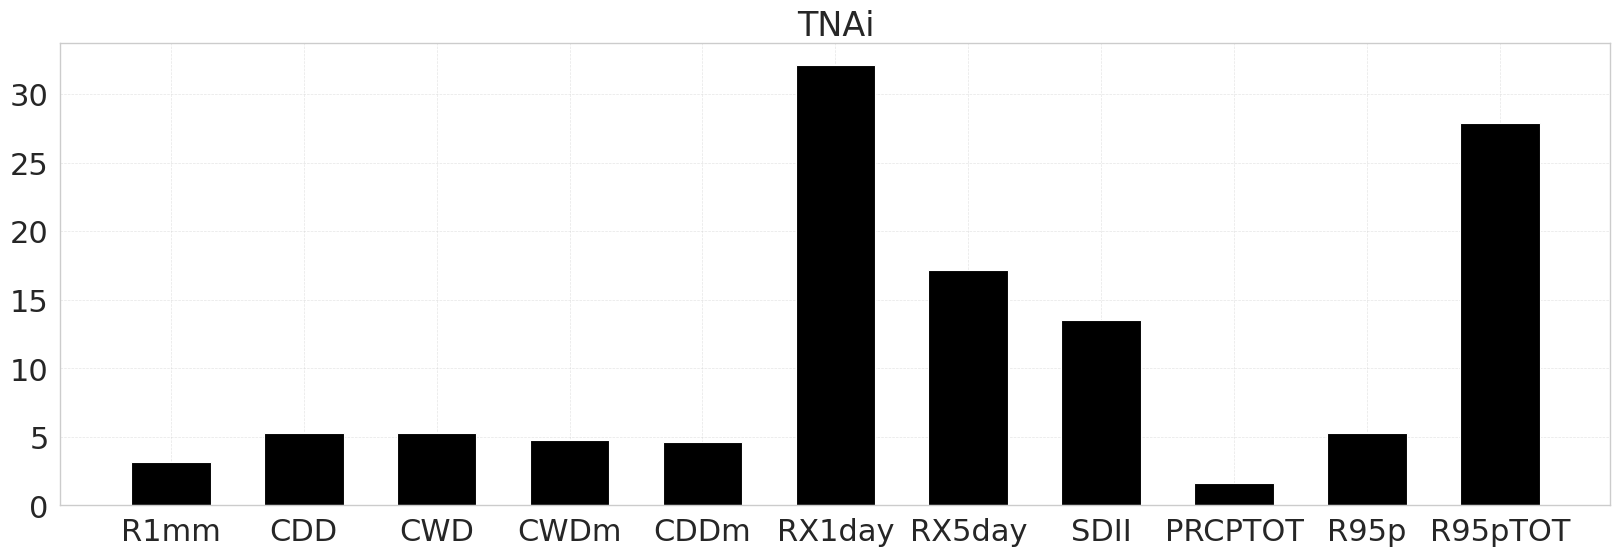

In [ ]:
array_TNA = [TNA_R1mm, TNA_CDD, TNA_CWD, TNA_CWDm, TNA_CDDm, TNA_RX1day, TNA_RX5day, TNA_SDII, TNA_PRCPTOT, TNA_R95p, TNA_R95pTOT]
porcentaje_TNA = [array_TNA[0], array_TNA[1], array_TNA[2], array_TNA[3], array_TNA[4], array_TNA[5], array_TNA[6], array_TNA[7], array_TNA[8], array_TNA[9], array_TNA[10]]
etiquetas = ["R1mm", "CDD", "CWD", "CWDm", "CDDm", "RX1day", "RX5day", "SDII", "PRCPTOT", "R95p", "R95pTOT"]
colores = ["k"]
grosor = [0.6]

fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
ax.bar(x=etiquetas, height=porcentaje_TNA, width=grosor, color=colores)

ax.set_title('TNAi')

ax.set_axisbelow(True)  # Colocamos el grillado detrás del gráfico
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Modificar el estilo del grillado

plt.show()

### INDICE TSAi

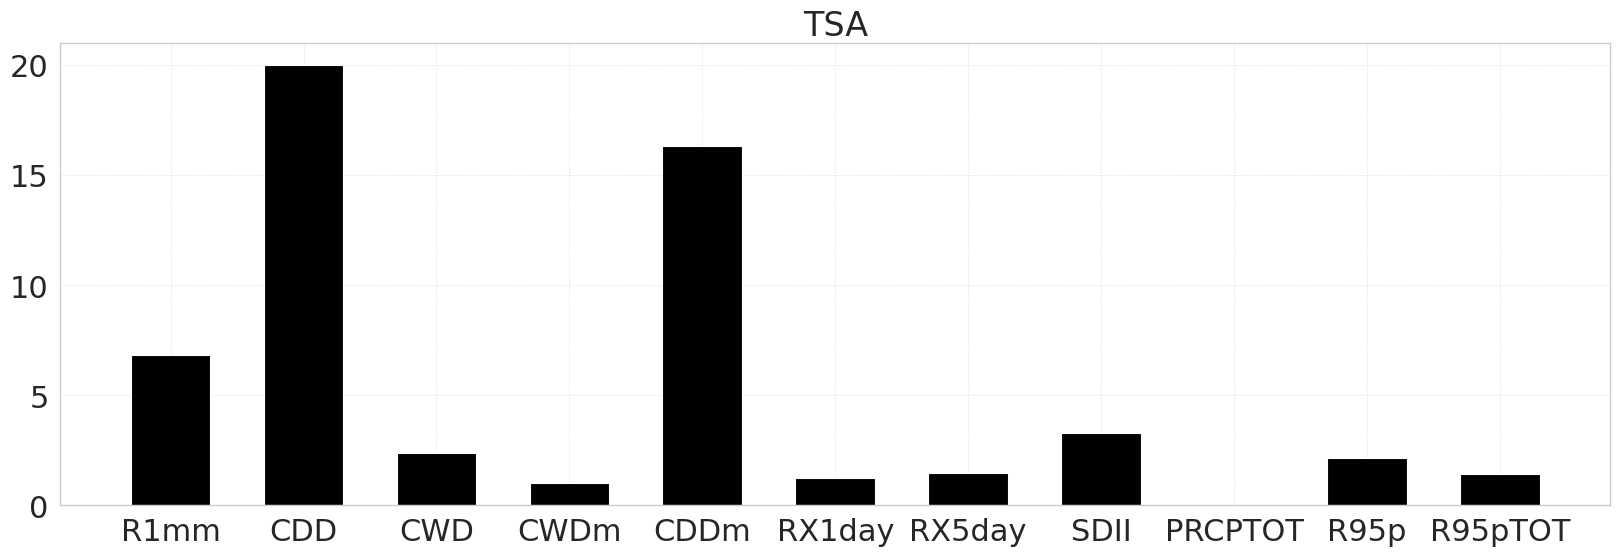

In [ ]:
array_TSA = [TSA_R1mm, TSA_CDD, TSA_CWD, TSA_CWDm, TSA_CDDm, TSA_RX1day, TSA_RX5day, TSA_SDII, TSA_PRCPTOT, TSA_R95p, TSA_R95pTOT]
porcentaje_TSA = [array_TSA[0], array_TSA[1], array_TSA[2], array_TSA[3], array_TSA[4], array_TSA[5], array_TSA[6], array_TSA[7], array_TSA[8], array_TSA[9], array_TSA[10]]
etiquetas = ["R1mm", "CDD", "CWD", "CWDm", "CDDm", "RX1day", "RX5day", "SDII", "PRCPTOT", "R95p", "R95pTOT"]
colores = ["k"]
grosor = [0.6]

fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
ax.bar(x=etiquetas, height=porcentaje_TSA, width=grosor, color=colores)

ax.set_title('TSA')

ax.set_axisbelow(True)  # Colocamos el grillado detrás del gráfico
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Modificar el estilo del grillado

plt.show()

### INDICE TN - TSi

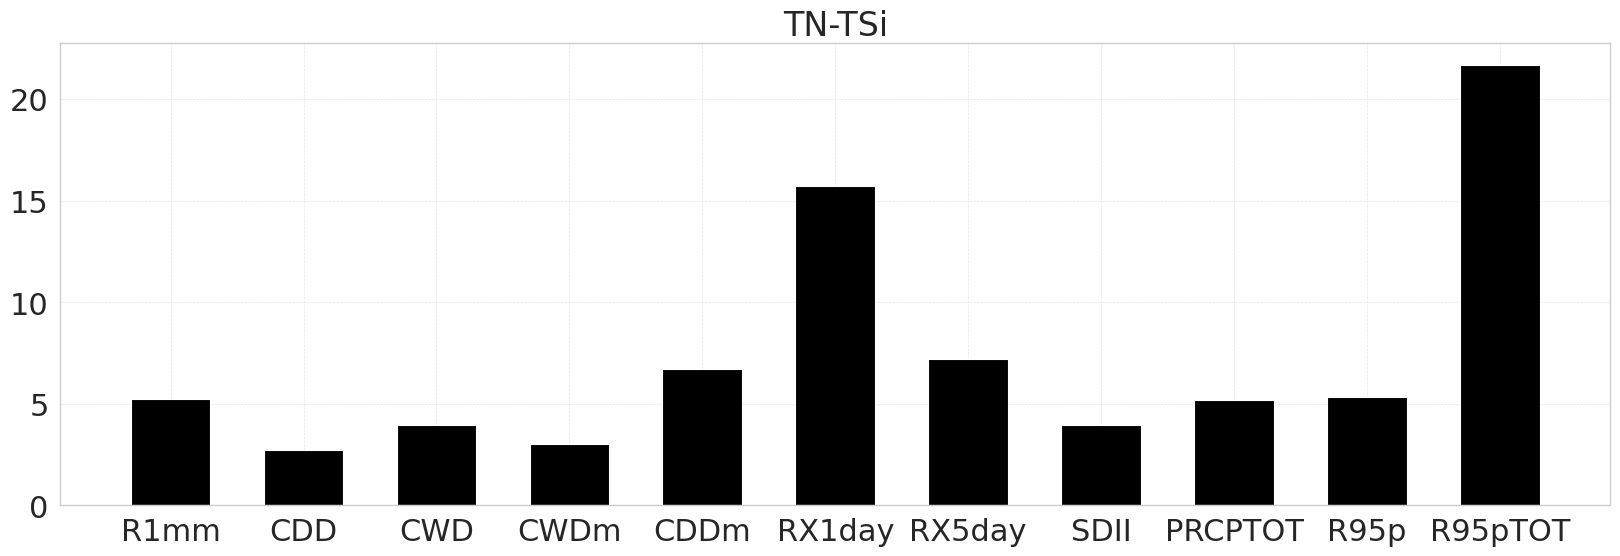

In [ ]:
array_TNS = [TNS_R1mm, TNS_CDD, TNS_CWD, TNS_CWDm, TNS_CDDm, TNS_RX1day, TNS_RX5day, TNS_SDII, TNS_PRCPTOT, TNS_R95p, TNS_R95pTOT]
porcentaje_TNS = [array_TNS[0], array_TNS[1], array_TNS[2], array_TNS[3], array_TNS[4], array_TNS[5], array_TNS[6], array_TNS[7], array_TNS[8], array_TNS[9], array_TNS[10]]
etiquetas = ["R1mm", "CDD", "CWD", "CWDm", "CDDm", "RX1day", "RX5day", "SDII", "PRCPTOT", "R95p", "R95pTOT"]
colores = ["k"]
grosor = [0.6]

fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
ax.bar(x=etiquetas, height=porcentaje_TNS, width=grosor, color=colores)

ax.set_title("TN-TSi")
ax.set_axisbelow(True)  # Colocamos el grillado detrás del gráfico
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Modificar el estilo del grillado

plt.show()

# GRAFICA FINAL - INDICES

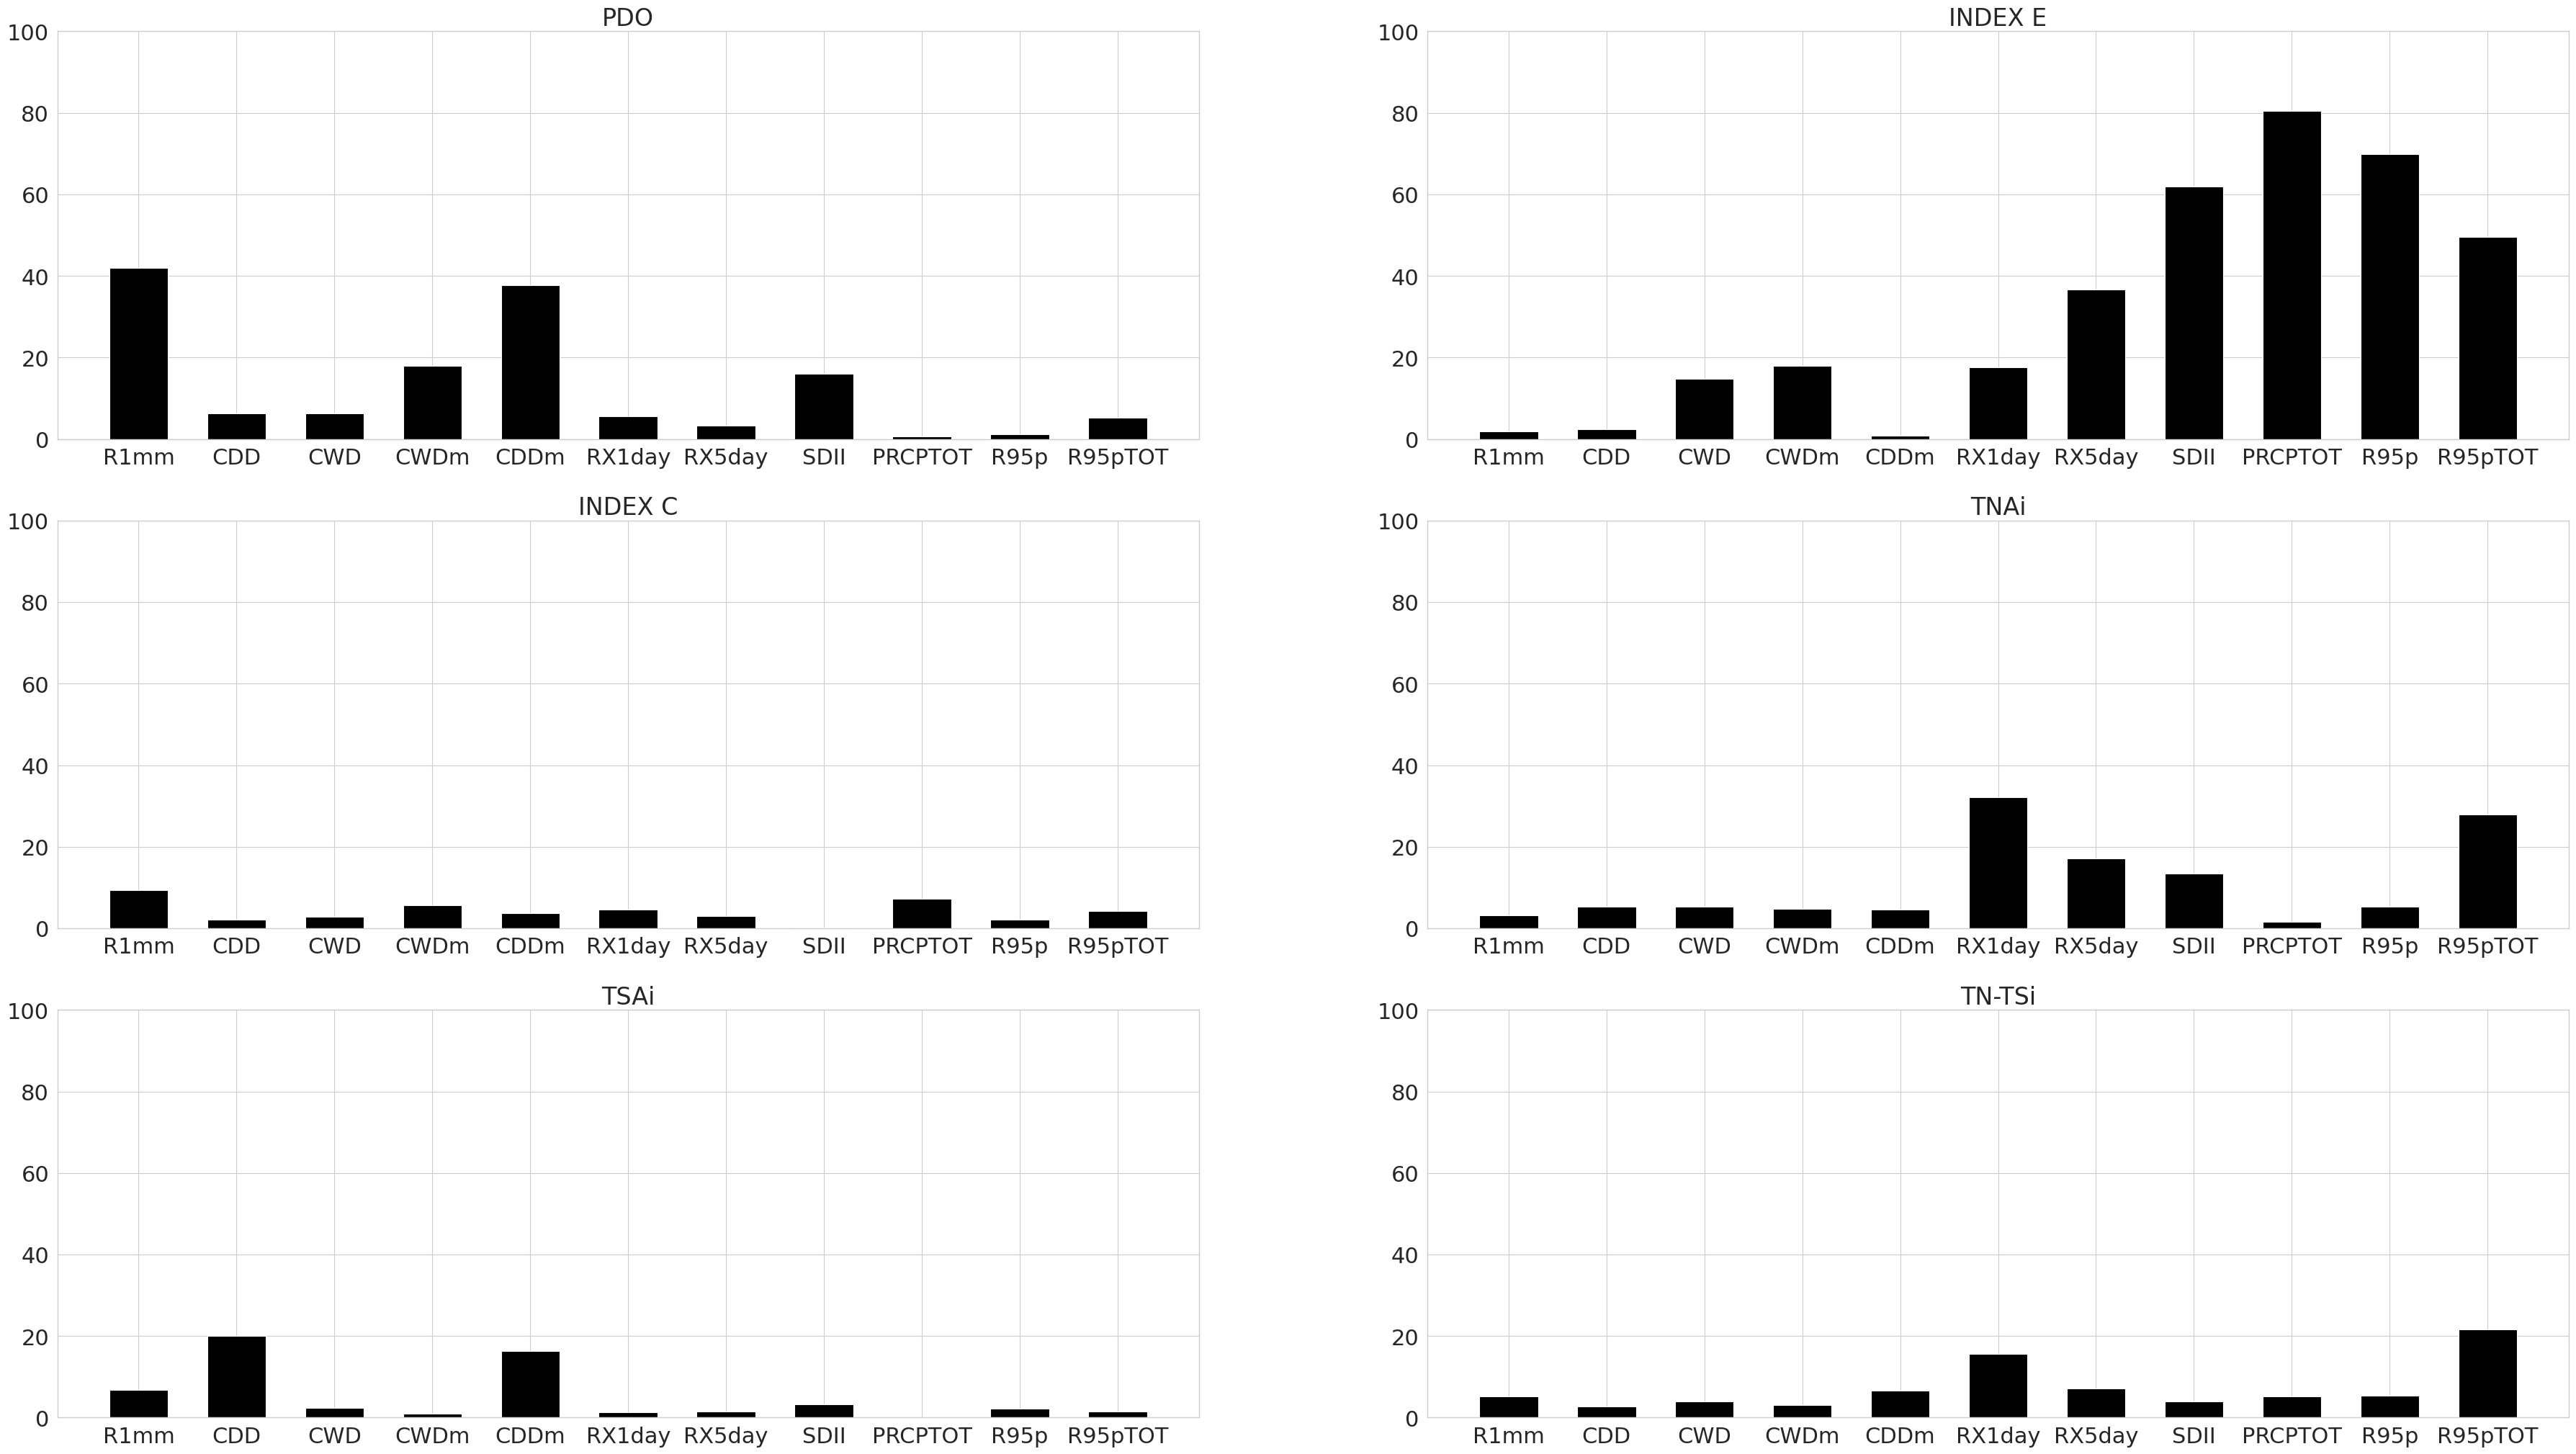

In [ ]:
array_PDO = [PDO_R1mm, PDO_CDD, PDO_CWD, PDO_CWDm, PDO_CDDm, PDO_RX1day, PDO_RX5day, PDO_SDII, PDO_PRCPTOT, PDO_R95p, PDO_R95pTOT]
porcentaje_PDO = [array_PDO[0], array_PDO[1], array_PDO[2], array_PDO[3], array_PDO[4], array_PDO[5], array_PDO[6], array_PDO[7], array_PDO[8], array_PDO[9], array_PDO[10]]

array_E = [E_R1mm, E_CDD, E_CWD, E_CWDm, E_CDDm, E_RX1day, E_RX5day, E_SDII, E_PRCPTOT, E_R95p, E_R95pTOT]
porcentaje_E = [array_E[0], array_E[1], array_E[2], array_E[3], array_E[4], array_E[5], array_E[6], array_E[7], array_E[8], array_E[9], array_E[10]]

array_C = [C_R1mm, C_CDD, C_CWD, C_CWDm, C_CDDm, C_RX1day, C_RX5day, C_SDII, C_PRCPTOT, C_R95p, C_R95pTOT]
porcentaje_C = [array_C[0], array_C[1], array_C[2], array_C[3], array_C[4], array_C[5], array_C[6], array_C[7], array_C[8], array_C[9], array_C[10]]

array_TNA = [TNA_R1mm, TNA_CDD, TNA_CWD, TNA_CWDm, TNA_CDDm, TNA_RX1day, TNA_RX5day, TNA_SDII, TNA_PRCPTOT, TNA_R95p, TNA_R95pTOT]
porcentaje_TNA = [array_TNA[0], array_TNA[1], array_TNA[2], array_TNA[3], array_TNA[4], array_TNA[5], array_TNA[6], array_TNA[7], array_TNA[8], array_TNA[9], array_TNA[10]]

array_TSA = [TSA_R1mm, TSA_CDD, TSA_CWD, TSA_CWDm, TSA_CDDm, TSA_RX1day, TSA_RX5day, TSA_SDII, TSA_PRCPTOT, TSA_R95p, TSA_R95pTOT]
porcentaje_TSA = [array_TSA[0], array_TSA[1], array_TSA[2], array_TSA[3], array_TSA[4], array_TSA[5], array_TSA[6], array_TSA[7], array_TSA[8], array_TSA[9], array_TSA[10]]

array_TNS = [TNS_R1mm, TNS_CDD, TNS_CWD, TNS_CWDm, TNS_CDDm, TNS_RX1day, TNS_RX5day, TNS_SDII, TNS_PRCPTOT, TNS_R95p, TNS_R95pTOT]
porcentaje_TNS = [array_TNS[0], array_TNS[1], array_TNS[2], array_TNS[3], array_TNS[4], array_TNS[5], array_TNS[6], array_TNS[7], array_TNS[8], array_TNS[9], array_TNS[10]]

etiquetas = ["R1mm", "CDD", "CWD", "CWDm", "CDDm", "RX1day", "RX5day", "SDII", "PRCPTOT", "R95p", "R95pTOT"]
colores = ["k"]
grosor = [0.6]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(45, 25))

# Graficas 1 y 2
axs[0, 0].bar(x=etiquetas, height=porcentaje_PDO, width=grosor, color=colores)
axs[0, 0].set_title('PDO')

axs[0, 1].bar(x=etiquetas, height=porcentaje_E, width=grosor, color=colores)
axs[0, 1].set_title('INDEX E')

axs[1, 0].bar(x=etiquetas, height=porcentaje_C, width=grosor, color=colores)
axs[1, 0].set_title('INDEX C')

axs[1, 1].bar(x=etiquetas, height=porcentaje_TNA, width=grosor, color=colores)
axs[1, 1].set_title('TNAi')

axs[2, 0].bar(x=etiquetas, height=porcentaje_TSA, width=grosor, color=colores)
axs[2, 0].set_title('TSAi')

axs[2, 1].bar(x=etiquetas, height=porcentaje_TNS, width=grosor, color=colores)
axs[2, 1].set_title('TN-TSi')

ylim = (0, 100)
for ax in axs.flat:
    ax.set_ylim(ylim)

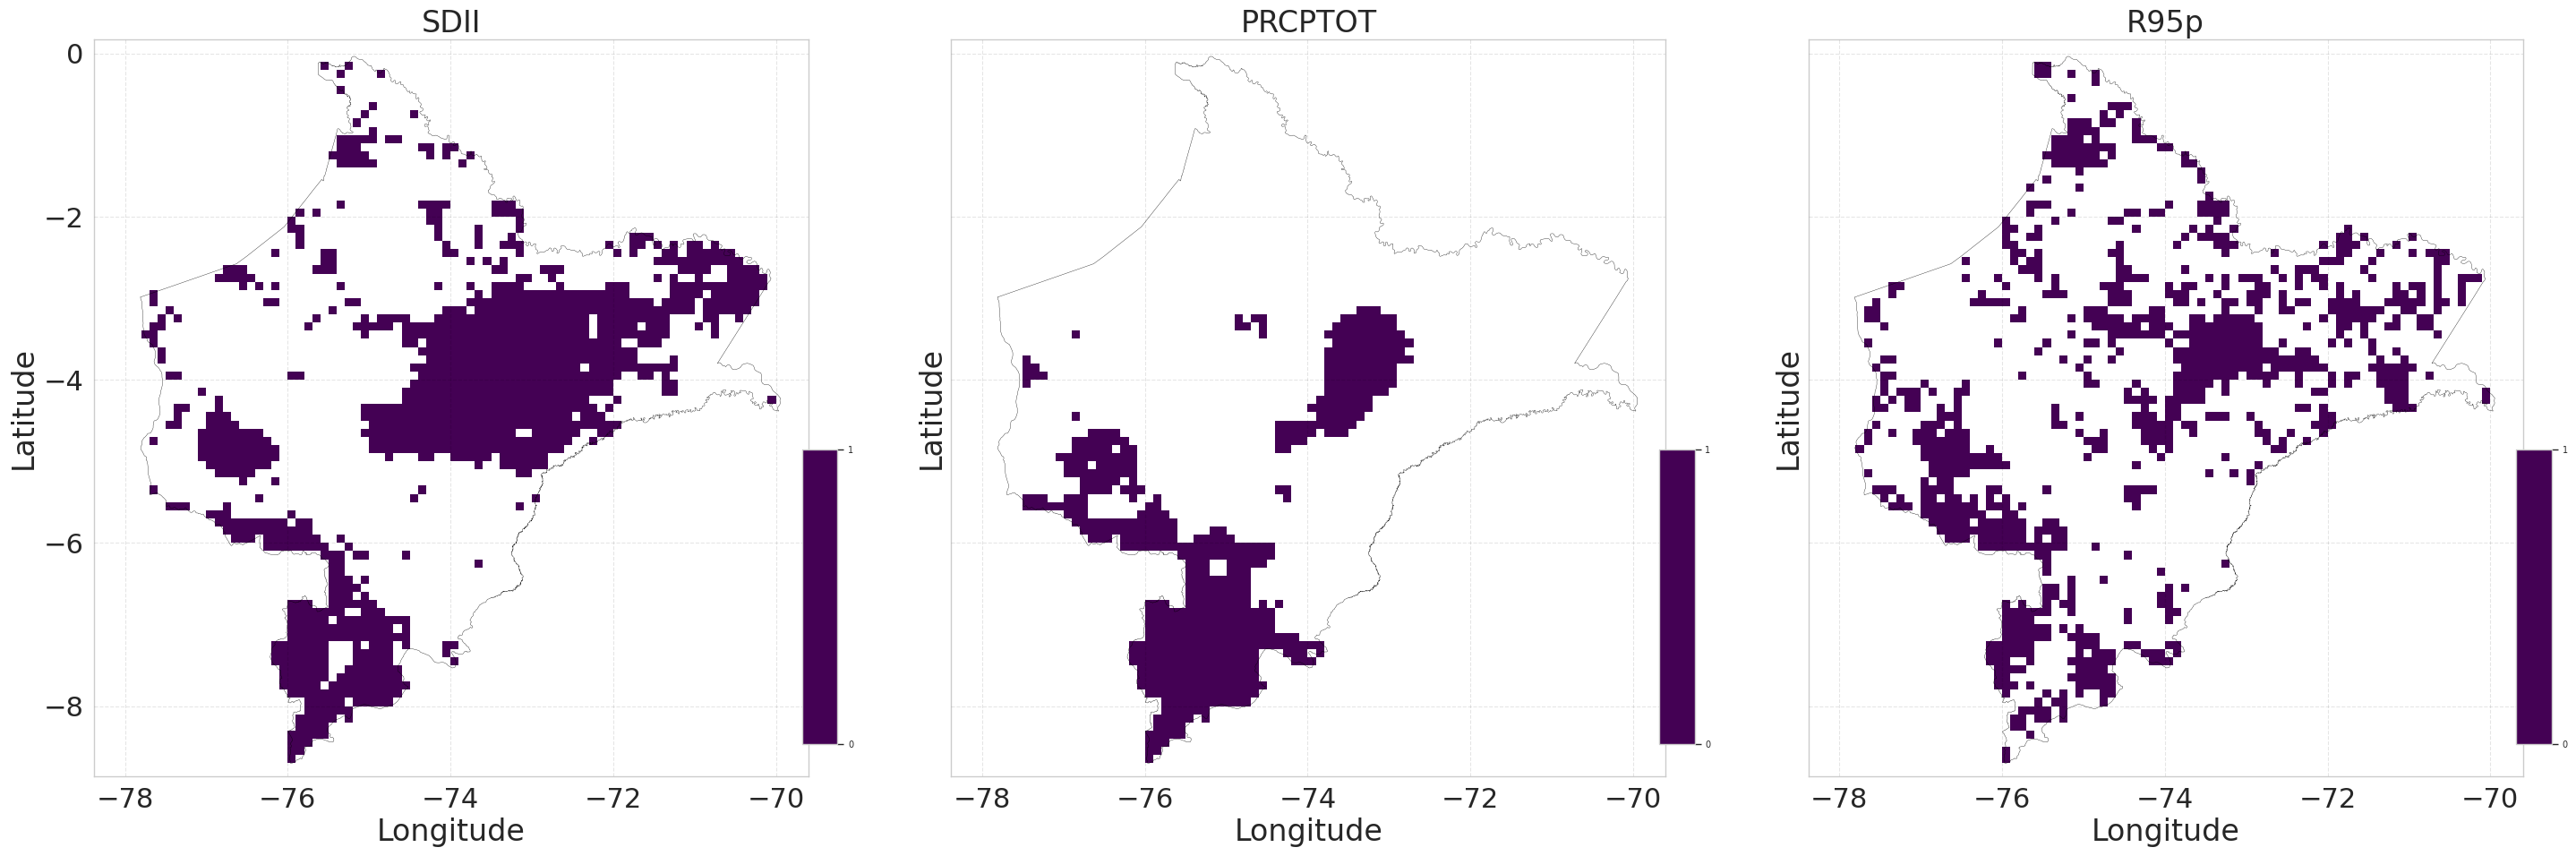

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 2})
fig, ((ax, ax2,ax3)) = plt.subplots(1, 3, figsize=(35,35), dpi = 100, sharex=True, sharey=True)


#plot figure 1
ax.set_axisbelow(False)
im = Spearman_indiceE_SDII.plot(ax = ax, levels = [0,1], add_colorbar=False)
axin = inset_axes(ax, width='5%',
                  height='40%', loc = 'lower right',
                  bbox_to_anchor = (0.06, 0.025, 1 ,1), bbox_transform = ax.transAxes)
#localizando colorbar
cb = plt.colorbar(im, cax=axin,
                  orientation = "vertical",
                  aspect = 4, ticks = [0,1])
cb.ax.set_yticklabels([0,1], fontdict={"fontsize":7})


#shapes
loreto.geometry.boundary.plot(ax = ax, edgecolor = "black", linewidth = .25)

#plot features
ax.set_ylim(-8.86, 0.17)
ax.set_xlim(-78.38, -69.6)
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
ax.set_title('SDII')
ax.grid(True, linestyle='--', color = "black", alpha = 0.1)


#plot figure 2
ax2.set_axisbelow(False)
im = Spearman_indiceE_PRCPTOT.plot(ax = ax2, levels = [0,1], add_colorbar=False)
axin = inset_axes(ax, width='5%',
                  height='40%', loc = 'lower right',
                  bbox_to_anchor = (0.06, 0.025, 1 ,1), bbox_transform = ax2.transAxes)
#colorbar
cb = plt.colorbar(im, cax=axin,
                  orientation = "vertical",
                  aspect = 4, ticks = [0,1])
cb.ax.set_yticklabels([0,1], fontdict={"fontsize":7})

#shapes
loreto.geometry.boundary.plot(ax = ax2, edgecolor = "black", linewidth = .25)

#plot features
ax2.set_ylim(-8.86, 0.17)
ax2.set_xlim(-78.38, -69.6)
ax2.set_ylabel("Latitude")
ax2.set_xlabel("Longitude")
ax2.set_title('PRCPTOT')
ax2.grid(True, linestyle='--', color = "black", alpha = 0.1)


#plot figure 3
ax3.set_axisbelow(False)
im = Spearman_indiceE_R95p.plot(ax = ax3, levels = [0,1], add_colorbar=False)
axin = inset_axes(ax, width='5%',
                  height='40%', loc = 'lower right',
                  bbox_to_anchor = (0.06, 0.025, 1 ,1), bbox_transform = ax3.transAxes)
#colorbar
cb = plt.colorbar(im, cax=axin,
                  orientation = "vertical",
                  aspect = 4, ticks = [0,1])
cb.ax.set_yticklabels([0,1], fontdict={"fontsize":7})

#shapefiles
loreto.geometry.boundary.plot(ax = ax3, edgecolor = "black", linewidth = .25)

#plot features
ax3.set_ylim(-8.86, 0.17)
ax3.set_xlim(-78.38, -69.6)
ax3.set_ylabel("Latitude")
ax3.set_xlabel("Longitude")
ax3.set_title("R95p")
ax3.grid(True, linestyle='--', color = "black", alpha = 0.1)

#save plot
#plt.savefig("wglc_cc_pp_M_1_6.png")
plt.show()